# ÌôòÍ≤ΩÏÑ§Ï†ï

In [38]:
import re
import gc
import sys
import ast
import shap
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import dataframe_image as dfi
import statsmodels.api as sm

from imblearn.combine import SMOTETomek
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from flaml import AutoML
from sklearn.linear_model import LogisticRegression
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [3]:
import warnings    
warnings.filterwarnings("ignore")

In [4]:
# 1. Ìè∞Ìä∏ Í≤ΩÎ°úÏôÄ Ìè∞Ìä∏ Ïù¥Î¶Ñ ÏÑ§Ï†ï
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = 'Apple SD Gothic Neo'

# 2. Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rc('font', family=font_name)

# 3. Ìè∞Ìä∏ Îì±Î°ù (ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ)
fm.fontManager.addfont(font_path)

# 4. ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏Í∞Ä Íπ®ÏßÄÏßÄ ÏïäÎèÑÎ°ù ÏÑ§Ï†ï
plt.rcParams['axes.unicode_minus'] = False

# 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ

## 1.1 Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [4]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
# 3Ïùº Ï≤¥Ìóò Ïã†Ï≤≠ (Ïú†Ï†Äid, 3ÏùºÏ≤¥ÌóòÏã†Ï≤≠ÏùºÏãú)
trial_register = pd.read_csv('data/trial_register.csv')

# 3ÏùºÏ≤¥Ìóò Ïã†Ï≤≠Ïûê ÏùºÏûêÎ≥Ñ Î∞©Î¨∏Í∏∞Î°ù (Ïú†Ï†Äid, ÎÇ†Ïßú, ÏßÄÏ†êid, ÏµúÏ¥àÏûÖÏã§ÏãúÍ∞Å, ÏµúÏ¢ÖÌá¥Ïã§ÏãúÍ∞Å, Ï≤¥Î•òÏãúÍ∞Ñ)
trial_visit_info = pd.read_csv('data/trial_visit_info.csv')

# 3ÏùºÏ≤¥Ìóò Ïã†Ï≤≠Ïûê Ï∂úÏûÖÍ∏∞Î°ù (Ïú†Ï†Äid, ÏßÄÏ†êid, timestamp, Ï∂úÏûÖÎ∞©Ìñ•)
trial_access_log = pd.read_csv('data/trial_access_log.csv')

# 3ÏùºÏ≤¥Ìóò Ïã†Ï≤≠Ïûê Í≤∞Ï†ú Ïó¨Î∂Ä (Ïú†Ï†Äid, Í≤∞Ï†úÏó¨Î∂Ä)
trial_payment = pd.read_csv('data/trial_payment.csv')

### 1.1.1 3Ïùº Ï≤¥Ìóò Ïã†Ï≤≠ Îç∞Ïù¥ÌÑ∞

In [5]:
trial_register.head()

trial_date                             user_uuid
0  2023-12-21  2b251333-8676-4c11-a736-dcf2350f8821
1  2023-12-21  e111619a-0975-451b-9a4a-bc8aea7b7b84
2  2023-12-21  4a184795-b056-4572-a874-644f68609ea3
3  2023-12-21  2ba8ab19-2d40-4423-ad04-f0f9ca814871
4  2023-12-21  1d49ba36-6c23-405b-9514-aa7f4aeceff0

In [6]:
print("Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: ", trial_register.shape)
print("Ïó¥ Ïù¥Î¶Ñ: \n", trial_register.columns)

Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:  (9659, 2)
Ïó¥ Ïù¥Î¶Ñ: 
 Index(['trial_date', 'user_uuid'], dtype='object')


In [7]:
print("Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥")
trial_register.info()

Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  9659 non-null   object
 1   user_uuid   9659 non-null   object
dtypes: object(2)
memory usage: 151.1+ KB


- `trial_date`Îäî ÎÇ†ÏßúÏù¥ÎØÄÎ°ú `datetime` ÌÉÄÏûÖÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.

In [8]:
# Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ Î≥ÄÌôò
trial_register['trial_date'] = pd.to_datetime(trial_register['trial_date'])
trial_register.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trial_date  9659 non-null   datetime64[ns]
 1   user_uuid   9659 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 151.1+ KB


In [9]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_register.head()

trial_date                             user_uuid
0 2023-12-21  2b251333-8676-4c11-a736-dcf2350f8821
1 2023-12-21  e111619a-0975-451b-9a4a-bc8aea7b7b84
2 2023-12-21  4a184795-b056-4572-a874-644f68609ea3
3 2023-12-21  2ba8ab19-2d40-4423-ad04-f0f9ca814871
4 2023-12-21  1d49ba36-6c23-405b-9514-aa7f4aeceff0

### 1.1.2 3ÏùºÏ≤¥Ìóò Ïã†Ï≤≠Ïûê ÏùºÏûêÎ≥Ñ Î∞©Î¨∏Í∏∞Î°ù Îç∞Ïù¥ÌÑ∞

In [10]:
trial_visit_info.head()

site_id        date        stay_time  stay_time_second  \
0        1  2023-12-23  01:11:19.983486              4279   
1        1  2023-12-24  04:35:10.361341             16510   
2        1  2023-12-25  02:09:54.117163              7794   
3        1  2023-12-23  04:37:36.134901             16656   
4        3  2023-12-26  04:32:05.289251             16325   

             first_enter_time             last_leave_time  \
0  2023-12-23 16:11:25.345793  2023-12-23 17:25:32.233995   
1  2023-12-24 16:10:45.668026  2023-12-24 20:53:34.842447   
2  2023-12-25 10:19:47.087268  2023-12-25 12:39:51.221372   
3  2023-12-23 14:49:40.302823  2023-12-23 19:27:39.406803   
4  2023-12-26 14:57:10.220793  2023-12-26 19:34:36.971542   

                              user_uuid  
0  939fc566-61cd-47f0-a3ce-e2936fdcff73  
1  939fc566-61cd-47f0-a3ce-e2936fdcff73  
2  939fc566-61cd-47f0-a3ce-e2936fdcff73  
3  ba49324f-d317-4053-adf9-2b17b3f07594  
4  ba49324f-d317-4053-adf9-2b17b3f07594

In [11]:
print("Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: ", trial_visit_info.shape)
print("Ïó¥ Ïù¥Î¶Ñ: \n", trial_visit_info.columns)

Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:  (11477, 7)
Ïó¥ Ïù¥Î¶Ñ: 
 Index(['site_id', 'date', 'stay_time', 'stay_time_second', 'first_enter_time',
       'last_leave_time', 'user_uuid'],
      dtype='object')


In [12]:
print("Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥")
trial_visit_info.info()

Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_id           11477 non-null  int64 
 1   date              11477 non-null  object
 2   stay_time         11477 non-null  object
 3   stay_time_second  11477 non-null  int64 
 4   first_enter_time  10922 non-null  object
 5   last_leave_time   10922 non-null  object
 6   user_uuid         11477 non-null  object
dtypes: int64(2), object(5)
memory usage: 627.8+ KB


In [13]:
trial_visit_info['date'] = pd.to_datetime(trial_visit_info['date'])

# site_idÎ≥Ñ Í∞ÄÏû• Ïù¥Î•∏ ÎÇ†Ïßú Ï∂îÏ∂ú
earliest_dates = trial_visit_info.groupby('site_id')['date'].min().reset_index()

# Í≤∞Í≥º Ï∂úÎ†•
print(earliest_dates)

   site_id       date
0        1 2021-05-03
1        2 2021-05-06
2        3 2021-05-02
3        4 2021-05-12
4        5 2021-09-03
5        6 2021-11-15
6       17 2022-08-08
7       47 2022-12-09
8       49 2023-04-22


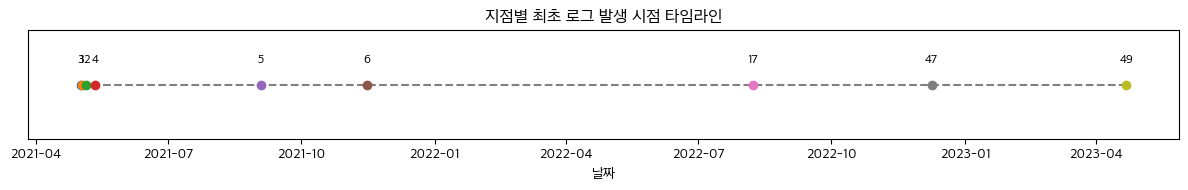

In [14]:
# Îç∞Ïù¥ÌÑ∞ Ï†ïÎ†¨
earliest_dates_sorted = earliest_dates.sort_values('date')

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 2))
plt.hlines(y=1, xmin=earliest_dates_sorted['date'].min(), xmax=earliest_dates_sorted['date'].max(), color='gray', linestyles='dashed')

# Ïù¥Î≤§Ìä∏ Ï†ê Ï∞çÍ∏∞
for idx, row in earliest_dates_sorted.iterrows():
    plt.plot(row['date'], 1, 'o', label=f"Site {row['site_id']}")
    plt.text(row['date'], 1.02, f"{row['site_id']}", ha='center', va='bottom', fontsize=9)

plt.yticks([])
plt.title("ÏßÄÏ†êÎ≥Ñ ÏµúÏ¥à Î°úÍ∑∏ Î∞úÏÉù ÏãúÏ†ê ÌÉÄÏûÑÎùºÏù∏")
plt.xlabel("ÎÇ†Ïßú")
plt.tight_layout()
plt.show()

- Î≥∏ Î∂ÑÏÑùÏóêÏÑúÎäî `site_id`Î•º Ïù¥Ïö©ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú Ï†úÍ±∞
    - ÏßÄÏ†êÏóê ÎåÄÌïú Ï†ïÎ≥¥Í∞Ä "ÌèâÏàò"Î∞ñÏóê ÏóÜÏúºÎ©∞, ÏßÄÏ†êÎ≥ÑÎ°ú Î°úÍ∑∏Í∞Ä ÏåìÏù∏ Í∏∞Í∞ÑÏù¥ ÏÉÅÏù¥ÌïòÍ≤å Îã§Î¶Ñ
- `first_enter_time`Í≥º `last_leave_time`Ïóê Í≤∞Ï∏°Ïπò Î∞úÍ≤¨, Ï∂îÌõÑ Ï≤òÎ¶¨ ÌïÑÏöî
- `date`, `first_enter_time`, `last_leave_time`ÏùÄ `datetime` ÌÉÄÏûÖÏúºÎ°ú Î≥ÄÌôò ÌïÑÏöî
- `stay_time`ÏùÄ `stay_time_second`ÏôÄ Í∞ôÏùÄ Ï†ïÎ≥¥Î•º Îã¥Í≥† ÏûàÏúºÎØÄÎ°ú Ï†úÍ±∞
- `stay_time_second`Ïùò Ï¥àÎäî ÎÑàÎ¨¥ ÏÑ∏Î∞ÄÌïú Ï†ïÎ≥¥Î•º Îã¥Í≥† ÏûàÏúºÎØÄÎ°ú, ÏãúÍ∞ÑÏúºÎ°ú Î≥ÄÌôò ÌõÑ Ï†úÍ±∞ -> `stay_time_hour`

In [15]:
# site_id Ï†úÍ±∞
trial_visit_info = trial_visit_info.drop(columns=['site_id'])

# Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ Î≥ÄÌôò
trial_visit_info['date'] = pd.to_datetime(trial_visit_info['date'])
trial_visit_info['first_enter_time'] = pd.to_datetime(trial_visit_info['first_enter_time'], errors='coerce')
trial_visit_info['last_leave_time'] = pd.to_datetime(trial_visit_info['last_leave_time'], errors='coerce')

# 1. stay_time Ïª¨Îüº Ï†úÍ±∞
trial_visit_info = trial_visit_info.drop(columns=['stay_time'])

# 2. stay_time_second ‚Üí stay_time_hour (Ï†ïÏàòÌòï, Î∞òÏò¨Î¶º)
trial_visit_info['stay_time_hour'] = (trial_visit_info['stay_time_second'] / 3600).round().astype(int)

# 3. stay_time_second Ï†úÍ±∞
trial_visit_info = trial_visit_info.drop(columns=['stay_time_second'])

trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              11477 non-null  datetime64[ns]
 1   first_enter_time  10124 non-null  datetime64[ns]
 2   last_leave_time   10147 non-null  datetime64[ns]
 3   user_uuid         11477 non-null  object        
 4   stay_time_hour    11477 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 448.4+ KB


In [16]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_visit_info.head()

date           first_enter_time            last_leave_time  \
0 2023-12-23 2023-12-23 16:11:25.345793 2023-12-23 17:25:32.233995   
1 2023-12-24 2023-12-24 16:10:45.668026 2023-12-24 20:53:34.842447   
2 2023-12-25 2023-12-25 10:19:47.087268 2023-12-25 12:39:51.221372   
3 2023-12-23 2023-12-23 14:49:40.302823 2023-12-23 19:27:39.406803   
4 2023-12-26 2023-12-26 14:57:10.220793 2023-12-26 19:34:36.971542   

                              user_uuid  stay_time_hour  
0  939fc566-61cd-47f0-a3ce-e2936fdcff73               1  
1  939fc566-61cd-47f0-a3ce-e2936fdcff73               5  
2  939fc566-61cd-47f0-a3ce-e2936fdcff73               2  
3  ba49324f-d317-4053-adf9-2b17b3f07594               5  
4  ba49324f-d317-4053-adf9-2b17b3f07594               5

### 3ÏùºÏ≤¥Ìóò Ïã†Ï≤≠Ïûê Ï∂úÏûÖÍ∏∞Î°ù Îç∞Ïù¥ÌÑ∞

In [17]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_access_log.head()

id  checkin                       cdate  site_id  \
0  1719038        1  2023-07-07 07:11:55.201673       49   
1  1716702        2  2023-07-06 15:15:58.761284       49   
2  1719956        2  2023-07-07 14:10:41.848998       49   
3  1716588        1  2023-07-06 13:09:48.758097       49   
4  1719649        1  2023-07-07 10:12:42.083352       49   

                              user_uuid  
0  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89  
1  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89  
2  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89  
3  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89  
4  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89

In [18]:
print("Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: ", trial_access_log.shape)
print("Ïó¥ Ïù¥Î¶Ñ: \n", trial_access_log.columns)

Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:  (63708, 5)
Ïó¥ Ïù¥Î¶Ñ: 
 Index(['id', 'checkin', 'cdate', 'site_id', 'user_uuid'], dtype='object')


In [19]:
print("Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥")
trial_access_log.info()

Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         63708 non-null  int64 
 1   checkin    63708 non-null  int64 
 2   cdate      63708 non-null  object
 3   site_id    63708 non-null  int64 
 4   user_uuid  63708 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.4+ MB


- `id`, `site_id`Îäî Î≥∏ Î∂ÑÏÑùÏóêÏÑú ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú Ï†úÍ±∞
- `cdate`Îäî `datetime`(KST)Î°ú Î≥ÄÌôò ÌïÑÏöî

In [20]:
# id, site_id Ï†úÍ±∞
trial_access_log = trial_access_log.drop(columns=['id', 'site_id'])

# cdate ‚Üí datetime Î≥ÄÌôò + KSTÎ°ú Î≥ÄÌôò ÌõÑ, ÌÉÄÏûÑÏ°¥ Ï†úÍ±∞
trial_access_log['cdate'] = pd.to_datetime(trial_access_log['cdate'], utc=True) \
                               .dt.tz_convert('Asia/Seoul') \
                               .dt.tz_localize(None)

# ÌôïÏù∏
trial_access_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   checkin    63708 non-null  int64         
 1   cdate      63708 non-null  datetime64[ns]
 2   user_uuid  63708 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.5+ MB


In [21]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_access_log.head()

checkin                      cdate                             user_uuid
0        1 2023-07-07 16:11:55.201673  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
1        2 2023-07-07 00:15:58.761284  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
2        2 2023-07-07 23:10:41.848998  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
3        1 2023-07-06 22:09:48.758097  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
4        1 2023-07-07 19:12:42.083352  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89

### 3ÏùºÏ≤¥Ìóò Ïã†Ï≤≠Ïûê Í≤∞Ï†ú Ïó¨Î∂Ä Îç∞Ïù¥ÌÑ∞

In [22]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_payment.head()

is_payment                             user_uuid
0           0  2b251333-8676-4c11-a736-dcf2350f8821
1           0  e111619a-0975-451b-9a4a-bc8aea7b7b84
2           1  4a184795-b056-4572-a874-644f68609ea3
3           0  2ba8ab19-2d40-4423-ad04-f0f9ca814871
4           0  1d49ba36-6c23-405b-9514-aa7f4aeceff0

In [23]:
print("Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: ", trial_payment.shape)
print("Ïó¥ Ïù¥Î¶Ñ: \n", trial_payment.columns)

Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:  (9659, 2)
Ïó¥ Ïù¥Î¶Ñ: 
 Index(['is_payment', 'user_uuid'], dtype='object')


In [24]:
print("Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥")
trial_payment.info()

Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   is_payment  9659 non-null   int64 
 1   user_uuid   9659 non-null   object
dtypes: int64(1), object(1)
memory usage: 151.1+ KB


- Î≥ÑÎèÑÏùò Ï≤òÎ¶¨ ÌïÑÏöî ÏóÜÏùå.

## 1.2 Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨

### 1.2.1 Î∞©Î¨∏Í∏∞Î°ù ÎÇ¥ ÏµúÏ¥àÏûÖÏã§ÏãúÍ∞Å / ÏµúÏ¢ÖÌá¥Ïã§ÏãúÍ∞ÅÏùò Í≤∞Ï∏°Ïπò

- `trial_visit_info`Ïùò `first_enter_time`, `last_leave_time` Ïó¥ÏóêÏÑú Í≤∞Ï∏°ÏπòÍ∞Ä Í∞ÅÍ∞Å 555Í±¥Ïî© Î∞úÏÉùÌñàÏúºÎØÄÎ°ú Í≤∞Ï∏°ÏπòÎ•º Ï≤òÎ¶¨Ìï©ÎãàÎã§.
- Îç∞Ïù¥ÌÑ∞ Ï†úÍ≥µÏûêÏùò ÏÑ§Î™ÖÏóê Îî∞Î•¥Î©¥, Ïù¥Îäî "`stay_time`ÏùÄ Í≤∞Ï∏°ÏπòÍ∞Ä ÏóÜÎäîÎç∞, `first_enter_time` ÌòπÏùÄ `last_leave_time`Ïù¥ Í≤∞Ï∏°ÏπòÏù∏ Í≤ΩÏö∞"Ïóê Ìï¥ÎãπÌï©ÎãàÎã§.
- Í≤∞Ï∏°Ïπò Î∞úÏÉù ÏõêÏù∏ÏùÄ "ÏµúÏ¥à ÏûÖÏã§ / ÏµúÏ¢Ö Ìá¥Ïã§ÏùÑ Ìï† Îïå ÏïûÏóê Î∂ÑÏóê Îî∞Îùº Îì§Ïñ¥Ïò§Îäî Í≤ΩÏö∞Í∞Ä ÏûàÏñ¥ÏÑú Í∏∞Î°ùÏù¥ ÎÇ®ÏßÄ ÏïäÎäî Í≤ΩÏö∞"ÎùºÍ≥† Ìï©ÎãàÎã§.

In [25]:
# Ï†ÑÏ≤¥ Ìñâ Ïàò
total_rows = len(trial_visit_info)

# Í∞Å Ïó¥Ïùò Í≤∞Ï∏°Ïπò ÎπÑÏú® Í≥ÑÏÇ∞
first_enter_na_ratio = trial_visit_info['first_enter_time'].isna().sum() / total_rows
last_leave_na_ratio = trial_visit_info['last_leave_time'].isna().sum() / total_rows

# Í≤∞Í≥º Ï∂úÎ†•
print(f"first_enter_time Í≤∞Ï∏°Ïπò ÎπÑÏú®: {first_enter_na_ratio:.4f}")
print(f"last_leave_time  Í≤∞Ï∏°Ïπò ÎπÑÏú®: {last_leave_na_ratio:.4f}")

# Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Ìñâ Ï∂îÏ∂ú Î∞è ÌëúÏãú
missing_rows = trial_visit_info[
    trial_visit_info['first_enter_time'].isna() | trial_visit_info['last_leave_time'].isna()
]

print(f"\n‚ö†Ô∏è Í≤∞Ï∏°Ïπò Ìè¨Ìï® Ìñâ Ïàò: {len(missing_rows)}")
display(missing_rows.head(10))  # ÌïÑÏöîÏóê Îî∞Îùº Ï†ÑÏ≤¥ Ï∂úÎ†• Í∞ÄÎä•

first_enter_time Í≤∞Ï∏°Ïπò ÎπÑÏú®: 0.1179
last_leave_time  Í≤∞Ï∏°Ïπò ÎπÑÏú®: 0.1159

‚ö†Ô∏è Í≤∞Ï∏°Ïπò Ìè¨Ìï® Ìñâ Ïàò: 2001


date           first_enter_time            last_leave_time  \
18  2023-12-27                        NaT 2023-12-27 15:46:08.599449   
55  2023-12-30 2023-12-30 22:05:32.822669                        NaT   
56  2023-12-31                        NaT 2023-12-31 00:30:23.216706   
86  2023-12-29                        NaT 2023-12-29 15:26:42.106259   
104 2023-12-21                        NaT 2023-12-21 13:48:44.547279   
105 2023-12-20 2023-12-20 22:17:58.538983                        NaT   
123 2023-12-27 2023-12-27 22:06:43.013016                        NaT   
124 2023-12-28                        NaT 2023-12-28 00:04:29.487973   
129 2023-12-29 2023-12-29 12:39:05.814511                        NaT   
130 2023-12-30                        NaT 2023-12-30 20:38:07.472557   

                                user_uuid  stay_time_hour  
18   b159d9f8-9a5e-4602-b251-8a8e95305da5               1  
55   a806f6d6-4bea-40df-b870-212859386e9d               2  
56   a806f6d6-4bea-40df-b870-212859386e9d               0  
86   f70fa4ed-8364-499c-8c49-6d232e6c271b              15  
104  4df43903-b549-405f-90e2-aa769c301ba9               7  
105  4df43903-b549-405f-90e2-aa769c301ba9               2  
123  868bd6d8-a092-4e16-8974-87c11ac0e357               2  
124  868bd6d8-a092-4e16-8974-87c11ac0e357               0  
129  fa06b23d-3a20-448f-8791-557beff8df9f              11  
130  fa06b23d-3a20-448f-8791-557beff8df9f              20

- Îëê Ïó¥ Î™®Îëê Í≤∞Ï∏°ÏπòÍ∞Ä 11% Ïù¥ÏÉÅÏúºÎ°ú Ï†ÅÏßÄ ÏïäÏßÄÎßå, Î∂ÑÏÑùÏùò Ïã†Î¢∞ÏÑ±ÏùÑ ÏúÑÌï¥ Ï†úÍ±∞Ìï©ÎãàÎã§.

In [26]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ïàò
total_rows = len(trial_visit_info)

# Ï†úÍ±∞ ÎåÄÏÉÅ: Îëê Ïó¥ Ï§ë ÌïòÎÇòÎùºÎèÑ Í≤∞Ï∏°Ïù∏ Í≤ΩÏö∞
missing_mask = trial_visit_info['first_enter_time'].isna() | trial_visit_info['last_leave_time'].isna()
num_missing = missing_mask.sum()
num_remaining = total_rows - num_missing
missing_ratio = num_missing / total_rows

# Ï∂úÎ†•
print(f"Ï¥ù Ìñâ Ïàò: {total_rows}")
print(f"Ï†úÍ±∞Îê† Ìñâ Ïàò: {num_missing}")
print(f"Ï†úÍ±∞ ÌõÑ ÎÇ®Îäî Ìñâ Ïàò: {num_remaining}")
print(f"Ï†úÍ±∞ ÎπÑÏú®: {missing_ratio:.2%}")

Ï¥ù Ìñâ Ïàò: 11477
Ï†úÍ±∞Îê† Ìñâ Ïàò: 2001
Ï†úÍ±∞ ÌõÑ ÎÇ®Îäî Ìñâ Ïàò: 9476
Ï†úÍ±∞ ÎπÑÏú®: 17.43%


In [27]:
# Í≤∞Ï∏° Ï†úÍ±∞ ÌõÑ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
trial_visit_info = trial_visit_info[~missing_mask]
trial_visit_info.shape

(9476, 5)

In [28]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_visit_info.head()

date           first_enter_time            last_leave_time  \
0 2023-12-23 2023-12-23 16:11:25.345793 2023-12-23 17:25:32.233995   
1 2023-12-24 2023-12-24 16:10:45.668026 2023-12-24 20:53:34.842447   
2 2023-12-25 2023-12-25 10:19:47.087268 2023-12-25 12:39:51.221372   
3 2023-12-23 2023-12-23 14:49:40.302823 2023-12-23 19:27:39.406803   
4 2023-12-26 2023-12-26 14:57:10.220793 2023-12-26 19:34:36.971542   

                              user_uuid  stay_time_hour  
0  939fc566-61cd-47f0-a3ce-e2936fdcff73               1  
1  939fc566-61cd-47f0-a3ce-e2936fdcff73               5  
2  939fc566-61cd-47f0-a3ce-e2936fdcff73               2  
3  ba49324f-d317-4053-adf9-2b17b3f07594               5  
4  ba49324f-d317-4053-adf9-2b17b3f07594               5

## 1.3 Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨

### 1.3.1 Ï≤¥Ìóò Ïã†Ï≤≠ Í∏∞Î°ù ÎÇ¥ Ï§ëÎ≥µ Ïã†Ï≤≠
Îç∞Ïù¥ÌÑ∞ Ï†úÍ≥µÏûêÏóê Îî∞Î•¥Î©¥, Îã§ÏùåÍ≥º Í∞ôÏùÄ Í≤ΩÏö∞Í∞Ä Ï°¥Ïû¨ÌïúÎã§Í≥† Ìï©ÎãàÎã§.

> ‚ÄòÏã†Í∑ú Í∞ÄÏûÖÏûêÎäî Îî± 1Î≤à 3Ïùº Ï≤¥ÌóòÏùÑ Ïù¥Ïö©Ìï† Ïàò ÏûàÏùå‚ÄôÏóêÎèÑ Î∂àÍµ¨ÌïòÍ≥†
> 1) Í∞ôÏùÄ ÎÇ† 2Ìöå 3Ïùº Ï≤¥ÌóòÏùÑ Ïã†Ï≤≠ÌïòÍ±∞ÎÇò
> 2) ÏÑúÎ°ú Îã§Î•∏ ÎÇ† 2Ìöå 3Ïùº Ï≤¥ÌóòÏùÑ Ïã†Ï≤≠Ìïú Í≤ΩÏö∞Í∞Ä Ï°¥Ïû¨Ìï®

Í∑∏Î¶¨Í≥† Í∑∏ ÏõêÏù∏ÏùÄ Îã§ÏùåÍ≥º Í∞ôÎã§Í≥† Ìï©ÎãàÎã§.
 
> 1) **Í∞ôÏùÄ ÎÇ† 2Ìöå 3Ïùº Ï≤¥ÌóòÏùÑ Ïã†Ï≤≠Ìïú Í≤ΩÏö∞**:
>   - Ï†ÑÏÇ∞ Ïò§Î•òÎ°ú Ïù∏Ìï¥ ÏßÅÏ†ë ÌòÑÏû• Îß§ÎãàÏ†ÄÎì§Ïù¥ ÏûÑÏãúÎ°ú 3Ïùº Ï≤¥ÌóòÌï† Ïàò ÏûàÍ≤å Í∂åÌïú Î∂ÄÏó¨Î•º ÏßÅÏ†ë Ìïú ÏºÄÏù¥Ïä§
> 2) **ÏÑúÎ°ú Îã§Î•∏ ÎÇ† 2Ìöå 3Ïùº Ï≤¥ÌóòÏùÑ Ïã†Ï≤≠Ìïú Í≤ΩÏö∞**:
>   - 3Ïùº Ï≤¥ÌóòÏùÑ Ïã†Ï≤≠ÌñàÎäîÎç∞ Î∞©Î¨∏ÏùÑ Î™ªÌï¥ÏÑú Îã§Î•∏ ÎÇ†Ïóê Ïû¨Ïã†Ï≤≠Ìïú ÏºÄÏù¥Ïä§

Ïù¥ÏÉÅÏùò Í≤ΩÏö∞Î•º Íµ¨Î∂ÑÌïòÏó¨ Îã§ÏùåÍ≥º Í∞ôÏù¥ Ï≤òÎ¶¨Ìï† Ïàò ÏûàÏäµÎãàÎã§.
1) **Í∞ôÏùÄ ÎÇ† 2Ìöå 3Ïùº Ï≤¥ÌóòÏùÑ Ïã†Ï≤≠Ìïú Í≤ΩÏö∞**
    - Ïù¥Îäî Ï†ÑÏÇ∞ Ïò§Î•òÎ°ú Ïù∏Ìï¥ ÌòÑÏû• Îß§ÎãàÏ†ÄÍ∞Ä ÏûÑÏùòÎ°ú Í∂åÌïúÏùÑ Î∂ÄÏó¨Ìïú ÏÇ¨Î°ÄÎ°ú,  
    - ÏÇ¨Ïö©ÏûêÏùò Ïã§Ï†ú ÏùòÎèÑÏôÄ Î¨¥Í¥ÄÌïòÍ≤å Ï§ëÎ≥µÏù¥ Î∞úÏÉùÌïú Í≤ÉÏûÖÎãàÎã§.  
    - Îî∞ÎùºÏÑú **Í∞ÄÏû• Î®ºÏ†Ä Í∏∞Î°ùÎêú Ïã†Ï≤≠Îßå ÎÇ®Í∏∞Í≥†**, Ïù¥ÌõÑ Ï§ëÎ≥µ Ïã†Ï≤≠ÏùÄ Ï†úÍ±∞Ìï©ÎãàÎã§.  
    - ‚Üí ÏÇ¨Ïö©ÏûêÍ∞Ä ÏµúÏ¥àÎ°ú Ï≤¥Ìóò ÏùòÏÇ¨Î•º Î∞ùÌûå **ÏßÑÏ†ïÌïú Ïã†Ï≤≠ ÏãúÏ†ê**ÏùÑ ÎåÄÌëúÍ∞íÏúºÎ°ú Í∞ÑÏ£ºÌï©ÎãàÎã§.
2) **ÏÑúÎ°ú Îã§Î•∏ ÎÇ† 2Ìöå 3Ïùº Ï≤¥ÌóòÏùÑ Ïã†Ï≤≠Ìïú Í≤ΩÏö∞**  
    - Ïù¥Îäî Ï≤´ Ïã†Ï≤≠ ÌõÑ Ïã§Ï†ú Î∞©Î¨∏ÏùÑ ÌïòÏßÄ Î™ªÌïú ÏÇ¨Ïö©ÏûêÍ∞Ä ÏùòÎèÑÏ†ÅÏúºÎ°ú Ïû¨Ïã†Ï≤≠Ìïú ÏÇ¨Î°ÄÏûÖÎãàÎã§.
    - Îëê Î≤àÏß∏ Ïã†Ï≤≠Ïù¥ Î∞úÏÉùÌïú ÏãúÏ†êÏóêÏÑú, ÏÇ¨Ïö©ÏûêÎäî Ïù¥Ï†Ñ Ïã†Ï≤≠Ïóê ÎåÄÏùëÎêòÎäî Î∞©Î¨∏ÏùÑ ÌïòÏßÄ Î™ªÌñàÎã§Îäî Í≤ÉÏùÑ Ïïå Ïàò ÏûàÍ≥†, Îçî Ïù¥ÏÉÅ Ïù¥Ï†Ñ Ïã†Ï≤≠ÏùÄ Ïú†Ìö®ÌïòÏßÄ ÏïäÏäµÎãàÎã§.
    - Îî∞ÎùºÏÑú Ïã§Ï†ú Ï≤¥ÌóòÍ≥º Ïù¥Ïñ¥Ïßà Ïàò ÏûàÎäî ÎßàÏßÄÎßâ Ïã†Ï≤≠Îßå ÎÇ®Í∏∞Í≥† Ïù¥Ï†Ñ Ïã†Ï≤≠Îì§ÏùÄ Î™®Îëê Ï†úÍ±∞Ìï©ÎãàÎã§.

In [29]:
# 1. Í∞ôÏùÄ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ Í∏∞Î°ù Ï∂îÏ∂ú
dup_same_day = trial_register[trial_register.duplicated(subset=['user_uuid', 'trial_date'], keep=False)]

# Í∞ôÏùÄ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ ÏÇ¨Ïö©Ïûê Ïàò
same_day_users = dup_same_day['user_uuid'].nunique()

# Ï§ëÎ≥µ Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (Í∞Å ÎÇ†ÏßúÎãπ Ï≤´ Î≤àÏß∏Îßå Ïú†ÏßÄ)
dedup_same_day = trial_register.drop_duplicates(subset=['user_uuid', 'trial_date'], keep='first')

In [30]:
# 2. Îã§Î•∏ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ ÏÇ¨Ïö©Ïûê ÌÉêÏßÄ
user_counts = dedup_same_day['user_uuid'].value_counts()
reapplicant_users = user_counts[user_counts > 1].index

# Îã§Î•∏ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ Í∏∞Î°ù Ï∂îÏ∂ú
dup_diff_day = dedup_same_day[dedup_same_day['user_uuid'].isin(reapplicant_users)]

In [31]:
# 3. Í≤∞Í≥º Ï∂úÎ†•
print(f"‚úÖ Í∞ôÏùÄ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ ÏÇ¨Ïö©Ïûê Ïàò: {same_day_users}Î™Ö")
print(f"‚úÖ Í∞ôÏùÄ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ Í∏∞Î°ù Ïàò: {len(dup_same_day)}Í±¥")
display(dup_same_day.sort_values(['user_uuid', 'trial_date']).head(10))

print(f"\n‚úÖ Îã§Î•∏ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ ÏÇ¨Ïö©Ïûê Ïàò: {len(reapplicant_users)}Î™Ö")
print(f"‚úÖ Îã§Î•∏ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ Í∏∞Î°ù Ïàò: {len(dup_diff_day)}Í±¥")
display(dup_diff_day.sort_values(['user_uuid', 'trial_date']).head(10))

‚úÖ Í∞ôÏùÄ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ ÏÇ¨Ïö©Ïûê Ïàò: 28Î™Ö
‚úÖ Í∞ôÏùÄ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ Í∏∞Î°ù Ïàò: 56Í±¥


trial_date                             user_uuid
340 2023-12-11  02458b10-7f2b-4030-950b-ba650ce2fb49
341 2023-12-11  02458b10-7f2b-4030-950b-ba650ce2fb49
132 2023-11-24  039fa563-fc65-4b0c-9087-4beb5cd17fd7
133 2023-11-24  039fa563-fc65-4b0c-9087-4beb5cd17fd7
175 2023-11-27  06e78cdd-c7f0-4b45-af6d-9126125d0686
176 2023-11-27  06e78cdd-c7f0-4b45-af6d-9126125d0686
313 2023-12-09  091cdea5-fc99-47fd-a722-3fe190f9cb26
314 2023-12-09  091cdea5-fc99-47fd-a722-3fe190f9cb26
103 2022-12-27  19c8e329-9654-4178-989d-c93617655650
104 2022-12-27  19c8e329-9654-4178-989d-c93617655650


‚úÖ Îã§Î•∏ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ ÏÇ¨Ïö©Ïûê Ïàò: 7Î™Ö
‚úÖ Îã§Î•∏ ÎÇ† Ï§ëÎ≥µ Ïã†Ï≤≠ Í∏∞Î°ù Ïàò: 14Í±¥


trial_date                             user_uuid
5624 2022-01-28  14872783-3af7-492a-b51c-12f3003b76f1
5625 2023-02-10  14872783-3af7-492a-b51c-12f3003b76f1
1682 2021-09-06  4008307f-486f-408f-b90b-e01398972029
1683 2022-03-25  4008307f-486f-408f-b90b-e01398972029
3554 2022-03-14  5b16f32b-3344-4b39-b2bf-8cf1caac78fa
3555 2023-03-22  5b16f32b-3344-4b39-b2bf-8cf1caac78fa
4968 2022-09-05  6a88014b-fbbd-4e73-8036-04435c062a97
4969 2023-02-10  6a88014b-fbbd-4e73-8036-04435c062a97
4674 2022-08-02  bd3ed6c2-f139-4e0c-b53e-b956101b2822
4675 2022-10-21  bd3ed6c2-f139-4e0c-b53e-b956101b2822

In [32]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_register.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trial_date  9659 non-null   datetime64[ns]
 1   user_uuid   9659 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 151.1+ KB


### 2. "ÏµúÏ¢ÖÌá¥Ïã§ÏãúÍ∞Å - ÏµúÏ¥àÏûÖÏã§ÏãúÍ∞Å"Ïù¥ "Ï≤¥Î•òÏãúÍ∞Ñ"Í≥º Îã§Î•∏ Í≤ΩÏö∞

Îç∞Ïù¥ÌÑ∞ Ï†úÍ≥µÏûêÏóê Îî∞Î•¥Î©¥, `trial_visit_info` ÎÇ¥ÏóêÎäî Îã§ÏùåÍ≥º Í∞ôÏùÄ ÏÇ¨Î°ÄÍ∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§:

> `stay_time_hour`Í≥º `first_enter_time`, `last_leave_time` Í∞ÑÏùò ÏãúÍ∞Ñ Ï∞®Ïù¥Í∞Ä ÏùºÏπòÌïòÏßÄ ÏïäÎäî Í≤ΩÏö∞

Ïù¥Îäî Ïù¥ÏÉÅÏπòÎùºÍ∏∞Î≥¥Îã§Îäî Îëê ÏßÄÌëúÍ∞Ä **ÏùòÎèÑÏ†ÅÏúºÎ°ú Îã§Î•∏ Í∞úÎÖêÏùÑ Ï∏°Ï†ï**ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê Î∞úÏÉùÌïòÎäî Ï∞®Ïù¥ÏûÖÎãàÎã§.  
- `first_enter_time`: ÏµúÏ¥à ÏûÖÏã§ ÏãúÍ∞Å  
- `last_leave_time`: ÏµúÏ¢Ö Ìá¥Ïã§ ÏãúÍ∞Å  
- `stay_time_hour`: Ïã§Ï†ú Ï≤¥Î•ò ÏãúÍ∞ÑÏùò Ìï© (Ï§ëÍ∞Ñ Ìá¥Ïã§ ÏãúÍ∞ÑÏùÄ Ï†úÏô∏Îê®)

Ï¶â, ÏÇ¨Ïö©ÏûêÍ∞Ä **ÏûÖÏã§ ÌõÑ Ï§ëÍ∞ÑÏóê Ïô∏Ï∂úÌñàÎã§ ÎèåÏïÑÏò® Í≤ΩÏö∞**,  
`last_leave_time - first_enter_time`ÏùÄ **Ï¥ù Ïù¥Ïö© Íµ¨Í∞Ñ**Ïù¥Í≥†,
Ïù¥ Íµ¨Í∞ÑÏóêÎäî Ïã§Ï†ú Ï≤¥Î•òÌïòÏßÄ ÏïäÏïòÎçò ÏãúÍ∞Ñ(Ïòà: Ïô∏Ï∂ú ÏãúÍ∞Ñ)ÎèÑ Ìè¨Ìï®Îê† Ïàò ÏûàÏäµÎãàÎã§.
`stay_time_hour`ÏùÄ **Ïã§Ï†ú Î®∏Î¨∏ ÏãúÍ∞ÑÎßå ÎàÑÏ†ÅÌïú Í∞í**ÏûÖÎãàÎã§.

Îî∞ÎùºÏÑú Ïù¥ ÎëòÏùÑ ÏùºÏπòÏãúÌÇ§Îäî Ï†ïÏ†úÎäî Î∂ÄÏ†ÅÏ†àÌïòÎ©∞, Îëê Í∞íÏùÑ Î™®Îëê Î≥¥Ï°¥Ìï©ÎãàÎã§.

In [33]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_visit_info.head()

date           first_enter_time            last_leave_time  \
0 2023-12-23 2023-12-23 16:11:25.345793 2023-12-23 17:25:32.233995   
1 2023-12-24 2023-12-24 16:10:45.668026 2023-12-24 20:53:34.842447   
2 2023-12-25 2023-12-25 10:19:47.087268 2023-12-25 12:39:51.221372   
3 2023-12-23 2023-12-23 14:49:40.302823 2023-12-23 19:27:39.406803   
4 2023-12-26 2023-12-26 14:57:10.220793 2023-12-26 19:34:36.971542   

                              user_uuid  stay_time_hour  
0  939fc566-61cd-47f0-a3ce-e2936fdcff73               1  
1  939fc566-61cd-47f0-a3ce-e2936fdcff73               5  
2  939fc566-61cd-47f0-a3ce-e2936fdcff73               2  
3  ba49324f-d317-4053-adf9-2b17b3f07594               5  
4  ba49324f-d317-4053-adf9-2b17b3f07594               5

In [34]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9476 entries, 0 to 11475
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              9476 non-null   datetime64[ns]
 1   first_enter_time  9476 non-null   datetime64[ns]
 2   last_leave_time   9476 non-null   datetime64[ns]
 3   user_uuid         9476 non-null   object        
 4   stay_time_hour    9476 non-null   int64         
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 444.2+ KB


### 3. Î∞©Î¨∏Í∏∞Î°ù ÎÇ¥ 4ÏùºÏß∏ Ï≤¥Ìóò Í∏∞Î°ù

In [35]:
# 1. ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï≤´ Î∞©Î¨∏ÏùºÍ≥º Î™®Îì† Î∞©Î¨∏Ïùº Ï∂îÏ∂ú
user_dates = trial_visit_info[['user_uuid', 'date']].drop_duplicates()

# 2. ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï≤´ Î∞©Î¨∏Ïùº Í≥ÑÏÇ∞
first_dates = user_dates.groupby('user_uuid')['date'].min().reset_index()
first_dates.columns = ['user_uuid', 'first_date']

# 3. Î≥ëÌï©ÌïòÏó¨ Í∞Å Î∞©Î¨∏ÏùºÏù¥ Ï≤´ Î∞©Î¨∏Ïùº Í∏∞Ï§Ä Î©∞Ïπ† Îí§Ïù∏ÏßÄ Í≥ÑÏÇ∞
user_dates = user_dates.merge(first_dates, on='user_uuid', how='left')
user_dates['day_offset'] = (user_dates['date'] - user_dates['first_date']).dt.days

# 4. ÏÇ¨Ïö©ÏûêÎ≥ÑÎ°ú 3Ïùº Ïù¥ÎÇ¥(0,1,2ÏùºÏ∞®)Îßå Î∞©Î¨∏ÌñàÎäîÏßÄ Ïó¨Î∂Ä ÌåêÎã®
max_offset = user_dates.groupby('user_uuid')['day_offset'].max().reset_index()
max_offset.columns = ['user_uuid', 'max_day_offset']
max_offset['within_3_days'] = max_offset['max_day_offset'] <= 2

# 5. Î∂ÑÌè¨ ÏßëÍ≥Ñ
day_limit_dist = max_offset['within_3_days'].value_counts().sort_index().reset_index()
day_limit_dist.columns = ['within_3_days', 'user_count']
total_users_limit = day_limit_dist['user_count'].sum()
day_limit_dist['percent'] = (day_limit_dist['user_count'] / total_users_limit * 100).round(2)

# 6. Ï∂úÎ†• (True: 3Ïùº Ïù¥ÎÇ¥ / False: 3Ïùº Ï¥àÍ≥º)
display(day_limit_dist)

# 7. ÏòàÏãú Ï∂úÎ†•: 4ÏùºÏß∏(3Ïùº offset) Î∞©Î¨∏ Í∏∞Î°ùÏù¥ ÏûàÎäî ÏÇ¨Ïö©Ïûê
user_with_day4 = user_dates[user_dates['day_offset'] == 3]['user_uuid'].unique()
print(f"4ÏùºÏß∏ Î∞©Î¨∏Í∏∞Î°ùÏù¥ ÏûàÎäî Ïú†Ï†Ä Ïàò: {len(user_with_day4)}")

# Ìï¥Îãπ Ïú†Ï†Ä Ï§ë ÏùºÎ∂ÄÏùò Î∞©Î¨∏ ÏùºÏûê Ï∂úÎ†• (Ïòà: ÏÉÅÏúÑ 5Î™Ö)
example_day4 = user_dates[user_dates['user_uuid'].isin(user_with_day4)].sort_values(['user_uuid', 'date'])
display(example_day4.head(20))

within_3_days  user_count  percent
0          False         109     1.88
1           True        5685    98.12

4ÏùºÏß∏ Î∞©Î¨∏Í∏∞Î°ùÏù¥ ÏûàÎäî Ïú†Ï†Ä Ïàò: 109


user_uuid       date first_date  day_offset
1963  01260e33-69c0-45da-bad1-e21c6e7a82b3 2023-12-14 2023-12-14           0
1964  01260e33-69c0-45da-bad1-e21c6e7a82b3 2023-12-16 2023-12-14           2
1965  01260e33-69c0-45da-bad1-e21c6e7a82b3 2023-12-17 2023-12-14           3
1925  01dab720-a416-4444-94bc-dee7fdbe8bd2 2023-12-11 2023-12-11           0
1923  01dab720-a416-4444-94bc-dee7fdbe8bd2 2023-12-12 2023-12-11           1
1924  01dab720-a416-4444-94bc-dee7fdbe8bd2 2023-12-13 2023-12-11           2
1926  01dab720-a416-4444-94bc-dee7fdbe8bd2 2023-12-14 2023-12-11           3
1935  02458b10-7f2b-4030-950b-ba650ce2fb49 2023-12-11 2023-12-11           0
1934  02458b10-7f2b-4030-950b-ba650ce2fb49 2023-12-13 2023-12-11           2
1936  02458b10-7f2b-4030-950b-ba650ce2fb49 2023-12-14 2023-12-11           3
1468  05ba4035-9ef6-48a7-a4af-1d829b86ae37 2022-09-26 2022-09-26           0
1470  05ba4035-9ef6-48a7-a4af-1d829b86ae37 2022-09-28 2022-09-26           2
1469  05ba4035-9ef6-48a7-a4af-1d829b86ae37 2022-09-29 2022-09-26           3
2493  06492eb4-8140-4a76-abb2-153e5ed54120 2021-11-22 2021-11-22           0
2494  06492eb4-8140-4a76-abb2-153e5ed54120 2021-11-23 2021-11-22           1
2492  06492eb4-8140-4a76-abb2-153e5ed54120 2021-11-25 2021-11-22           3
2742  071634f4-d1b8-4659-9a77-32a8694fd7e9 2022-07-05 2022-07-05           0
2741  071634f4-d1b8-4659-9a77-32a8694fd7e9 2022-07-07 2022-07-05           2
2743  071634f4-d1b8-4659-9a77-32a8694fd7e9 2022-07-08 2022-07-05           3
2270  07d073f3-d749-4a78-bc20-099d23ba93b3 2022-07-20 2022-07-20           0

In [36]:
# 1. ÏúÑÏóêÏÑú Íµ¨Ìïú max_offsetÏùÑ Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©ÌïúÎã§Í≥† Í∞ÄÏ†ï (ÏóÜÎã§Î©¥ Ïû¨ÏÉùÏÑ± ÌïÑÏöî)
#    max_offset: ['user_uuid', 'max_day_offset', 'within_3_days']

# 2. 3Ïùº Ï¥àÍ≥º ÏÇ¨Ïö©ÏûêÎßå ÌïÑÌÑ∞ÎßÅ
over_3_users = max_offset[max_offset['within_3_days'] == False].copy()

# 3. Î∞©Î¨∏ Í∏∞Í∞ÑÏùÄ day_offset + 1ÏùºÏù¥ÎØÄÎ°ú Ïù¥Î•º Í≥ÑÏÇ∞
over_3_users['visit_duration_days'] = over_3_users['max_day_offset'] + 1

# 4. Î∂ÑÌè¨ ÏßëÍ≥Ñ
over3_dist = over_3_users['visit_duration_days'].value_counts().sort_index().reset_index()
over3_dist.columns = ['visit_duration_days', 'user_count']
total_over3 = over3_dist['user_count'].sum()
over3_dist['percent'] = (over3_dist['user_count'] / total_over3 * 100).round(2)

# 5. Í≤∞Í≥º Ï∂úÎ†•
display(over3_dist)

visit_duration_days  user_count  percent
0                    4         109    100.0

In [37]:
# 1. Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
access_log = trial_access_log.copy()

# 2. cdateÎ•º datetimeÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥†, ÎÇ†ÏßúÎßå Ï∂îÏ∂úÌïòÏó¨ ÏÉàÎ°úÏö¥ Ïª¨ÎüºÏúºÎ°ú Ï†ÄÏû•
access_log['access_date'] = pd.to_datetime(access_log['cdate']).dt.date

# 3. ÏÇ¨Ïö©ÏûêÎ≥Ñ Í≥†Ïú†Ìïú Ï†ëÏÜçÏùº Ïàò Í≥ÑÏÇ∞
access_counts = access_log.groupby('user_uuid')['access_date'].nunique().reset_index()
access_counts.columns = ['user_uuid', 'unique_access_days']

# 4. Í≥†Ïú† ÏùºÏàòÎ≥Ñ ÏÇ¨Ïö©Ïûê Ïàò ÏßëÍ≥Ñ
access_day_distribution = access_counts['unique_access_days'].value_counts().sort_index().reset_index()
access_day_distribution.columns = ['access_day_count', 'user_count']

# 5. Ï†ÑÏ≤¥ ÎåÄÎπÑ ÎπÑÏú® Í≥ÑÏÇ∞
total_users = len(access_counts)
access_day_distribution['percent'] = (access_day_distribution['user_count'] / total_users * 100).round(2)

# 6. Í≤∞Í≥º ÌÖåÏù¥Î∏î Ï∂úÎ†•
display(access_day_distribution)

access_day_count  user_count  percent
0                 1        3391    56.27
1                 2        2235    37.09
2                 3         400     6.64

In [38]:
# 1. Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
access_log = trial_access_log.copy()

# 2. cdateÎ•º datetimeÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥†, ÎÇ†ÏßúÎßå Ï∂îÏ∂ú
access_log['access_date'] = pd.to_datetime(access_log['cdate']).dt.date

# 3. ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï≤´ÎÇ†Í≥º ÎßàÏßÄÎßâÎÇ† Í≥ÑÏÇ∞
access_date_range = access_log.groupby('user_uuid')['access_date'].agg(['min', 'max']).reset_index()
access_date_range['date_diff_days'] = (access_date_range['max'] - access_date_range['min']).apply(lambda x: x.days)

# 4. 3Ïùº Ïù¥ÎÇ¥ Î∞©Î¨∏ Ïó¨Î∂Ä ÌåêÎã®
access_date_range['within_3_days'] = access_date_range['date_diff_days'] <= 2  # Í∏∞Ï§ÄÏùº Ìè¨Ìï®ÌïòÏó¨ 3Ïùº

# 5. Í≤∞Í≥º ÌôïÏù∏
display(access_date_range[['user_uuid', 'date_diff_days', 'within_3_days']])

user_uuid  date_diff_days  within_3_days
0     000590dc-046f-462b-8225-4c81a97b7166               0           True
1     000be14f-ba0f-4af6-bc2c-7b00dfcbc98c               1           True
2     0018e22d-a2cc-4e06-bca2-d6a041770f3b               1           True
3     002606d9-38ca-48f3-910c-cbfada9a9109               1           True
4     002a7570-90dd-4cab-b0aa-b0e40f7ef27a               0           True
...                                    ...             ...            ...
6021  ffc79669-ed11-4cde-86d4-8ec232ac7b14               0           True
6022  ffcb7950-d150-40ae-a6bf-f85f5c2b9702               1           True
6023  ffce32ca-2efc-4485-b685-4b65811c2dcf               0           True
6024  ffd287bc-2797-4788-82fa-6268c82e7fa9               1           True
6025  fffbf2b3-7853-4c07-bd2a-aae686ac9013               0           True

[6026 rows x 3 columns]

In [39]:
# 1. Í∞í Í∞úÏàò Í≥ÑÏÇ∞
within_3_counts = access_date_range['within_3_days'].value_counts().sort_index()

# 2. ÎπÑÏú® Í≥ÑÏÇ∞
within_3_percent = (within_3_counts / within_3_counts.sum() * 100).round(2)

# 3. Í≤∞Í≥º ÌÖåÏù¥Î∏î ÏÉùÏÑ±
within_3_df = pd.DataFrame({
    'within_3_days': within_3_counts.index.map({False: '> 3Ïùº', True: '‚â§ 3Ïùº'}),
    'user_count': within_3_counts.values,
    'percent': within_3_percent.values
})

# 4. Ï∂úÎ†•
display(within_3_df)

within_3_days  user_count  percent
0          ‚â§ 3Ïùº        6026    100.0

- Ï≤¥ÌóòÍ∏∞Í∞ÑÏùÄ 3ÏùºÍ∞ÑÏúºÎ°ú Ï†ïÌï¥Ï†∏ ÏûàÏßÄÎßå, `trial_visit_info`Ïóê 3Ïùº Ïù¥ÌõÑÏùò(4ÏùºÏß∏) Ï≤¥Ìóò Í∏∞Î°ùÏù¥ Ï°¥Ïû¨Ìï©ÎãàÎã§.

- Ï≤¥ÌóòÍ∏∞Í∞ÑÏù¥ ÏùºÏàò Í∏∞Ï§ÄÏù¥ ÏïÑÎãàÎùº ÏãúÍ∞Ñ(72ÏãúÍ∞Ñ) Í∏∞Ï§ÄÏù∏ÏßÄ ÌôïÏù∏Ìï©ÎãàÎã§.

In [40]:
# 1. 3Ïùº Ï¥àÍ≥º ÏÇ¨Ïö©ÏûêÎßå Ï∂îÏ∂ú
over3_users = max_offset[max_offset['within_3_days'] == False]['user_uuid']

# 2. Ìï¥Îãπ Ïú†Ï†ÄÎì§Ïùò Î∞©Î¨∏ Í∏∞Î°ù ÌïÑÌÑ∞ÎßÅ
over3_visits = trial_visit_info[trial_visit_info['user_uuid'].isin(over3_users)].copy()

# 3. first_enter_timeÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
over3_visits['first_enter_time'] = pd.to_datetime(over3_visits['first_enter_time'])

# 4. ÏÇ¨Ïö©ÏûêÎ≥Ñ ÏµúÏ¥à Î∞è ÏµúÏ¢Ö ÏûÖÏã§ ÏãúÍ∞Å Íµ¨ÌïòÍ∏∞
enter_time_range = over3_visits.groupby('user_uuid')['first_enter_time'].agg(['min', 'max']).reset_index()
enter_time_range['enter_diff_hr'] = ((enter_time_range['max'] - enter_time_range['min']).dt.total_seconds() / 3600).round(1)
enter_time_range['within_72_hours'] = enter_time_range['enter_diff_hr'] <= 72

# 5. Ïó¥ Ï†ïÎ¶¨
result_df = enter_time_range[['user_uuid', 'enter_diff_hr', 'within_72_hours']]

# Í≤∞Í≥º ÌôïÏù∏
display(result_df)

user_uuid  enter_diff_hr  within_72_hours
0    01260e33-69c0-45da-bad1-e21c6e7a82b3           68.8             True
1    01dab720-a416-4444-94bc-dee7fdbe8bd2           72.3            False
2    02458b10-7f2b-4030-950b-ba650ce2fb49           72.1            False
3    05ba4035-9ef6-48a7-a4af-1d829b86ae37           64.9             True
4    06492eb4-8140-4a76-abb2-153e5ed54120           65.6             True
..                                    ...            ...              ...
104  f0198dcc-2aae-4c83-b166-e2bb72a284e6           76.9            False
105  f346736f-0f1d-4da9-8c2a-497e20b9295c           69.5             True
106  f6d152e1-7263-496f-b261-f3cfec49f64a           72.0             True
107  fbc19d42-097c-447b-b8d4-12d8446a9bca           67.7             True
108  fbef7df0-a88b-484e-a6f7-1f5e84803f48           71.1             True

[109 rows x 3 columns]

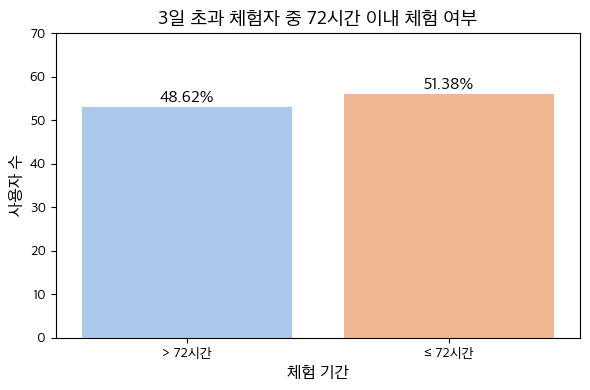

In [41]:
# 1. True / False ÎπÑÏú® Í≥ÑÏÇ∞
within_counts = result_df['within_72_hours'].value_counts().sort_index()
within_percent = (within_counts / within_counts.sum() * 100).round(2)

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=within_percent.index.map({False: '> 72ÏãúÍ∞Ñ', True: '‚â§ 72ÏãúÍ∞Ñ'}),
                 y=within_counts.values, palette='pastel')

# 3. ÌÖçÏä§Ìä∏ ÎπÑÏú® ÌëúÏãú
for i, (count, percent) in enumerate(zip(within_counts.values, within_percent.values)):
    plt.text(i, count + 1, f'{percent:.2f}%', ha='center', fontsize=12)

# 4. Íæ∏ÎØ∏Í∏∞
plt.ylim(0, within_counts.max() * 1.25)
plt.title('3Ïùº Ï¥àÍ≥º Ï≤¥ÌóòÏûê Ï§ë 72ÏãúÍ∞Ñ Ïù¥ÎÇ¥ Ï≤¥Ìóò Ïó¨Î∂Ä', fontsize=14)
plt.xlabel('Ï≤¥Ìóò Í∏∞Í∞Ñ', fontsize=12)
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=12)
plt.tight_layout()
plt.show()

- 72ÏãúÍ∞Ñ Ïù¥ÎÇ¥Ïóê Î∞úÏÉùÌïòÏßÄ ÏïäÏùÄ 4ÏùºÏß∏ Î∞©Î¨∏ÎèÑ Îã§Ïàò ÌôïÏù∏ÎêòÏñ¥, "3Ïùº Ï≤¥Ìóò"Ïùò Í∏∞Ï§ÄÏù¥ 72ÏãúÍ∞ÑÏù¥ÎùºÎäî Í∑ºÍ±∞Îäî Ï∞æÏùÑ Ïàò ÏóÜÏóàÏäµÎãàÎã§.
- 4ÏùºÏß∏ Î∞©Î¨∏ÏùÄ Ï†ÑÌôòÏûêÎì§Ïóê Íµ≠ÌïúÎêú ÌñâÎèôÌå®ÌÑ¥(Í≤∞Ï†ú Ïù¥ÌõÑ Ï≤¥Ìóò Ïπ¥Îìú ÏûÑÏãú ÏÇ¨Ïö©)Ïùº Ïàò ÏûàÏúºÎØÄÎ°ú, Ï†ÑÌôò Ïó¨Î∂ÄÏóê Îî∞Îùº Îã§Ïãú Í≤ÄÌÜ†Ìï©ÎãàÎã§.

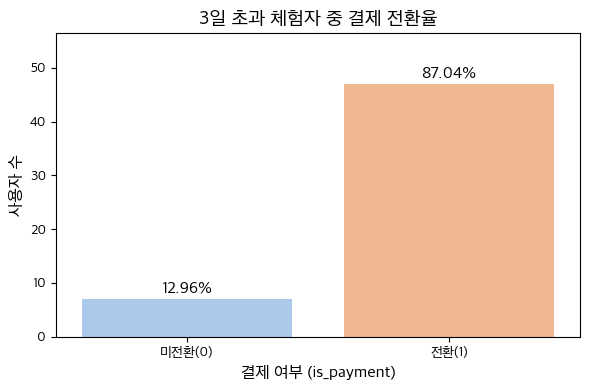

In [42]:
# 1. Í≤∞Ï†ú Ïó¨Î∂Ä Î≥ëÌï©
result_df = result_df.merge(trial_payment, on='user_uuid', how='left')

# 2. 3Ïùº Ï¥àÍ≥º Ï≤¥ÌóòÏûêÎßå ÌïÑÌÑ∞ÎßÅ
over_3days = result_df[result_df['within_72_hours'] == False]

# 3. Ï†ÑÌôò Ïó¨Î∂ÄÎ≥Ñ ÏÇ¨Ïö©Ïûê Ïàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
conversion_counts = over_3days['is_payment'].value_counts().sort_index()
conversion_percent = (conversion_counts / conversion_counts.sum() * 100).round(2)

# 4. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
sns.barplot(x=conversion_percent.index.map({0: 'ÎØ∏Ï†ÑÌôò(0)', 1: 'Ï†ÑÌôò(1)'}),
            y=conversion_counts.values,
            palette='pastel')

# 5. ÌçºÏÑºÌä∏ ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
for i, (count, percent) in enumerate(zip(conversion_counts.values, conversion_percent.values)):
    plt.text(i, count + 1, f'{percent:.2f}%', ha='center', fontsize=12)

# 6. Íæ∏ÎØ∏Í∏∞
plt.ylim(0, conversion_counts.max() * 1.2)
plt.title('3Ïùº Ï¥àÍ≥º Ï≤¥ÌóòÏûê Ï§ë Í≤∞Ï†ú Ï†ÑÌôòÏú®', fontsize=14)
plt.xlabel('Í≤∞Ï†ú Ïó¨Î∂Ä (is_payment)', fontsize=12)
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=12)
plt.tight_layout()
plt.show()

- 4Ïùº Î∞©Î¨∏Ìïú Ïú†Ï†Ä Ï§ëÏóêÎäî ÎØ∏Ï†ÑÌôò Ïú†Ï†ÄÎèÑ 11.67% ÏûàÎäî Í≤ÉÏù¥ ÌôïÏù∏ÎêòÏóàÏäµÎãàÎã§.

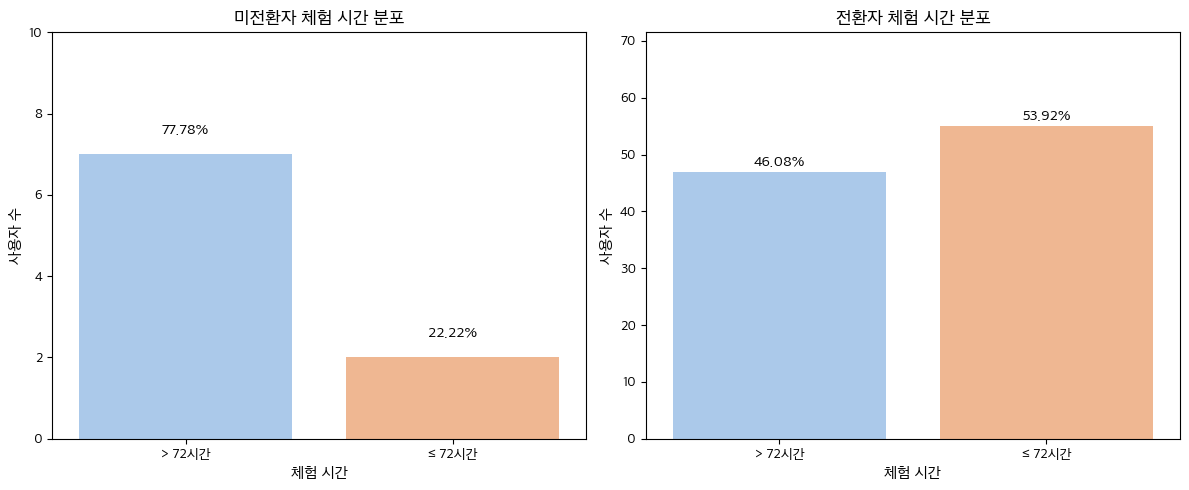

In [43]:
# 1. Ï†ÑÌôò Ïó¨Î∂ÄÏóê Îî∞Îùº Î∂ÑÎ¶¨
non_converted = result_df[result_df['is_payment'] == 0]
converted = result_df[result_df['is_payment'] == 1]

# 2. Í∑∏Î£πÎ≥Ñ ÎπÑÏú® Í≥ÑÏÇ∞
non_conv_counts = non_converted['within_72_hours'].value_counts().sort_index()
non_conv_percent = (non_conv_counts / non_conv_counts.sum() * 100).round(2)

conv_counts = converted['within_72_hours'].value_counts().sort_index()
conv_percent = (conv_counts / conv_counts.sum() * 100).round(2)

# 3. ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 3-1. ÎØ∏Ï†ÑÌôòÏûê
sns.barplot(
    x=non_conv_percent.index.map({False: '> 72ÏãúÍ∞Ñ', True: '‚â§ 72ÏãúÍ∞Ñ'}),
    y=non_conv_counts.values,
    palette='pastel',
    ax=axes[0]
)
for i, (count, percent) in enumerate(zip(non_conv_counts.values, non_conv_percent.values)):
    axes[0].text(i, count + 0.5, f'{percent:.2f}%', ha='center', fontsize=11)

axes[0].set_title('ÎØ∏Ï†ÑÌôòÏûê Ï≤¥Ìóò ÏãúÍ∞Ñ Î∂ÑÌè¨', fontsize=13)
axes[0].set_xlabel('Ï≤¥Ìóò ÏãúÍ∞Ñ', fontsize=11)
axes[0].set_ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=11)
axes[0].set_ylim(0, 10)  # yÏ∂ï Î≤îÏúÑ Ï†úÌïú

# 3-2. Ï†ÑÌôòÏûê
sns.barplot(
    x=conv_percent.index.map({False: '> 72ÏãúÍ∞Ñ', True: '‚â§ 72ÏãúÍ∞Ñ'}),
    y=conv_counts.values,
    palette='pastel',
    ax=axes[1]
)
for i, (count, percent) in enumerate(zip(conv_counts.values, conv_percent.values)):
    axes[1].text(i, count + 1, f'{percent:.2f}%', ha='center', fontsize=11)

axes[1].set_title('Ï†ÑÌôòÏûê Ï≤¥Ìóò ÏãúÍ∞Ñ Î∂ÑÌè¨', fontsize=13)
axes[1].set_xlabel('Ï≤¥Ìóò ÏãúÍ∞Ñ', fontsize=11)
axes[1].set_ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=11)
axes[1].set_ylim(0, conv_counts.max() * 1.3)

plt.tight_layout()
plt.show()

- ÏµúÏ¥à ÏûÖÏû• ÌõÑ 72ÏãúÍ∞ÑÏù¥ ÏßÄÎÇòÍ≥† 4ÏùºÏß∏ Î∞©Î¨∏Ïù¥ Î∞úÏÉùÌïú ÎπÑÏú®ÏùÄ ÎØ∏Ï†ÑÌôòÏûê Ï™ΩÏù¥ Îçî ÎÜíÏïòÏäµÎãàÎã§.
- `trial_access_log`ÏóêÎäî 4Ïùº Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞Í∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäîÎã§Îäî Í≤ÉÏùÄ, "3Ïùº Ï≤¥Ìóò Í∏∞Í∞Ñ"ÏùÄ Î∂ÑÎ™Ö Ï†ÑÏÇ∞ÏÉÅÏúºÎ°ú ÏóÑÍ≤©Ìûà Í¥ÄÎ¶¨ÎêòÍ≥† ÏûàÎäî Í≤ÉÏúºÎ°ú Î≥¥Ïù¥ÎäîÎç∞, `trial_visit_info`Ïóê Ïñ¥Ïß∏ÏÑú 4ÏùºÏß∏ Î∞©Î¨∏ Í∏∞Î°ùÏù¥ ÎÇ®ÏïÑ ÏûàÍ≥†, 4ÏùºÏß∏ Î∞©Î¨∏Ïù¥ ÌóàÏö©ÎêòÏóàÎäîÏßÄÎäî ÌåêÎã®ÌïòÍ∏∞ Ïñ¥Î†µÏäµÎãàÎã§.
- ÎπÑÏ†ïÏÉÅ Ïù¥Ïö© Í∏∞Î°ùÏù¥ÎùºÍ≥† ÌåêÎã®, 4ÏùºÏß∏ Í∏∞Î°ùÏùÄ Ï†úÍ±∞Ìï©ÎãàÎã§.

In [44]:
# ÏßÄÏö∞Í∏∞ Ï†Ñ Îç∞Ïù¥ÌÑ∞
trial_visit_info.shape

(9476, 5)

In [45]:
# 1. ÎÇ†Ïßú Ïª¨ÎüºÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥† dateÎßå Ï∂îÏ∂ú
trial_visit_info['first_enter_time'] = pd.to_datetime(trial_visit_info['first_enter_time'])
trial_visit_info['visit_date'] = trial_visit_info['first_enter_time'].dt.date

# 2. ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï≤´ Î∞©Î¨∏ ÎÇ†Ïßú Í≥ÑÏÇ∞
first_visit_date = trial_visit_info.groupby('user_uuid')['visit_date'].min().rename('start_date')

# 3. Î≥ëÌï©ÌïòÏó¨ ÎÇ†Ïßú Ï∞®Ïù¥ Í≥ÑÏÇ∞
trial_visit_info = trial_visit_info.merge(first_visit_date, on='user_uuid', how='left')
trial_visit_info['day_diff'] = (trial_visit_info['visit_date'] - trial_visit_info['start_date']).apply(lambda x: x.days)

# ‚úÖ [1Îã®Í≥Ñ] 3Ïùº Ïù¥ÌõÑ(day_diff > 2) Î∞©Î¨∏ Ï§ë ÌïòÎ£®Ïóê 2Ìöå Ïù¥ÏÉÅ Î∞©Î¨∏Ìïú ÏÇ¨Ïö©ÏûêÎßå Ï∂úÎ†•
over3day = trial_visit_info[trial_visit_info['day_diff'] > 2]
duplicated_users = over3day['user_uuid'].value_counts()
duplicated_users = duplicated_users[duplicated_users > 1].index
duplicated_records = over3day[over3day['user_uuid'].isin(duplicated_users)]

# Ï∂úÎ†•
display(duplicated_records)

# ‚úÖ [2Îã®Í≥Ñ] Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú 3Ïùº Ïù¥ÌõÑ Î∞©Î¨∏ Í∏∞Î°ù Ï†úÍ±∞ (Ï¶â, day_diff > 2 Ï†úÍ±∞)
trial_visit_info = trial_visit_info[trial_visit_info['day_diff'] <= 2].reset_index(drop=True)

# Ï†ïÎ¶¨
trial_visit_info = trial_visit_info.drop(columns=['visit_date', 'start_date', 'day_diff'])

date           first_enter_time            last_leave_time  \
1457 2023-04-06 2023-04-06 07:06:24.880463 2023-04-06 11:59:55.164340   
1460 2023-04-06 2023-04-06 14:03:28.685090 2023-04-06 14:38:11.659703   
1655 2023-11-11 2023-11-11 18:41:16.628998 2023-11-11 22:26:14.548792   
1656 2023-11-11 2023-11-11 13:23:23.266460 2023-11-11 17:03:16.464729   
2002 2023-12-14 2023-12-14 19:41:49.902190 2023-12-14 21:00:36.422923   
2003 2023-12-14 2023-12-14 19:41:49.902190 2023-12-14 21:00:36.422923   
2131 2023-04-28 2023-04-28 14:22:35.321988 2023-04-28 15:21:38.742446   
2132 2023-04-28 2023-04-28 15:51:59.184069 2023-04-28 17:01:10.009861   
2133 2023-04-28 2023-04-28 10:36:08.508621 2023-04-28 12:01:41.229520   

                                 user_uuid  stay_time_hour  visit_date  \
1457  3c793cb0-a6d1-42a2-89fb-2553a19f5ae8               5  2023-04-06   
1460  3c793cb0-a6d1-42a2-89fb-2553a19f5ae8               1  2023-04-06   
1655  5f07d159-1aa3-4666-a013-d51aefcbbc79               4  2023-11-11   
1656  5f07d159-1aa3-4666-a013-d51aefcbbc79               3  2023-11-11   
2002  02458b10-7f2b-4030-950b-ba650ce2fb49               1  2023-12-14   
2003  02458b10-7f2b-4030-950b-ba650ce2fb49               1  2023-12-14   
2131  6986a5ec-b02b-43e9-a722-be8cebc85c1a               1  2023-04-28   
2132  6986a5ec-b02b-43e9-a722-be8cebc85c1a               1  2023-04-28   
2133  6986a5ec-b02b-43e9-a722-be8cebc85c1a               1  2023-04-28   

      start_date  day_diff  
1457  2023-04-03         3  
1460  2023-04-03         3  
1655  2023-11-08         3  
1656  2023-11-08         3  
2002  2023-12-11         3  
2003  2023-12-11         3  
2131  2023-04-25         3  
2132  2023-04-25         3  
2133  2023-04-25         3

In [46]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
trial_visit_info.shape

(9362, 5)

- 109Î™ÖÏùò 4ÏùºÏß∏ Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ 114Í±¥Ïù¥ ÏßÄÏõåÏ°åÏäµÎãàÎã§. (4ÏùºÏß∏Ïóê 2Ìöå Î∞©Î¨∏ Ïú†Ï†Ä 3Î™Ö, 3Ìöå Î∞©Î¨∏ Ïú†Ï†Ä 1Î™Ö Ï°¥Ïû¨)

### 1.3.4 Î∞©Î¨∏Í∏∞Î°ùÍ≥º Ï∂úÏûÖÍ∏∞Î°ùÏùò Î∂àÏùºÏπò

In [47]:
# 1. Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
access_log = trial_access_log.copy()
visit_info = trial_visit_info.copy()

# 2. cdate ‚Üí datetime Î≥ÄÌôò Î∞è ÎÇ†Ïßú Ï∂îÏ∂ú
access_log['cdate'] = pd.to_datetime(access_log['cdate'])
access_log['date'] = access_log['cdate'].dt.date

# 3. checkin == 1 ‚Üí ÏµúÏ¥à ÏûÖÏû• ÏãúÍ∞Å
first_checkin = access_log[access_log['checkin'] == 1] \
    .groupby(['user_uuid', 'date'])['cdate'].min().reset_index()
first_checkin.columns = ['user_uuid', 'date', 'first_checkin_time']

# 4. checkin == 2 ‚Üí ÎßàÏßÄÎßâ Ìá¥Ïû• ÏãúÍ∞Å
last_checkout = access_log[access_log['checkin'] == 2] \
    .groupby(['user_uuid', 'date'])['cdate'].max().reset_index()
last_checkout.columns = ['user_uuid', 'date', 'last_checkout_time']

# 5. visit_infoÏùò ÎÇ†Ïßú Ï†ïÏ†ú
visit_info['date'] = pd.to_datetime(visit_info['date']).dt.date

# 6. Î≥ëÌï©
merged = visit_info.merge(first_checkin, on=['user_uuid', 'date'], how='left') \
                   .merge(last_checkout, on=['user_uuid', 'date'], how='left')

# 7. ÏãúÍ∞Å ÎπÑÍµê (Î∂Ñ Îã®ÏúÑÍπåÏßÄÎßå ÎπÑÍµê)
merged['first_enter_match'] = pd.to_datetime(merged['first_enter_time']).dt.floor('min') == \
                              pd.to_datetime(merged['first_checkin_time']).dt.floor('min')

merged['last_leave_match'] = pd.to_datetime(merged['last_leave_time']).dt.floor('min') == \
                             pd.to_datetime(merged['last_checkout_time']).dt.floor('min')

# 8. Í≤∞Í≥º ÌôïÏù∏
comparison_result = merged[[
    'user_uuid', 'date',
    'first_enter_time', 'first_checkin_time', 'first_enter_match',
    'last_leave_time', 'last_checkout_time', 'last_leave_match'
]]

comparison_result.head()

user_uuid        date  \
0  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-23   
1  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-24   
2  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-25   
3  ba49324f-d317-4053-adf9-2b17b3f07594  2023-12-23   
4  ba49324f-d317-4053-adf9-2b17b3f07594  2023-12-25   

            first_enter_time         first_checkin_time  first_enter_match  \
0 2023-12-23 16:11:25.345793 2023-12-23 16:11:25.888624               True   
1 2023-12-24 16:10:45.668026 2023-12-24 16:10:46.214942               True   
2 2023-12-25 10:19:47.087268 2023-12-25 10:19:47.690764               True   
3 2023-12-23 14:49:40.302823 2023-12-23 14:49:40.844597               True   
4 2023-12-25 14:38:26.896366 2023-12-25 14:38:27.480359               True   

             last_leave_time         last_checkout_time  last_leave_match  
0 2023-12-23 17:25:32.233995 2023-12-23 17:25:32.797735              True  
1 2023-12-24 20:53:34.842447 2023-12-24 20:53:35.456099              True  
2 2023-12-25 12:39:51.221372 2023-12-25 12:39:51.728980              True  
3 2023-12-23 19:27:39.406803 2023-12-23 19:27:40.007304              True  
4 2023-12-25 20:29:58.172946 2023-12-25 20:29:58.740380              True

In [48]:
# first_enter_match ÎòêÎäî last_leave_matchÍ∞Ä FalseÏù∏ ÌñâÎßå ÌïÑÌÑ∞ÎßÅ
mismatched_rows = comparison_result[
    (comparison_result['first_enter_match'] == False) |
    (comparison_result['last_leave_match'] == False)
]

# Í≤∞Í≥º ÌôïÏù∏
display(mismatched_rows)

user_uuid        date  \
31    34d68334-ee08-4a87-8879-9320746a52d9  2023-12-25   
45    963a0a40-9499-4e30-a321-9feda7c6221f  2023-12-29   
54    3fb96714-db4d-4896-b821-df6fc1d93fe5  2024-01-01   
58    418edd26-c1c1-49f6-b67f-3b29c3e868e9  2024-01-02   
87    6861f386-6914-4ba2-b6b2-ffc88f5cc661  2023-12-24   
...                                    ...         ...   
9346  d7013b60-95fd-472a-9283-3196e93f6ea6  2022-06-13   
9351  ee19e504-ed45-47c1-9901-281194d77df2  2022-09-07   
9352  1575d09e-c799-4529-9115-e2ae9ae46b0d  2023-01-09   
9357  766221e7-a753-444f-aa5a-ae76ce86d3fd  2022-06-18   
9361  576473bb-0647-483e-b06a-a5ff6491b08b  2023-02-06   

               first_enter_time         first_checkin_time  first_enter_match  \
31   2023-12-25 20:00:56.885960 2023-12-25 20:08:49.612802              False   
45   2023-12-29 11:38:59.540143 2023-12-29 11:39:00.061821              False   
54   2024-01-01 17:52:32.264924                        NaT              False   
58   2024-01-02 19:37:50.345305                        NaT              False   
87   2023-12-24 16:42:28.354497 2023-12-24 16:42:28.900005               True   
...                         ...                        ...                ...   
9346 2022-06-13 20:35:33.912555                        NaT              False   
9351 2022-09-07 11:05:45.614091 2022-09-07 11:05:46.206550               True   
9352 2023-01-09 10:41:47.670501                        NaT              False   
9357 2022-06-18 15:14:52.844471                        NaT              False   
9361 2023-02-06 10:14:00.538281                        NaT              False   

                last_leave_time         last_checkout_time  last_leave_match  
31   2023-12-25 22:24:14.133274 2023-12-25 22:24:14.637381              True  
45   2023-12-29 21:08:45.247783 2023-12-29 21:08:45.789435              True  
54   2024-01-01 18:50:14.547251                        NaT             False  
58   2024-01-02 20:20:08.337566                        NaT             False  
87   2023-12-24 18:34:59.491755 2023-12-24 18:35:00.020432             False  
...                         ...                        ...               ...  
9346 2022-06-13 23:18:04.461268                        NaT             False  
9351 2022-09-07 18:42:59.950126 2022-09-07 18:43:01.573279             False  
9352 2023-01-09 17:29:13.887330                        NaT             False  
9357 2022-06-18 17:51:56.463097                        NaT             False  
9361 2023-02-06 16:52:37.606175                        NaT             False  

[2188 rows x 8 columns]

In [49]:
# 1. Ï†ÑÏ≤¥ ÏùºÏπòÏú® Í≥ÑÏÇ∞
first_enter_accuracy = comparison_result['first_enter_match'].mean() * 100
last_leave_accuracy = comparison_result['last_leave_match'].mean() * 100

# 2. ÎèôÏãúÏóê Îëò Îã§ ÏùºÏπòÌïú ÎπÑÏú®
both_match_accuracy = (
    (comparison_result['first_enter_match'] & comparison_result['last_leave_match']).mean() * 100
)

# 3. ÏöîÏïΩ Ï∂úÎ†•
print("‚úÖ ÏûÖÏû• ÏãúÍ∞Å ÏùºÏπòÏú®: {:.2f}%".format(first_enter_accuracy))
print("‚úÖ Ìá¥Ïû• ÏãúÍ∞Å ÏùºÏπòÏú®: {:.2f}%".format(last_leave_accuracy))
print("‚úÖ ÏûÖÏû•¬∑Ìá¥Ïû• Î™®Îëê ÏùºÏπòÌïú ÎπÑÏú®: {:.2f}%".format(both_match_accuracy))

‚úÖ ÏûÖÏû• ÏãúÍ∞Å ÏùºÏπòÏú®: 78.30%
‚úÖ Ìá¥Ïû• ÏãúÍ∞Å ÏùºÏπòÏú®: 78.43%
‚úÖ ÏûÖÏû•¬∑Ìá¥Ïû• Î™®Îëê ÏùºÏπòÌïú ÎπÑÏú®: 76.63%


- Í∏∞Ï§ÄÏùÑ ÏôÑÌôîÌïòÏó¨, ÏµúÏ¥àÏûÖÏã§/ÏµúÏ¢ÖÌá¥Ïã§ ÏãúÍ∞ÑÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ¬±1Î∂ÑÏùò Ï≤¥ÌÅ¨Ïù∏/Ï≤¥ÌÅ¨ÏïÑÏõÉ Í∏∞Î°ùÍ≥º ÎπÑÍµêÌï©ÎãàÎã§.

In [50]:
# 1. Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
access_log = trial_access_log.copy()
visit_info = trial_visit_info.copy()

# 2. datetime Ï≤òÎ¶¨ Î∞è ÎÇ†Ïßú Ïª¨Îüº ÏÉùÏÑ±
access_log['cdate'] = pd.to_datetime(access_log['cdate'])
access_log['date'] = access_log['cdate'].dt.date
visit_info['date'] = pd.to_datetime(visit_info['date']).dt.date
visit_info['first_enter_time'] = pd.to_datetime(visit_info['first_enter_time'])
visit_info['last_leave_time'] = pd.to_datetime(visit_info['last_leave_time'])

# 3. ÏûÖÏû• / Ìá¥Ïû• Í∏∞Î°ù Î∂ÑÎ¶¨
all_checkin = access_log[access_log['checkin'] == 1][['user_uuid', 'cdate']].copy()
all_checkout = access_log[access_log['checkin'] == 2][['user_uuid', 'cdate']].copy()

# 4. ¬±1Î∂Ñ Ïù¥ÎÇ¥ ÏùºÏπò Ïó¨Î∂Ä ÌåêÎã® Ìï®Ïàò (Î™ÖÌôïÌûà Í∏∞Ï§Ä Ïª¨Îüº Ï†ÑÎã¨)
def is_within_1min(row, df, df_col, ref_col):
    user_times = df[df['user_uuid'] == row['user_uuid']][df_col]
    if user_times.empty:
        return False
    return ((user_times - row[ref_col]).abs() <= pd.Timedelta(minutes=1)).any()

# 5. match Ïó¨Î∂Ä Ï†ÅÏö©
visit_info['first_enter_match'] = visit_info.apply(
    lambda row: is_within_1min(row, all_checkin, 'cdate', 'first_enter_time'),
    axis=1
)

visit_info['last_leave_match'] = visit_info.apply(
    lambda row: is_within_1min(row, all_checkout, 'cdate', 'last_leave_time'),
    axis=1
)

# 6. Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ïã§Ï†ú ÏãúÍ∞Å Î≥¥Ï†ï Ìï®Ïàò
def get_closest_time(row, df, time_col, ref_col):
    user_times = df[df['user_uuid'] == row['user_uuid']][time_col]
    if user_times.empty:
        return pd.NaT
    return user_times.iloc[(user_times - row[ref_col]).abs().argsort().iloc[0]]

# 7. Ïã§Ï†ú ÏãúÍ∞Å Î≥¥Ï†ï Ï†ÅÏö©
visit_info['first_checkin_time'] = visit_info.apply(
    lambda row: row['first_enter_time'] if row['first_enter_match']
    else get_closest_time(row, all_checkin, 'cdate', 'first_enter_time'),
    axis=1
)

visit_info['last_checkout_time'] = visit_info.apply(
    lambda row: row['last_leave_time'] if row['last_leave_match']
    else get_closest_time(row, all_checkout, 'cdate', 'last_leave_time'),
    axis=1
)

# 8. ÏµúÏ¢Ö ÎπÑÍµê Í≤∞Í≥º Ï∂úÎ†•
comparison_result = visit_info[[
    'user_uuid', 'date',
    'first_enter_time', 'first_checkin_time', 'first_enter_match',
    'last_leave_time', 'last_checkout_time', 'last_leave_match'
]]

# Í≤∞Í≥º ÌôïÏù∏
display(comparison_result.head())

user_uuid        date  \
0  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-23   
1  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-24   
2  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-25   
3  ba49324f-d317-4053-adf9-2b17b3f07594  2023-12-23   
4  ba49324f-d317-4053-adf9-2b17b3f07594  2023-12-25   

            first_enter_time         first_checkin_time  first_enter_match  \
0 2023-12-23 16:11:25.345793 2023-12-23 16:11:25.345793               True   
1 2023-12-24 16:10:45.668026 2023-12-24 16:10:45.668026               True   
2 2023-12-25 10:19:47.087268 2023-12-25 10:19:47.087268               True   
3 2023-12-23 14:49:40.302823 2023-12-23 14:49:40.302823               True   
4 2023-12-25 14:38:26.896366 2023-12-25 14:38:26.896366               True   

             last_leave_time         last_checkout_time  last_leave_match  
0 2023-12-23 17:25:32.233995 2023-12-23 17:25:32.233995              True  
1 2023-12-24 20:53:34.842447 2023-12-24 20:53:34.842447              True  
2 2023-12-25 12:39:51.221372 2023-12-25 12:39:51.221372              True  
3 2023-12-23 19:27:39.406803 2023-12-23 19:27:39.406803              True  
4 2023-12-25 20:29:58.172946 2023-12-25 20:29:58.172946              True

In [51]:
# first_enter_match ÎòêÎäî last_leave_matchÍ∞Ä FalseÏù∏ ÌñâÎßå ÌïÑÌÑ∞ÎßÅ
mismatched_rows = comparison_result[
    (comparison_result['first_enter_match'] == False) |
    (comparison_result['last_leave_match'] == False)
]

# Í≤∞Í≥º ÌôïÏù∏
display(mismatched_rows)

user_uuid        date  \
31    34d68334-ee08-4a87-8879-9320746a52d9  2023-12-25   
54    3fb96714-db4d-4896-b821-df6fc1d93fe5  2024-01-01   
58    418edd26-c1c1-49f6-b67f-3b29c3e868e9  2024-01-02   
146   2e2c6d0c-ccf3-4435-b2cf-1ac75479a061  2023-09-30   
150   15153a7c-4970-48f5-9dc8-1cde314675b7  2022-12-04   
...                                    ...         ...   
9344  f86f20a3-025f-49fc-87c4-86a9e15970af  2022-12-11   
9346  d7013b60-95fd-472a-9283-3196e93f6ea6  2022-06-13   
9352  1575d09e-c799-4529-9115-e2ae9ae46b0d  2023-01-09   
9357  766221e7-a753-444f-aa5a-ae76ce86d3fd  2022-06-18   
9361  576473bb-0647-483e-b06a-a5ff6491b08b  2023-02-06   

               first_enter_time         first_checkin_time  first_enter_match  \
31   2023-12-25 20:00:56.885960 2023-12-25 20:08:49.612802              False   
54   2024-01-01 17:52:32.264924 2023-12-31 23:24:59.867903              False   
58   2024-01-02 19:37:50.345305 2024-01-01 20:35:59.136586              False   
146  2023-09-30 13:39:41.656267 2023-09-28 17:56:26.091999              False   
150  2022-12-04 11:22:25.399420 2022-12-03 20:14:33.019689              False   
...                         ...                        ...                ...   
9344 2022-12-11 15:07:30.451559                        NaT              False   
9346 2022-06-13 20:35:33.912555 2022-06-12 20:32:38.412596              False   
9352 2023-01-09 10:41:47.670501                        NaT              False   
9357 2022-06-18 15:14:52.844471 2022-06-16 16:56:19.458810              False   
9361 2023-02-06 10:14:00.538281                        NaT              False   

                last_leave_time         last_checkout_time  last_leave_match  
31   2023-12-25 22:24:14.133274 2023-12-25 22:24:14.133274              True  
54   2024-01-01 18:50:14.547251 2023-12-31 23:25:56.774039             False  
58   2024-01-02 20:20:08.337566 2024-01-01 21:37:41.055419             False  
146  2023-09-30 19:10:22.443106 2023-09-28 18:31:38.884372             False  
150  2022-12-04 17:07:31.021784 2022-12-03 20:45:07.842010             False  
...                         ...                        ...               ...  
9344 2022-12-11 16:10:09.161349                        NaT             False  
9346 2022-06-13 23:18:04.461268 2022-06-12 23:33:25.859776             False  
9352 2023-01-09 17:29:13.887330                        NaT             False  
9357 2022-06-18 17:51:56.463097 2022-06-16 18:23:38.959007             False  
9361 2023-02-06 16:52:37.606175                        NaT             False  

[1925 rows x 8 columns]

In [52]:
# 1. Ï†ÑÏ≤¥ ÏùºÏπòÏú® Í≥ÑÏÇ∞
first_enter_accuracy = comparison_result['first_enter_match'].mean() * 100
last_leave_accuracy = comparison_result['last_leave_match'].mean() * 100

# 2. ÏûÖÏû•¬∑Ìá¥Ïû• Î™®Îëê ÏùºÏπòÌïú ÎπÑÏú®
both_match_accuracy = (
    (comparison_result['first_enter_match'] & comparison_result['last_leave_match']).mean() * 100
)

# 3. ÏöîÏïΩ Ï∂úÎ†•
print("‚úÖ ÏûÖÏû• ÏãúÍ∞Å ÏùºÏπòÏú®: {:.2f}%".format(first_enter_accuracy))
print("‚úÖ Ìá¥Ïû• ÏãúÍ∞Å ÏùºÏπòÏú®: {:.2f}%".format(last_leave_accuracy))
print("‚úÖ ÏûÖÏû•¬∑Ìá¥Ïû• Î™®Îëê ÏùºÏπòÌïú ÎπÑÏú®: {:.2f}%".format(both_match_accuracy))

‚úÖ ÏûÖÏû• ÏãúÍ∞Å ÏùºÏπòÏú®: 79.76%
‚úÖ Ìá¥Ïû• ÏãúÍ∞Å ÏùºÏπòÏú®: 79.90%
‚úÖ ÏûÖÏû•¬∑Ìá¥Ïû• Î™®Îëê ÏùºÏπòÌïú ÎπÑÏú®: 79.44%


- ÏïΩ 80%Îäî ÏùºÏπòÌïòÏßÄÎßå, `trial_access_log`Ïóê ÎàÑÎùΩÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä Îã§Ïàò ÌôïÏù∏Îê©ÎãàÎã§.
- Ìå®ÌÑ¥Ïù¥ Î≥¥Ïù¥ÏßÄ ÏïäÍ≥†, ÏµúÏ¥à ÏûÖÏã§/ÏµúÏ¢Ö Ìá¥Ïã§ Í∏∞Î°ùÏùÑ Ïã†Î¢∞ÌïòÏßÄ ÏïäÏùÑ Ïù¥Ïú†Í∞Ä ÏóÜÍ∏∞ ÎïåÎ¨∏Ïóê, `trial_access_log`Ïóê ÎàÑÎùΩÎêú Î°úÍ∑∏Î•º ÏóÖÎç∞Ïù¥Ìä∏Ìï©ÎãàÎã§.

In [53]:
# 1. mismatched_rows Ï†ïÏùò
mismatched_rows = comparison_result[
    ~comparison_result['first_enter_match'] | ~comparison_result['last_leave_match']
].copy()

# 2. Ï≤¥ÌÅ¨Ïù∏ Î°úÍ∑∏ (first_enter_match == False Ïù∏ Í≤ΩÏö∞Îßå)
checkin_add = mismatched_rows[~mismatched_rows['first_enter_match']][['user_uuid', 'first_enter_time']].copy()
checkin_add['checkin'] = 1
checkin_add = checkin_add.rename(columns={'first_enter_time': 'cdate'})

# 3. Ï≤¥ÌÅ¨ÏïÑÏõÉ Î°úÍ∑∏ (last_leave_match == False Ïù∏ Í≤ΩÏö∞Îßå)
checkout_add = mismatched_rows[~mismatched_rows['last_leave_match']][['user_uuid', 'last_leave_time']].copy()
checkout_add['checkin'] = 2
checkout_add = checkout_add.rename(columns={'last_leave_time': 'cdate'})

# 4. Î≥ëÌï©
trial_access_log = pd.concat(
    [trial_access_log, checkin_add, checkout_add],
    ignore_index=True
).sort_values(by=['user_uuid', 'cdate']).reset_index(drop=True)

In [54]:
# 1. Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
access_log = trial_access_log.copy()
visit_info = trial_visit_info.copy()

# 2. datetime Ï≤òÎ¶¨ Î∞è ÎÇ†Ïßú Ïª¨Îüº ÏÉùÏÑ±
access_log['cdate'] = pd.to_datetime(access_log['cdate'])
access_log['date'] = access_log['cdate'].dt.date
visit_info['date'] = pd.to_datetime(visit_info['date']).dt.date
visit_info['first_enter_time'] = pd.to_datetime(visit_info['first_enter_time'])
visit_info['last_leave_time'] = pd.to_datetime(visit_info['last_leave_time'])

# 3. ÏûÖÏû• / Ìá¥Ïû• Í∏∞Î°ù Î∂ÑÎ¶¨
all_checkin = access_log[access_log['checkin'] == 1][['user_uuid', 'cdate']].copy()
all_checkout = access_log[access_log['checkin'] == 2][['user_uuid', 'cdate']].copy()

# 4. ¬±1Î∂Ñ Ïù¥ÎÇ¥ ÏùºÏπò Ïó¨Î∂Ä ÌåêÎã® Ìï®Ïàò (Î™ÖÌôïÌûà Í∏∞Ï§Ä Ïª¨Îüº Ï†ÑÎã¨)
def is_within_1min(row, df, df_col, ref_col):
    user_times = df[df['user_uuid'] == row['user_uuid']][df_col]
    if user_times.empty:
        return False
    return ((user_times - row[ref_col]).abs() <= pd.Timedelta(minutes=1)).any()

# 5. match Ïó¨Î∂Ä Ï†ÅÏö©
visit_info['first_enter_match'] = visit_info.apply(
    lambda row: is_within_1min(row, all_checkin, 'cdate', 'first_enter_time'),
    axis=1
)

visit_info['last_leave_match'] = visit_info.apply(
    lambda row: is_within_1min(row, all_checkout, 'cdate', 'last_leave_time'),
    axis=1
)

# 6. Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ïã§Ï†ú ÏãúÍ∞Å Î≥¥Ï†ï Ìï®Ïàò
def get_closest_time(row, df, time_col, ref_col):
    user_times = df[df['user_uuid'] == row['user_uuid']][time_col]
    if user_times.empty:
        return pd.NaT
    return user_times.iloc[(user_times - row[ref_col]).abs().argsort().iloc[0]]

# 7. Ïã§Ï†ú ÏãúÍ∞Å Î≥¥Ï†ï Ï†ÅÏö©
visit_info['first_checkin_time'] = visit_info.apply(
    lambda row: row['first_enter_time'] if row['first_enter_match']
    else get_closest_time(row, all_checkin, 'cdate', 'first_enter_time'),
    axis=1
)

visit_info['last_checkout_time'] = visit_info.apply(
    lambda row: row['last_leave_time'] if row['last_leave_match']
    else get_closest_time(row, all_checkout, 'cdate', 'last_leave_time'),
    axis=1
)

# 8. ÏµúÏ¢Ö ÎπÑÍµê Í≤∞Í≥º Ï∂úÎ†•
comparison_result = visit_info[[
    'user_uuid', 'date',
    'first_enter_time', 'first_checkin_time', 'first_enter_match',
    'last_leave_time', 'last_checkout_time', 'last_leave_match'
]]

# Í≤∞Í≥º ÌôïÏù∏
display(comparison_result.head())

user_uuid        date  \
0  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-23   
1  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-24   
2  939fc566-61cd-47f0-a3ce-e2936fdcff73  2023-12-25   
3  ba49324f-d317-4053-adf9-2b17b3f07594  2023-12-23   
4  ba49324f-d317-4053-adf9-2b17b3f07594  2023-12-25   

            first_enter_time         first_checkin_time  first_enter_match  \
0 2023-12-23 16:11:25.345793 2023-12-23 16:11:25.345793               True   
1 2023-12-24 16:10:45.668026 2023-12-24 16:10:45.668026               True   
2 2023-12-25 10:19:47.087268 2023-12-25 10:19:47.087268               True   
3 2023-12-23 14:49:40.302823 2023-12-23 14:49:40.302823               True   
4 2023-12-25 14:38:26.896366 2023-12-25 14:38:26.896366               True   

             last_leave_time         last_checkout_time  last_leave_match  
0 2023-12-23 17:25:32.233995 2023-12-23 17:25:32.233995              True  
1 2023-12-24 20:53:34.842447 2023-12-24 20:53:34.842447              True  
2 2023-12-25 12:39:51.221372 2023-12-25 12:39:51.221372              True  
3 2023-12-23 19:27:39.406803 2023-12-23 19:27:39.406803              True  
4 2023-12-25 20:29:58.172946 2023-12-25 20:29:58.172946              True

In [55]:
# 1. Ï†ÑÏ≤¥ ÏùºÏπòÏú® Í≥ÑÏÇ∞
first_enter_accuracy = comparison_result['first_enter_match'].mean() * 100
last_leave_accuracy = comparison_result['last_leave_match'].mean() * 100

# 2. ÏûÖÏû•¬∑Ìá¥Ïû• Î™®Îëê ÏùºÏπòÌïú ÎπÑÏú®
both_match_accuracy = (
    (comparison_result['first_enter_match'] & comparison_result['last_leave_match']).mean() * 100
)

# 3. ÏöîÏïΩ Ï∂úÎ†•
print("‚úÖ ÏûÖÏû• ÏãúÍ∞Å ÏùºÏπòÏú®: {:.2f}%".format(first_enter_accuracy))
print("‚úÖ Ìá¥Ïû• ÏãúÍ∞Å ÏùºÏπòÏú®: {:.2f}%".format(last_leave_accuracy))
print("‚úÖ ÏûÖÏû•¬∑Ìá¥Ïû• Î™®Îëê ÏùºÏπòÌïú ÎπÑÏú®: {:.2f}%".format(both_match_accuracy))

‚úÖ ÏûÖÏû• ÏãúÍ∞Å ÏùºÏπòÏú®: 100.00%
‚úÖ Ìá¥Ïû• ÏãúÍ∞Å ÏùºÏπòÏú®: 100.00%
‚úÖ ÏûÖÏû•¬∑Ìá¥Ïû• Î™®Îëê ÏùºÏπòÌïú ÎπÑÏú®: 100.00%


In [56]:
# Í∞Å ÌÖåÏù¥Î∏îÏùò Í≥†Ïú† ÏÇ¨Ïö©Ïûê ID ÏßëÌï© Ï∂îÏ∂ú
uids_access = set(trial_access_log['user_uuid'].unique())
uids_visit = set(trial_visit_info['user_uuid'].unique())

# Í∞ÅÍ∞ÅÏóêÎßå Ï°¥Ïû¨ÌïòÎäî ÏÇ¨Ïö©Ïûê ÏßëÌï©
only_in_access = uids_access - uids_visit
only_in_visit = uids_visit - uids_access

# Í≤∞Í≥º Ï∂úÎ†•
print(f"‚úÖ trial_access_logÏóêÎßå ÏûàÎäî Í≥†Ïú† ÏÇ¨Ïö©Ïûê Ïàò: {len(only_in_access)}")
print(f"‚úÖ trial_visit_infoÏóêÎßå ÏûàÎäî Í≥†Ïú† ÏÇ¨Ïö©Ïûê Ïàò: {len(only_in_visit)}")

‚úÖ trial_access_logÏóêÎßå ÏûàÎäî Í≥†Ïú† ÏÇ¨Ïö©Ïûê Ïàò: 704
‚úÖ trial_visit_infoÏóêÎßå ÏûàÎäî Í≥†Ïú† ÏÇ¨Ïö©Ïûê Ïàò: 0


- `trial_access_log`ÏóêÎßå ÏûàÎäî ÏÇ¨Ïö©ÏûêÎäî ÏÑ∏ÏÖò Íµ¨Î∂ÑÏù¥ Ïñ¥Î†µÍ∏∞ ÎïåÎ¨∏Ïóê Ï†úÏô∏Ìï©ÎãàÎã§.
- Ïã§Ï†úÎ°ú `trial_visit_info`Ïóê Í∏∞Î°ùÎêú Ïú†Ï†Ä Ï§ë ÏïΩ 20%Îäî, ÏµúÏ¥àÏûÖÏã§/ÏµúÏ¢ÖÌá¥Ïã§ ÏãúÍ∞ÅÏù¥ `trial_access_log`Ïóê ÎàÑÎùΩÎêòÏñ¥ ÏûàÏóàÏäµÎãàÎã§.
- Îî∞ÎùºÏÑú `trial_access_log`Ïùò Î∂àÏôÑÏ†ÑÌïú Ï†ïÎ≥¥ÎßåÏúºÎ°ú ÏÑ∏ÏÖòÏùÑ Íµ¨ÏÑ±Ìï¥ `trial_visit_info`Ïóê Î∞òÏòÅÌïòÎäî Í≤ÉÏùÄ Ïã†Î¢∞ÌïòÍ∏∞ Ïñ¥Î†µÏäµÎãàÎã§.
- ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú `user_uuid`Îäî `trial_visit_info`Ïóê Ï°¥Ïû¨ÌïòÎäî ÏÇ¨Ïö©ÏûêÎßå ÏÇ¨Ïö©ÌïòÎ©∞, `trial_access_log`ÏóêÎßå ÏûàÎäî ÏÇ¨Ïö©ÏûêÎäî Î∂ÑÏÑù ÎåÄÏÉÅÏóêÏÑú Ï†úÏô∏Ìï©ÎãàÎã§.

## 1.4 ÌÜµÌï© `user` Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±

In [57]:
# 0. Ï†ïÏÉÅ Î∞©Î¨∏Ïûê Ï†ïÏùò
valid_visits = trial_visit_info.dropna(subset=['stay_time_hour', 'first_enter_time', 'date'])

# 1. Î∞©Î¨∏Ïûê Ï§ë Îì±Î°ùÏûê ÌïÑÌÑ∞ÎßÅ
visited_users = valid_visits['user_uuid'].unique()
user = trial_register[trial_register['user_uuid'].isin(visited_users)].copy()

# 2. Í≤∞Ï†ú Ï†ïÎ≥¥ Î≥ëÌï©
user = user.merge(trial_payment, on='user_uuid', how='left')
user['is_payment'] = user['is_payment'].fillna(0).astype(int)

# 3. ÎÇ†Ïßú Ï†ïÎ¶¨
user['trial_date'] = pd.to_datetime(user['trial_date'])

# 4. first_visit, last_visit (Ï¥à Îã®ÏúÑÍπåÏßÄ)
first_visit = valid_visits.groupby('user_uuid')['first_enter_time'].min().rename('first_visit')
last_visit = valid_visits.groupby('user_uuid')['last_leave_time'].max().rename('last_visit')

# 5. visit_delay_days Í≥ÑÏÇ∞
visit_delay_days = (first_visit - user.set_index('user_uuid')['trial_date']).dt.days.rename('visit_delay_days')

# 6. days Í≥ÑÏÇ∞
days = valid_visits.groupby('user_uuid')['date'].nunique().rename('days')

# 7. total_checkins
total_logs = trial_access_log.groupby('user_uuid').size()
total_checkins = (total_logs / 2).round().astype('int64').rename('total_checkins')

# 8. stay_time_hour
stay_time_hour = valid_visits.groupby('user_uuid')['stay_time_hour'].sum().round().astype('int64').rename('stay_time_hour')

# 9. Î≥ëÌï©
user = user.merge(first_visit.reset_index(), on='user_uuid', how='left')
user = user.merge(last_visit.reset_index(), on='user_uuid', how='left')
user = user.merge(total_checkins.reset_index(), on='user_uuid', how='left')
user = user.merge(stay_time_hour.reset_index(), on='user_uuid', how='left')
user = user.merge(days.reset_index(), on='user_uuid', how='left')
user = user.merge(visit_delay_days.reset_index(), on='user_uuid', how='left')

# 10. ÎÇ†Ïßú/ÏãúÍ∞Ñ Ìè¨Îß∑ Ï†ïÎ¶¨ (Ï¥àÍπåÏßÄÎßå ÎÇ®Í∏∞Í∏∞)
user['first_visit'] = pd.to_datetime(user['first_visit']).dt.floor('s')
user['last_visit'] = pd.to_datetime(user['last_visit']).dt.floor('s')

# 11. ÌïÑÏöî ÏóÜÎäî Ïª¨Îüº Ï†úÍ±∞ (Ïù¥ÎØ∏ trial_dateÍ∞Ä ÏûàÏúºÎØÄÎ°ú register_date ÏóÜÏùå)
# Ïª¨Îüº ÏàúÏÑú Ïû¨Ï†ïÎ†¨
user = user[[
    'user_uuid', 'first_visit', 'last_visit',
    'total_checkins', 'stay_time_hour', 'days',
    'is_payment', 'trial_date', 'visit_delay_days'
]]

# 12. Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ Ï†ïÎ¶¨
float_cols = user.select_dtypes(include='Float64').columns
user[float_cols] = user[float_cols].astype('float64')

int32_cols = user.select_dtypes(include='int32').columns
user[int32_cols] = user[int32_cols].astype('int64')

int64_cols = user.select_dtypes(include='Int64').columns
user[int64_cols] = user[int64_cols].astype('int64')

In [58]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
user.head()

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   
2  2ba8ab19-2d40-4423-ad04-f0f9ca814871 2023-12-21 21:31:16   
3  1d49ba36-6c23-405b-9514-aa7f4aeceff0 2023-12-21 21:16:39   
4  b2d80cf6-2ced-4270-9d7a-43119bba35d2 2023-12-22 15:37:55   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   
2 2023-12-21 22:50:51               2               1     1           0   
3 2023-12-21 22:50:56               2               1     1           0   
4 2023-12-22 17:59:12               2               2     1           0   

  trial_date  visit_delay_days  
0 2023-12-21                 0  
1 2023-12-21                 0  
2 2023-12-21                 0  
3 2023-12-21                 0  
4 2023-12-22                 0

In [59]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_uuid         6169 non-null   object        
 1   first_visit       6169 non-null   datetime64[ns]
 2   last_visit        6169 non-null   datetime64[ns]
 3   total_checkins    6169 non-null   int64         
 4   stay_time_hour    6169 non-null   int64         
 5   days              6169 non-null   int64         
 6   is_payment        6169 non-null   int64         
 7   trial_date        6169 non-null   datetime64[ns]
 8   visit_delay_days  6169 non-null   int64         
dtypes: datetime64[ns](3), int64(5), object(1)
memory usage: 433.9+ KB


In [60]:
user.to_csv('user.csv', index=False)

In [61]:
user = pd.read_csv('user.csv', parse_dates=['first_visit', 'last_visit', 'trial_date'])

# 2. EDA

In [62]:
# Ï†ÑÎ∞òÏ†ÅÏù∏ EDAÎäî df Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú ÏàòÌñâ
df = user.copy()

## 2.1 Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨ ÌôïÏù∏

In [63]:
df.head(5)

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   
2  2ba8ab19-2d40-4423-ad04-f0f9ca814871 2023-12-21 21:31:16   
3  1d49ba36-6c23-405b-9514-aa7f4aeceff0 2023-12-21 21:16:39   
4  b2d80cf6-2ced-4270-9d7a-43119bba35d2 2023-12-22 15:37:55   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   
2 2023-12-21 22:50:51               2               1     1           0   
3 2023-12-21 22:50:56               2               1     1           0   
4 2023-12-22 17:59:12               2               2     1           0   

  trial_date  visit_delay_days  
0 2023-12-21                 0  
1 2023-12-21                 0  
2 2023-12-21                 0  
3 2023-12-21                 0  
4 2023-12-22                 0

### 2.1.1 Í≤∞Ï†ú Ïó¨Î∂Ä Î∂ÑÌè¨

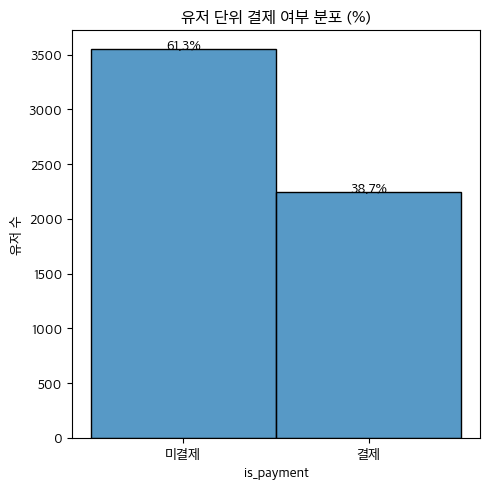

In [64]:
# Ïú†Ï†Ä Îã®ÏúÑÎ°ú Ï§ëÎ≥µ Ï†úÍ±∞
user_df = df.drop_duplicates(subset='user_uuid')

# Ïú†Ï†Ä Í∏∞Ï§Ä Í≤∞Ï†ú Ïó¨Î∂Ä ÎπÑÏú® Í≥ÑÏÇ∞
value_counts = user_df['is_payment'].value_counts(normalize=True).sort_index()
percentages = (value_counts * 100).round(1)

# ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=user_df, x='is_payment', bins=2, discrete=True, ax=ax)

# ÌçºÏÑºÌä∏ ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
for i, pct in enumerate(percentages):
    ax.text(i, user_df['is_payment'].value_counts().sort_index()[i] + 5,
            f'{pct}%', ha='center', fontsize=10, color='black')

ax.set_xticks([0, 1])
ax.set_xticklabels(['ÎØ∏Í≤∞Ï†ú', 'Í≤∞Ï†ú'])
ax.set_ylabel('Ïú†Ï†Ä Ïàò')
ax.set_title('Ïú†Ï†Ä Îã®ÏúÑ Í≤∞Ï†ú Ïó¨Î∂Ä Î∂ÑÌè¨ (%)')

plt.tight_layout()
plt.show()

### 2.1.2 Ïù¥Ïö©ÌòïÌÉú Î∂ÑÌè¨ - Ï≤¥ÌÅ¨Ïù∏ ÌöüÏàò, Ï≤¥Î•òÏãúÍ∞Ñ

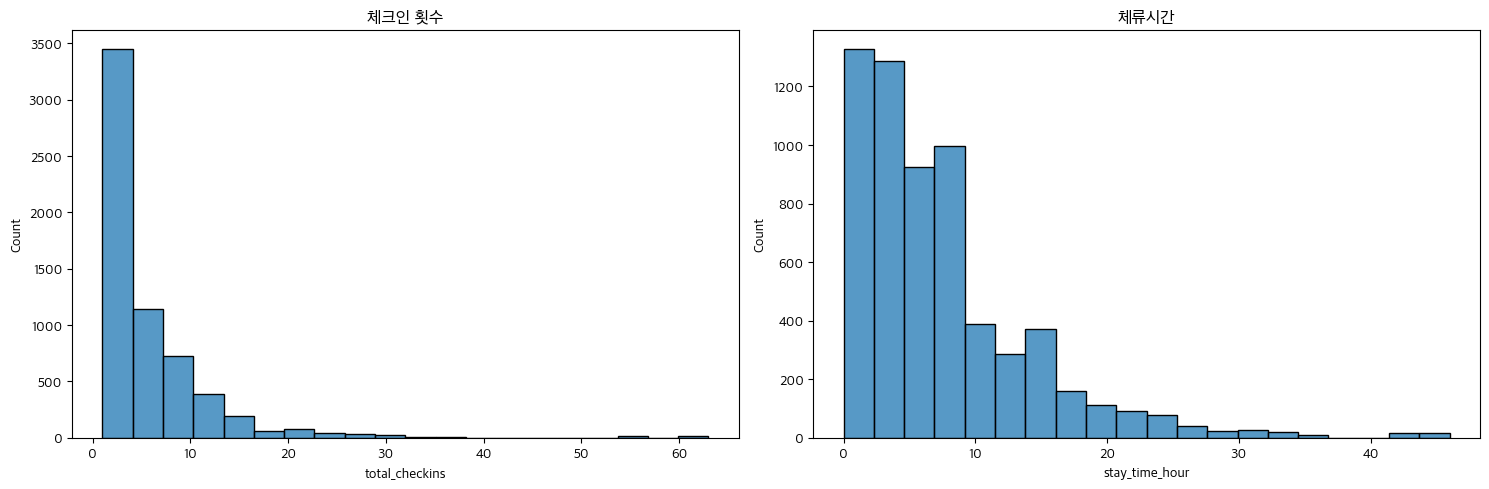

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.histplot(data=df, x='total_checkins', bins=20, ax=ax[0])
ax[0].set_title('Ï≤¥ÌÅ¨Ïù∏ ÌöüÏàò')

sns.histplot(data=df, x='stay_time_hour', bins=20, ax=ax[1])
ax[1].set_title('Ï≤¥Î•òÏãúÍ∞Ñ')
plt.tight_layout()
plt.show()

### 2.1.3 Î∞©Î¨∏ ÏãúÍ∏∞ Î∂ÑÌè¨

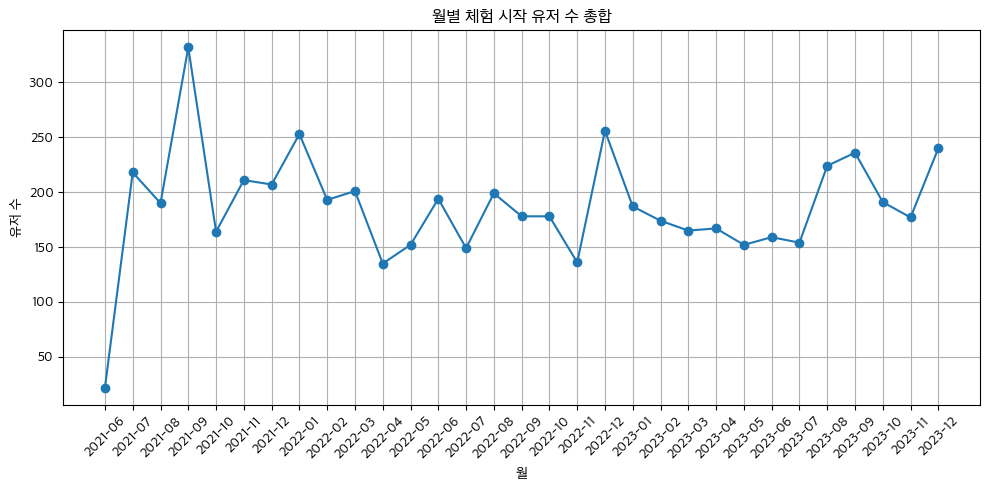

In [66]:
# Ïú†Ï†Ä Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ ÏõîÎ≥Ñ Ï≤¥Ìóò ÏãúÏûë Ïàò Í≥ÑÏÇ∞
monthly_counts = (
    df.drop_duplicates('user_uuid')
      .groupby(df['trial_date'].dt.to_period('M'))
      .size()
      .rename_axis('month')
      .reset_index(name='user_count')
)

# ÏõîÏùÑ Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò
monthly_counts['month'] = monthly_counts['month'].astype(str)

# ÏÑ† Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(10, 5))
plt.plot(monthly_counts['month'], monthly_counts['user_count'], marker='o')
plt.title('ÏõîÎ≥Ñ Ï≤¥Ìóò ÏãúÏûë Ïú†Ï†Ä Ïàò Ï¥ùÌï©')
plt.xlabel('Ïõî')
plt.ylabel('Ïú†Ï†Ä Ïàò')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.2 Ï≤¥ÌóòÏùºÏûêÏóê Îî∞Î•∏ ÏÑ∏Í∑∏Î®ºÌä∏

### 2.2.1 ÏÑ∏Í∑∏Î®ºÌä∏ ÎÇòÎàÑÍ∏∞

In [67]:
def assign_segment(row):
    if row['days'] == 1 and row['is_payment'] == 1:
        return '1Ìöå Ï≤¥Ìóò Ï†ÑÌôò'
    elif row['days'] == 2 and row['is_payment'] == 1:
        return '2Ìöå Ï≤¥Ìóò Ï†ÑÌôò'
    elif row['days'] >= 3 and row['is_payment'] == 1:
        return '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò'
    elif row['days'] == 1 and row['is_payment'] == 0:
        return '1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò'
    elif row['days'] == 2 and row['is_payment'] == 0:
        return '2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò'
    elif row['days'] >= 3 and row['is_payment'] == 0:
        return '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò'
    else:
        return 'Í∏∞ÌÉÄ'

df['segment'] = df.apply(assign_segment, axis=1)

In [68]:
display(df['segment'].value_counts())

segment
1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò       2254
1Ìöå Ï≤¥Ìóò Ï†ÑÌôò        1165
2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò       1013
2Ìöå Ï≤¥Ìóò Ï†ÑÌôò         748
3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò     523
3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò      466
Name: count, dtype: int64

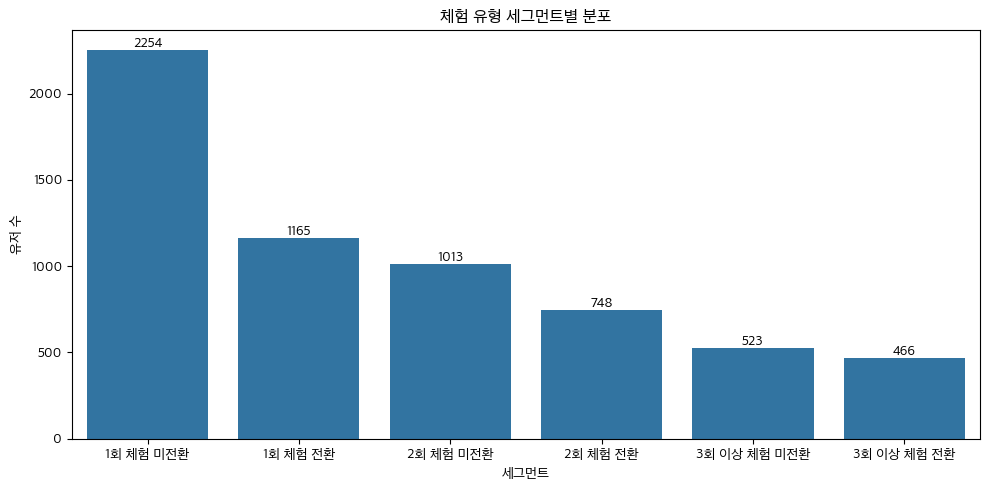

In [69]:
segment_order = [
    '1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '1Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò'
]

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='segment', order=segment_order, ax=ax)

# ÎßâÎåÄ ÏúÑÏóê count Ïàò ÌëúÏãú
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.title('Ï≤¥Ìóò Ïú†Ìòï ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ Î∂ÑÌè¨')
plt.xlabel('ÏÑ∏Í∑∏Î®ºÌä∏')
plt.ylabel('Ïú†Ï†Ä Ïàò')
plt.tight_layout()
plt.show()

In [70]:
# 1Ìöå Ï≤¥Ìóò Ïú†Ï†Ä ÌïÑÌÑ∞ (checkin_count == 1)
one_time = df[df['days'] == 1]
one_time_conversion_rate = one_time['is_payment'].mean()
one_time_user_count = len(one_time)

# 2Ìöå Ï≤¥Ìóò Ïú†Ï†Ä ÌïÑÌÑ∞ (checkin_count == 2)
two_time = df[df['days'] == 2]
two_time_conversion_rate = two_time['is_payment'].mean()
two_time_user_count = len(two_time)

# 3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ïú†Ï†Ä ÌïÑÌÑ∞
multi_time = df[df['days'] >= 3]
multi_time_conversion_rate = multi_time['is_payment'].mean()
multi_time_user_count = len(multi_time)

print(f"1Ìöå Ï≤¥Ìóò Ïú†Ï†Ä Ïàò: {one_time_user_count}, Í≤∞Ï†ú Ï†ÑÌôòÏú®: {one_time_conversion_rate:.2%}")
print(f"2Ìöå Ï≤¥Ìóò Ïú†Ï†Ä Ïàò: {two_time_user_count}, Í≤∞Ï†ú Ï†ÑÌôòÏú®: {two_time_conversion_rate:.2%}")
print(f"3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ïú†Ï†Ä Ïàò: {multi_time_user_count}, Í≤∞Ï†ú Ï†ÑÌôòÏú®: {multi_time_conversion_rate:.2%}")

1Ìöå Ï≤¥Ìóò Ïú†Ï†Ä Ïàò: 3419, Í≤∞Ï†ú Ï†ÑÌôòÏú®: 34.07%
2Ìöå Ï≤¥Ìóò Ïú†Ï†Ä Ïàò: 1761, Í≤∞Ï†ú Ï†ÑÌôòÏú®: 42.48%
3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ïú†Ï†Ä Ïàò: 989, Í≤∞Ï†ú Ï†ÑÌôòÏú®: 47.12%


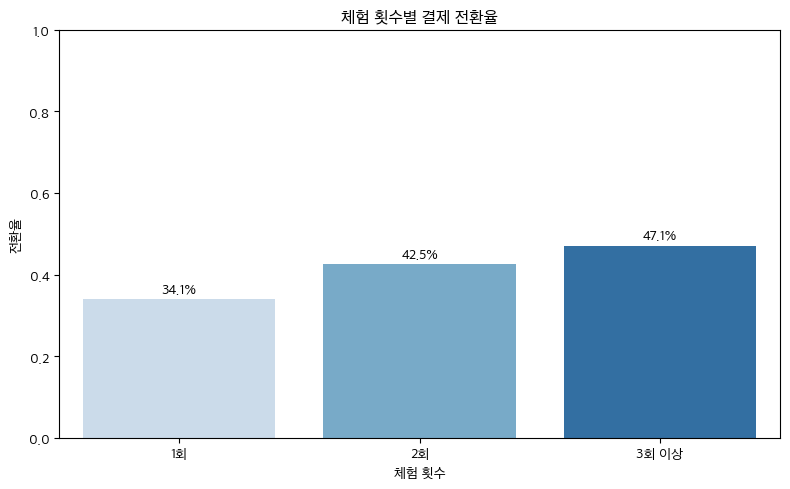

In [71]:
conversion_df = pd.DataFrame({
    'Ï≤¥Ìóò ÌöüÏàò': ['1Ìöå', '2Ìöå', '3Ìöå Ïù¥ÏÉÅ'],
    'Ïú†Ï†Ä Ïàò': [one_time_user_count, two_time_user_count, multi_time_user_count],
    'Ï†ÑÌôòÏú®': [one_time_conversion_rate, two_time_conversion_rate, multi_time_conversion_rate]
})

# ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=conversion_df, x='Ï≤¥Ìóò ÌöüÏàò', y='Ï†ÑÌôòÏú®', palette='Blues', ax=ax)

# Ï†ÑÌôòÏú® ÏàòÏπò ÌëúÏãú
for i, row in conversion_df.iterrows():
    ax.text(i, row['Ï†ÑÌôòÏú®'] + 0.01, f"{row['Ï†ÑÌôòÏú®']:.1%}", ha='center', va='bottom')

plt.title('Ï≤¥Ìóò ÌöüÏàòÎ≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú®')
plt.ylim(0, 1)
plt.ylabel('Ï†ÑÌôòÏú®')
plt.xlabel('Ï≤¥Ìóò ÌöüÏàò')
plt.tight_layout()
plt.show()

- <mark> 1Ïùº Ï≤¥ÌóòÏûêÍ∞Ä Í∞ÄÏû• ÎßéÏßÄÎßå, Í≤∞Ï†úÏ†ÑÌôòÏú®ÏùÄ Ï≤¥ÌóòÏùÑ Îçî ÎßéÏù¥Ìï†ÏàòÎ°ù ÎÜíÏïÑÏßÑÎã§ > 3Ïùº Ï≤¥ÌóòÏùÑ Ïò®Ï†ÑÌûà Îã§ Ìï† Ïàò ÏûàÎèÑÎ°ù Ïú†ÎèÑÌïòÎäî Ïû•ÏπòÍ∞Ä ÌïÑÏöîÌïòÎã§

### 2.2.2 ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ ÌäπÏßï

#### ÏûÖÏã§, Ìá¥Ïã§ ÏãúÍ∞Ñ

In [72]:
# ÏãúÍ∞Ñ Ïª¨ÎüºÏóêÏÑú ÏûÖÏã§/Ìá¥Ïã§ ÏãúÍ∞Å, ÏöîÏùº Ï∂îÏ∂ú
df['enter_hour'] = pd.to_datetime(df['first_visit'], format='mixed', errors='coerce').dt.hour
df['leave_hour'] = pd.to_datetime(df['last_visit'], format='mixed', errors='coerce').dt.hour
df['weekday'] = pd.to_datetime(df['first_visit'], format='mixed', errors='coerce').dt.day_name()

In [73]:
df.head(2)

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   

  trial_date  visit_delay_days    segment  enter_hour  leave_hour   weekday  
0 2023-12-21                 0  1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò           9          16  Thursday  
1 2023-12-21                 0  1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò           4          15  Thursday

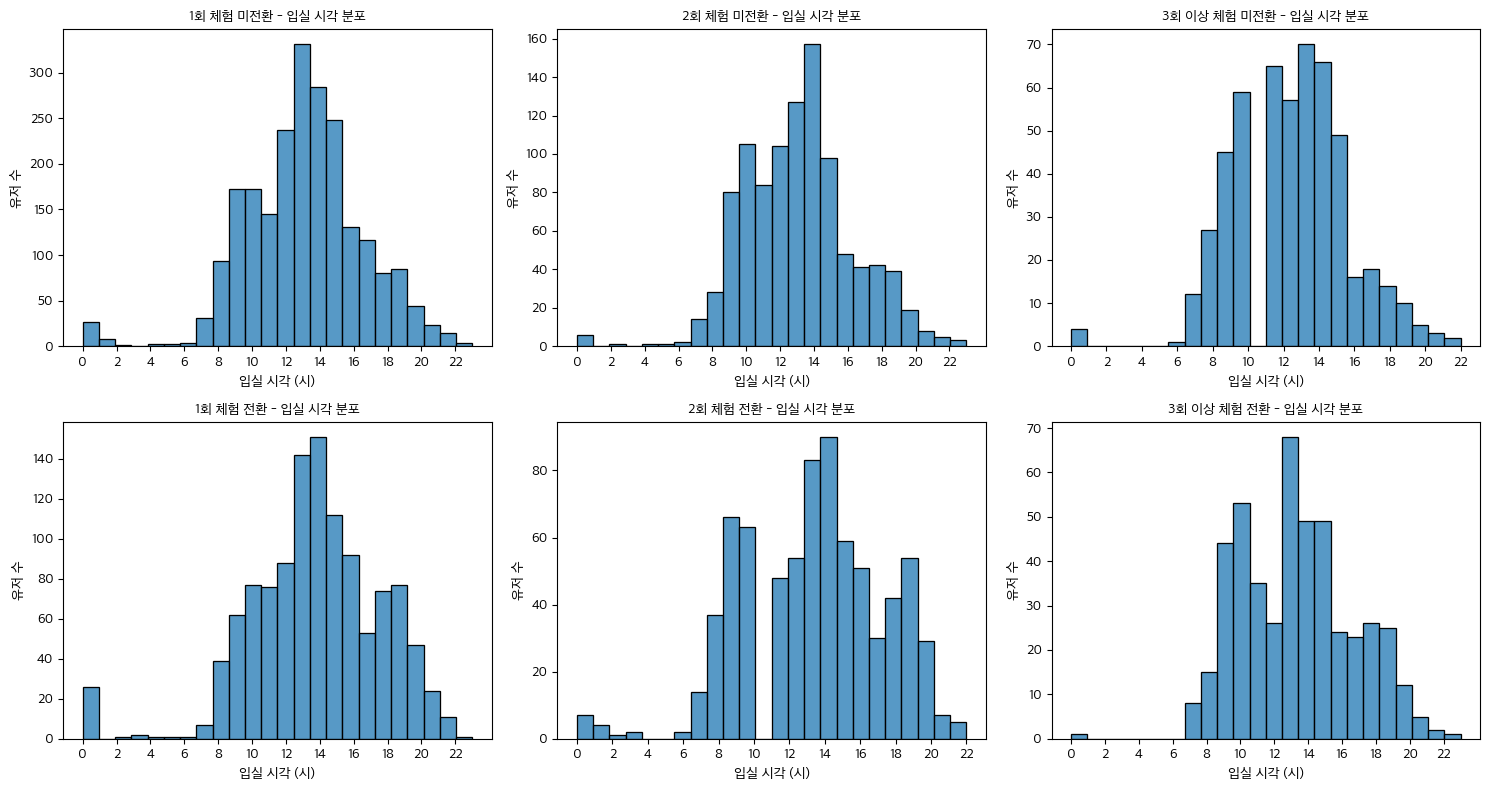

In [74]:
import math

segment_order = [
    '1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '1Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò'
]

# subplot Î∞∞Ïó¥ Íµ¨ÏÑ± (Ïòà: 2Ìñâ 3Ïó¥)
n_segments = len(segment_order)
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

# subplot Î∞∞Ïó¥ Íµ¨ÏÑ± (Ïòà: 2Ìñâ 3Ïó¥)
n_cols = 3
n_rows = math.ceil(n_segments/ n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞ Ï°∞Ï†ï

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.histplot(subset['enter_hour'], bins=24, kde=False)
    plt.title(f'{seg} - ÏûÖÏã§ ÏãúÍ∞Å Î∂ÑÌè¨', fontsize=10)
    plt.xlabel('ÏûÖÏã§ ÏãúÍ∞Å (Ïãú)')
    plt.xticks(range(0, 24, 2))
    plt.ylabel('Ïú†Ï†Ä Ïàò')

plt.tight_layout()
plt.show()

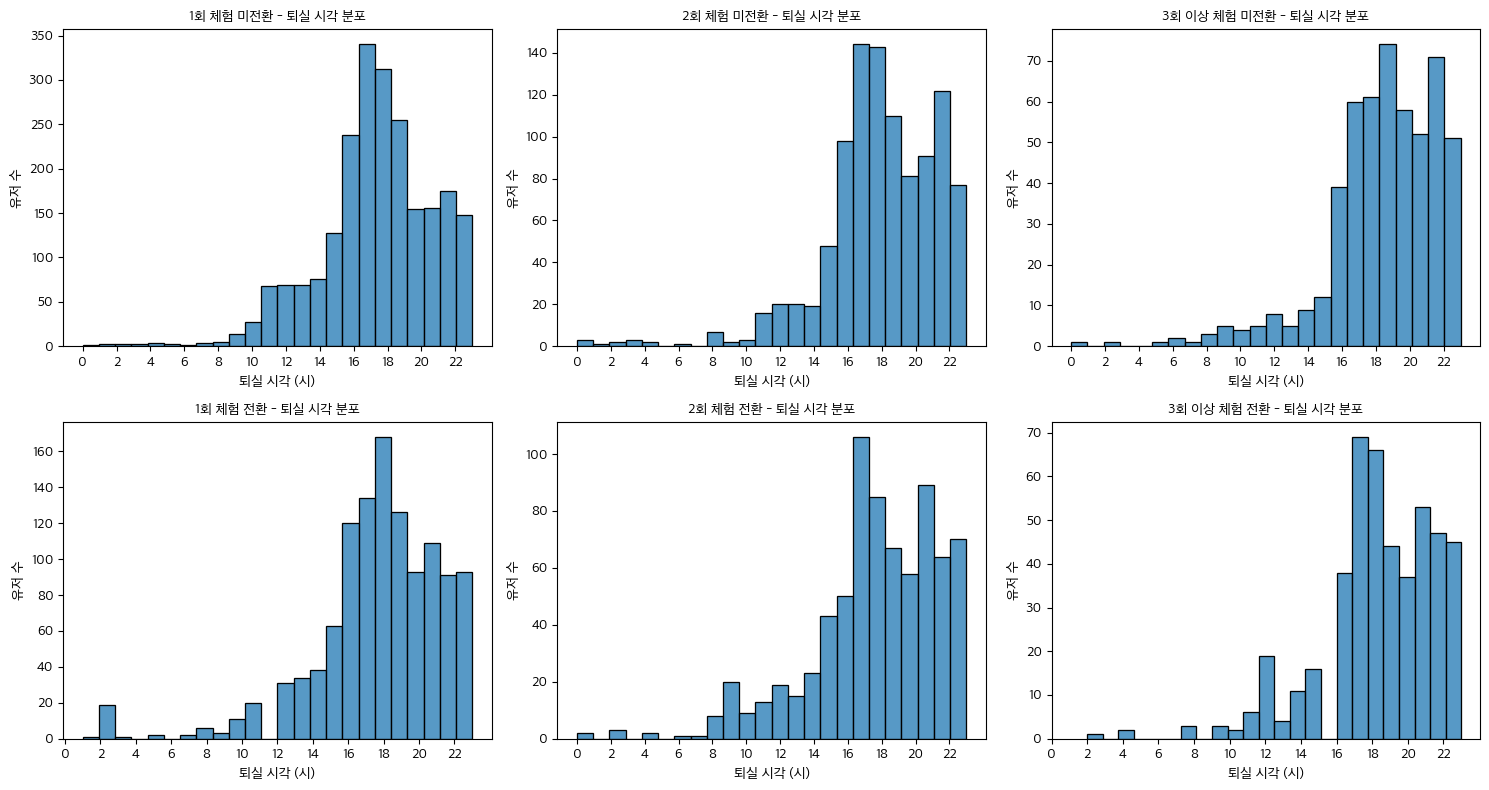

In [75]:
# ÏÑ∏Í∑∏Î®ºÌä∏ ÏãúÍ∞ÅÌôî ÏàúÏÑú Î™ÖÏãú
segment_order = [
    '1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '1Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò'
]


# subplot Î∞∞Ïó¥ Íµ¨ÏÑ± (Ïòà: 2Ìñâ 3Ïó¥)
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

# ÏõêÌïòÎäî subplot Íµ¨ÏÑ±: Ïòà) 3Ïó¥
n_cols = 3
n_rows = math.ceil(n_segments / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞ Ï°∞Ï†ï

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.histplot(subset['leave_hour'], bins=24, kde=False)
    plt.title(f'{seg} - Ìá¥Ïã§ ÏãúÍ∞Å Î∂ÑÌè¨', fontsize=10)
    plt.xlabel('Ìá¥Ïã§ ÏãúÍ∞Å (Ïãú)')
    plt.xticks(range(0, 24, 2))
    plt.ylabel('Ïú†Ï†Ä Ïàò')

plt.tight_layout()
plt.show()

‚úÖ Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Í≥µÌÜµÎêú ÌäπÏßï
- ÏûÖÏã§ ÌîºÌÅ¨ ÌÉÄÏûÑÏùÄ Ïò§Ï†Ñ 11Ïãú~Ïò§ÌõÑ 2Ïãú ÏÇ¨Ïù¥Ïóê ÏßëÏ§ë
- Ìá¥Ïã§ÏãúÍ∞ÑÏùÄ 17Ïãú~20Ïãú ÏÇ¨Ïù¥Ïóê ÏßëÏ§ë

‚úÖ ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ ÌäπÏßï
1. 1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò
    - Í∞ÄÏû• ÎßéÏùÄ Ïú†Ï†Ä Ïàò
    - ÏûÖÏã§ ÏãúÍ∞ÑÏùÄ 12Ïãú~14Ïãú ÏÇ¨Ïù¥ Í∞ÄÏû• ÏßëÏ§ëÏ†Å
    - ÏûÖÏã§ Î∂ÑÌè¨Îäî Ï†ÑÌòïÏ†ÅÏù∏ Ï†êÏã¨ÏãúÍ∞ÑÎåÄÏóê Î™∞Î¶º -> ÏóÖÎ¨¥ Ï§ë Ï≤¥ÌóòÌïú Ïú†Ï†ÄÏùº Í∞ÄÎä•ÏÑ± ÎÜíÏùå

2. 1Ìöå Ï≤¥Ìóò Ï†ÑÌôò
    - ÏûÖÏã§ÏãúÍ∞Ñ Î∂ÑÌè¨Îäî ÎØ∏Ï†ÑÌôòÍ≥º Ïú†ÏÇ¨ÌïòÏßÄÎßå Ï°∞Í∏à Îçî Í∑†ÏùºÌïòÍ≤å ÌçºÏßê
    - 10Ïãú~16Ïãú ÏÇ¨Ïù¥ ÏûÖÏã§ Íæ∏Ï§ÄÌûà Ï°¥Ïû¨Ìï®

3. 2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò
    - 10Ïãú~11Ïãú ÏûÖÏã§Ïù¥ Îã§ÏÜå Ï†ÅÏùå

4. 2Ìöå Ï≤¥Ìóò Ï†ÑÌôò
    - ÏûÖÏã§ ÏãúÍ∞ÑÏù¥ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú Í≥†Î•¥Í≤å Ï°¥Ïû¨

5. 3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò
    - 9Ïãú~ 14Ïãú ÏûÖÏã§ Í≥†Î•¥Í≤å Î∂ÑÌè¨, 17Ïãú~22Ïãú Ìá¥Ïã§ Í≥†Î•¥Í≤å Î∂ÑÌè¨
    - ÏûÖÏã§Í≥º Ìá¥Ïã§Ïù¥ Î™®Îëê Ïú†Ïó∞Ìïú Ìé∏

6. 3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò
    - ÏûÖÏã§ ÏãúÍ∞ÑÏùÄ Ï†ÑÌôòÍµ∞Í≥º ÎπÑÏä∑ÌïòÎÇò, 13Ïãú~15ÏãúÎ°ú Ï°∞Í∏à Îçî Îä¶ÏùÄ ÏãúÍ∞ÅÏóê ÏßëÏ§ë

#### ÌòºÏû°ÎèÑ

In [76]:
# enter_hour Í∏∞Ï§ÄÏúºÎ°ú Î∞©Î¨∏ Ïàò ÎπÑÏú® Í≥ÑÏÇ∞
hourly_congestion = df['enter_hour'].value_counts(normalize=True).sort_index()

# ÏòàÏãú Ï∂úÎ†•
print(hourly_congestion)

enter_hour
0     0.011509
1     0.001945
2     0.000648
3     0.000648
4     0.000648
5     0.000648
6     0.001459
7     0.013941
8     0.038904
9     0.076025
10    0.085751
11    0.073432
12    0.091749
13    0.133085
14    0.129194
15    0.099692
16    0.058680
17    0.045550
18    0.045064
19    0.047009
20    0.025288
21    0.011347
22    0.006484
23    0.001297
Name: proportion, dtype: float64


In [77]:
df['congestion_score'] = df['enter_hour'].map(hourly_congestion)

In [78]:
# Î∂ÑÏúÑÏàò Í∏∞Ï§Ä ÏûÑÍ≥ÑÍ∞í Í≥ÑÏÇ∞
q1 = df['congestion_score'].quantile(1/3)
q2 = df['congestion_score'].quantile(2/3)

# ÌòºÏû°ÎèÑ ÏàòÏ§Ä Îß§Ìïë Ìï®Ïàò
def get_congestion_level(score):
    if score >= q2:
        return 'ÌòºÏû°'
    elif score >= q1:
        return 'Î≥¥ÌÜµ'
    else:
        return 'Ïó¨Ïú†'

df['congestion_level'] = df['congestion_score'].apply(get_congestion_level)

In [79]:
df[['enter_hour', 'congestion_score', 'congestion_level']].head(24)

enter_hour  congestion_score congestion_level
0            9          0.076025               Î≥¥ÌÜµ
1            4          0.000648               Ïó¨Ïú†
2           21          0.011347               Ïó¨Ïú†
3           21          0.011347               Ïó¨Ïú†
4           15          0.099692               ÌòºÏû°
5            9          0.076025               Î≥¥ÌÜµ
6           15          0.099692               ÌòºÏû°
7           20          0.025288               Ïó¨Ïú†
8            9          0.076025               Î≥¥ÌÜµ
9           14          0.129194               ÌòºÏû°
10          16          0.058680               Ïó¨Ïú†
11          15          0.099692               ÌòºÏû°
12          22          0.006484               Ïó¨Ïú†
13          11          0.073432               Î≥¥ÌÜµ
14          15          0.099692               ÌòºÏû°
15          15          0.099692               ÌòºÏû°
16          15          0.099692               ÌòºÏû°
17          15          0.099692               ÌòºÏû°
18          15          0.099692               ÌòºÏû°
19          15          0.099692               ÌòºÏû°
20          15          0.099692               ÌòºÏû°
21          15          0.099692               ÌòºÏû°
22          15          0.099692               ÌòºÏû°
23          15          0.099692               ÌòºÏû°

In [80]:
df['congestion_level'].value_counts()

congestion_level
ÌòºÏû°    2233
Î≥¥ÌÜµ    2017
Ïó¨Ïú†    1919
Name: count, dtype: int64

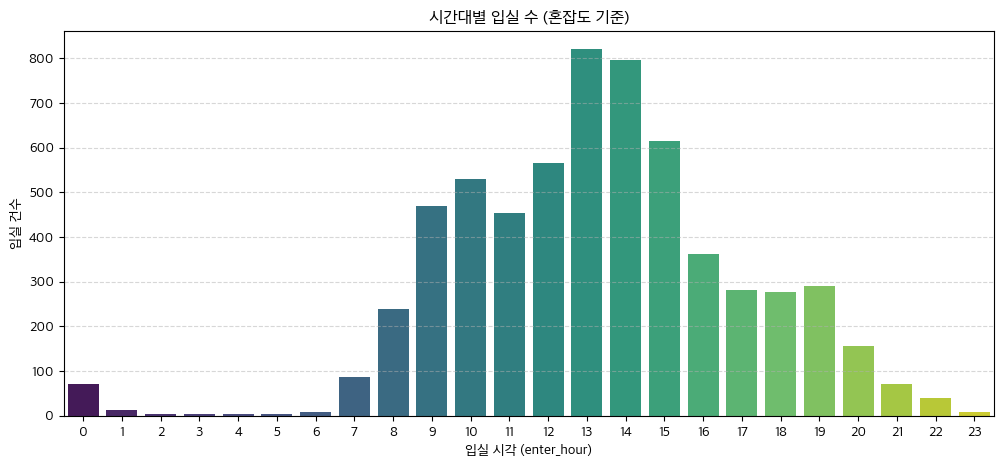

In [81]:
# ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏûÖÏã§ Ïàò Í≥ÑÏÇ∞
hourly_visits = df['enter_hour'].value_counts().sort_index()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 5))
sns.barplot(x=hourly_visits.index, y=hourly_visits.values, palette='viridis')
plt.title('ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏûÖÏã§ Ïàò (ÌòºÏû°ÎèÑ Í∏∞Ï§Ä)')
plt.xlabel('ÏûÖÏã§ ÏãúÍ∞Å (enter_hour)')
plt.ylabel('ÏûÖÏã§ Í±¥Ïàò')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [82]:
top_hours = hourly_visits.sort_values(ascending=False).head(5)
print("Í∞ÄÏû• ÌòºÏû°Ìïú ÏûÖÏã§ ÏãúÍ∞ÑÎåÄ:")
print(top_hours)

Í∞ÄÏû• ÌòºÏû°Ìïú ÏûÖÏã§ ÏãúÍ∞ÑÎåÄ:
enter_hour
13    821
14    797
15    615
12    566
10    529
Name: count, dtype: int64


#### ÏöîÏùº

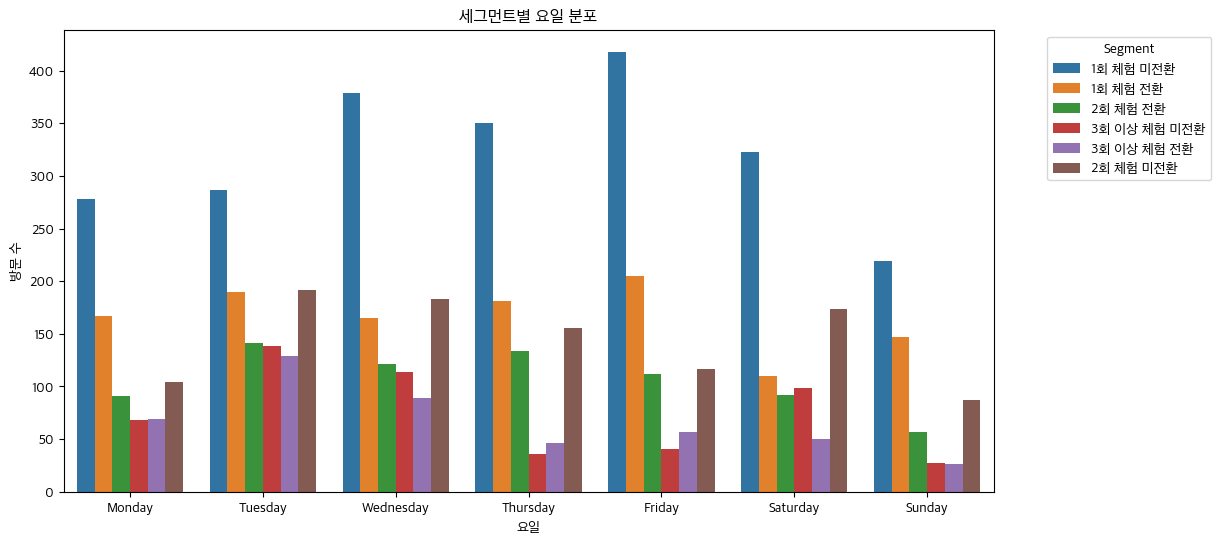

In [83]:
# ÏöîÏùº Ï†ïÎ†¨Ïö© category ÏÑ§Ï†ï
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='weekday', hue='segment')
plt.title('ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ ÏöîÏùº Î∂ÑÌè¨')
plt.xlabel('ÏöîÏùº')
plt.ylabel('Î∞©Î¨∏ Ïàò')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

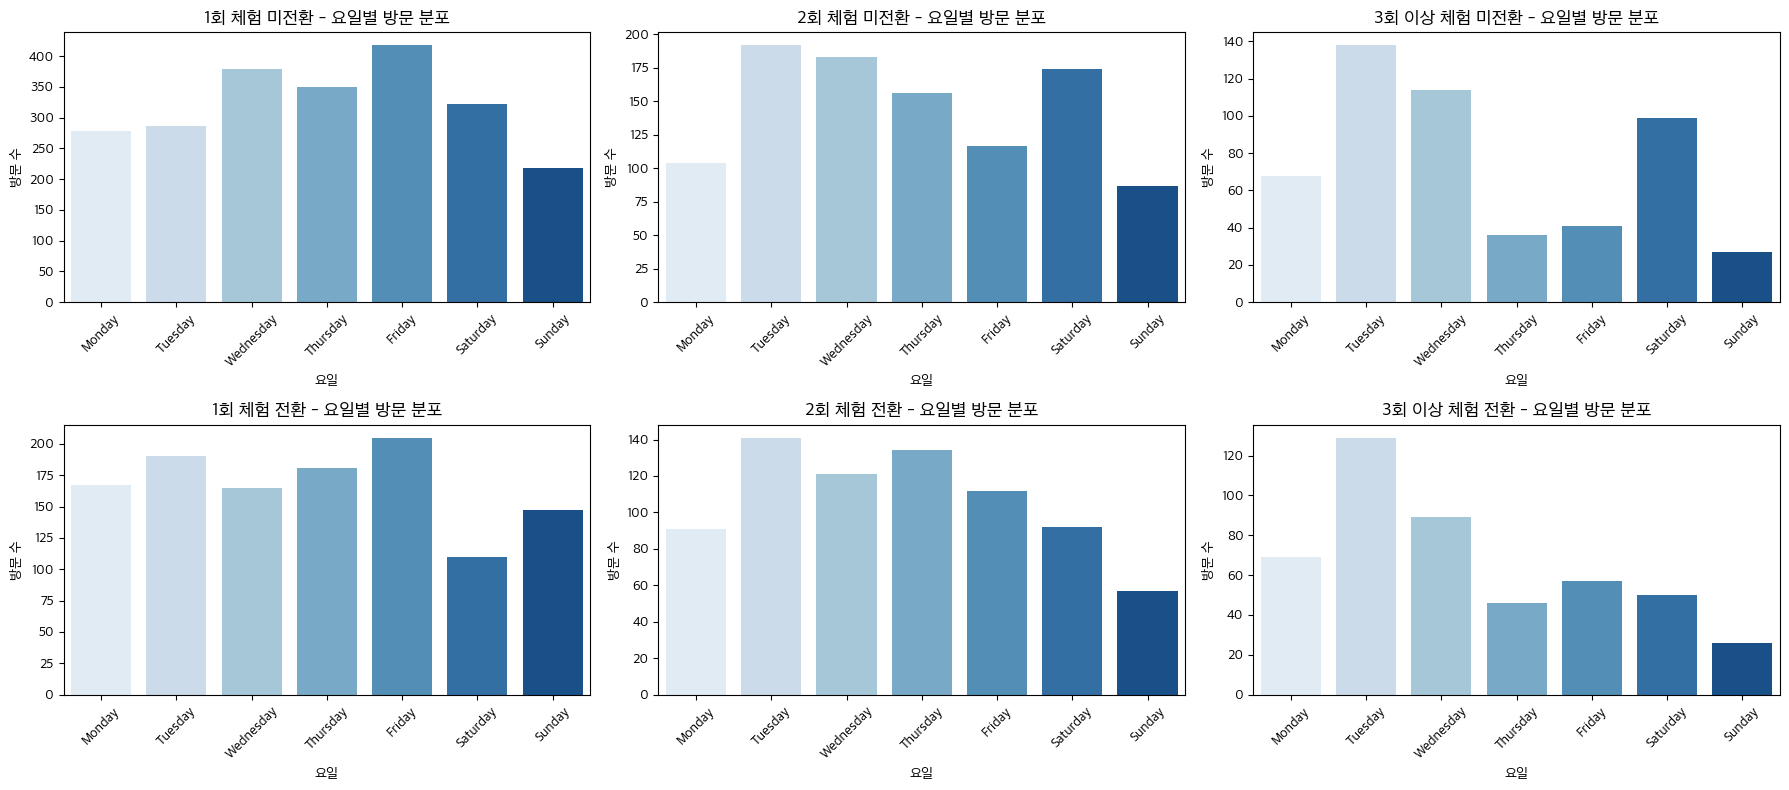

In [84]:
# ÏÑ∏Í∑∏Î®ºÌä∏ ÏãúÍ∞ÅÌôî ÏàúÏÑú
segment_order = [
    '1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '1Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò'
]

# subplot Íµ¨ÏÑ±
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.countplot(
        data=subset,
        x='weekday',
        hue='weekday',
        order=weekday_order,
        palette='Blues',
        legend=False
    )
    plt.title(f'{seg} - ÏöîÏùºÎ≥Ñ Î∞©Î¨∏ Î∂ÑÌè¨', fontsize=13)
    plt.xlabel('ÏöîÏùº')
    plt.ylabel('Î∞©Î¨∏ Ïàò')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1. Ï†ÑÌôò Ïú†Ï†ÄÎäî ÎåÄÎ∂ÄÎ∂Ñ Ìôî ~ Í∏à ÏÇ¨Ïù¥ ÏßëÏ§ë Î∞©Î¨∏
    - ÌäπÌûà 2Ìöå Ïù¥ÏÉÅ Ï†ÑÌôò Ïú†Ï†ÄÎäî Ï£ºÎßê Î∞©Î¨∏ ÎπÑÏ§ëÏù¥ ÌòÑÏ†ÄÌûà ÎÇÆÏùå.
    ‚Üí Ï£ºÎßê Ïú†ÏûÖÏùÄ Ï†ÑÌôòÏú® ÎÇÆÍ≥†, ÌèâÏùº Ï§ëÏã¨ Ïú†ÏûÖ Ï†ÑÎûµÏù¥ Ïú†Ìö®

2. Ï†ÑÌôò Ïú†Ï†ÄÏùºÏàòÎ°ù ÌäπÏ†ï ÏöîÏùºÏóê ÏßëÏ§ëÎêòÎäî Í≤ΩÌñ•
    - 3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÌõÑ Ï†ÑÌôò Ïú†Ï†Ä: ÌôîÏöîÏùº ÏßëÏ§ë Î∞©Î¨∏ ‚Üí Ï†ÑÌôò ÏÑ±Í≥µ
    - ÏùºÏ†ïÌïú ÏöîÏùº Î£®Ìã¥ ‚Üí ÏòàÏ∏° Í∞ÄÎä•Ìïú ÌÉÄÍ≤ü ÎßàÏºÄÌåÖ Í∞ÄÎä•

3. ÎØ∏Ï†ÑÌôò Ïú†Ï†ÄÎäî Ï†ÑÌôò Ïú†Ï†ÄÎ≥¥Îã§ Î∞©Î¨∏ ÏöîÏùº Î∂ÑÏÇ∞ÎèÑÍ∞Ä ÌÅº
    - ÌäπÌûà 1Ìöå/2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôòÏùÄ ÏöîÏùº Ìå®ÌÑ¥ ÎöúÎ†∑ÌïòÏßÄ ÏïäÏùå ‚Üí Î™©Ï†Å ÏóÜÎäî ÌÉêÏÉâÏùº Í∞ÄÎä•ÏÑ±
    ‚Üí Ïù¥ÌÉà Í∞ÄÎä•ÏÑ± ÎÜíÏùÄ Ïú†Ï†Ä, Î¶¨ÌÖêÏÖò/Î¶¨ÎßàÏù∏Îìú Ïú†ÎèÑ ÌïÑÏöî

4. Í∏àÏöîÏùºÏùÄ Ï≤´ Î∞©Î¨∏ ÏöîÏùºÎ°ú Ïú†Ìö®ÌïòÎÇò, Ïù¥ÌõÑ Ïó∞Í≤∞ Ï§ëÏöî
    - 1Ìöå Ï≤¥Ìóò Ï†ÑÌôò/ÎØ∏Ï†ÑÌôò Î™®Îëê Í∏àÏöîÏùº Î∞©Î¨∏ ÎπÑÏ§ë ÎÜíÏùå
    ‚Üí Í∏àÏöîÏùº Ïú†ÏûÖ > Ï£ºÏ¥à Ï†ÑÌôò Ïó∞Í≤∞ ÌùêÎ¶Ñ ÏÑ§Í≥Ñ ÌïÑÏöî

#### Ï∂úÍ∑ºÏãúÍ∞Ñ, Ïò§Ï†Ñ, Ïò§ÌõÑ, Ï†ÄÎÖÅÏãúÍ∞Ñ

In [85]:
# ÏûÖÏã§ÏãúÍ∞ÑÏù¥ Ïñ∏Ï†úÏù∏ÏßÄ? Ï∂úÍ∑ºÏãúÍ∞Ñ, Ï∂úÍ∑º Ïô∏ Ïò§Ï†Ñ, Ïò§ÌõÑ, Ï†ÄÎÖÅ
def categorize_time(hour):
    if 7 <= hour < 10:
        return 'Ï∂úÍ∑ºÏãúÍ∞Ñ'
    elif 10 <= hour < 13:
        return 'Ï∂úÍ∑º Ïô∏ Ïò§Ï†Ñ'
    elif 13 <= hour < 17:
        return 'Ïò§ÌõÑ'
    else:
        return 'Ï†ÄÎÖÅ'

df['enter_time_group'] = df['enter_hour'].apply(categorize_time)

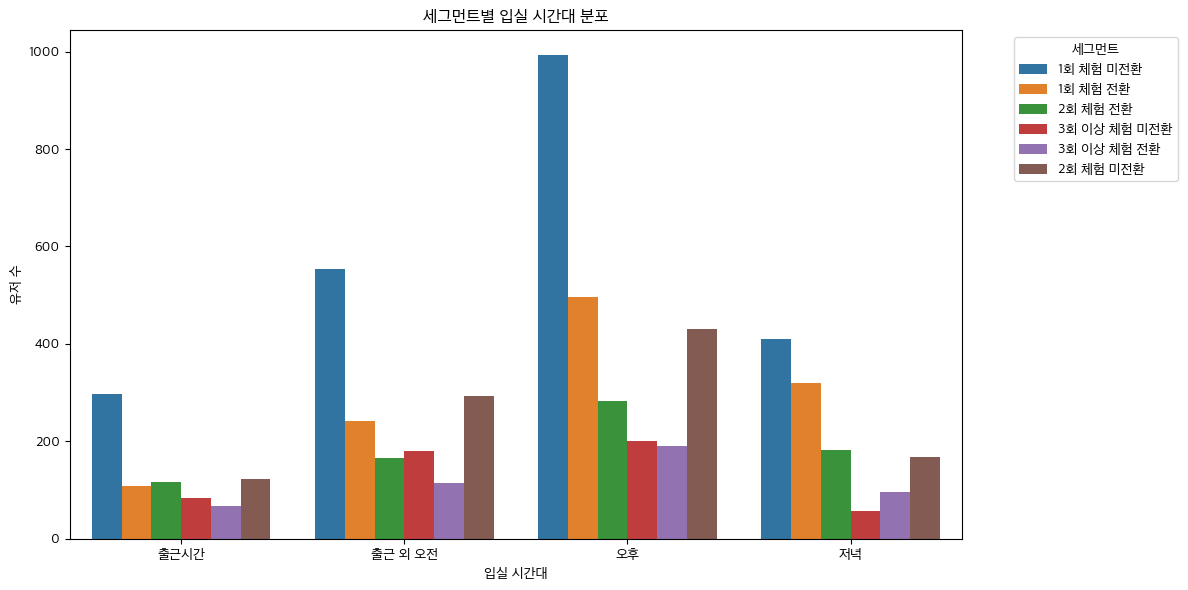

In [86]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='enter_time_group', hue='segment', order=['Ï∂úÍ∑ºÏãúÍ∞Ñ', 'Ï∂úÍ∑º Ïô∏ Ïò§Ï†Ñ', 'Ïò§ÌõÑ', 'Ï†ÄÎÖÅ'])
plt.title('ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ ÏûÖÏã§ ÏãúÍ∞ÑÎåÄ Î∂ÑÌè¨')
plt.xlabel('ÏûÖÏã§ ÏãúÍ∞ÑÎåÄ')
plt.ylabel('Ïú†Ï†Ä Ïàò')
plt.legend(title='ÏÑ∏Í∑∏Î®ºÌä∏', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

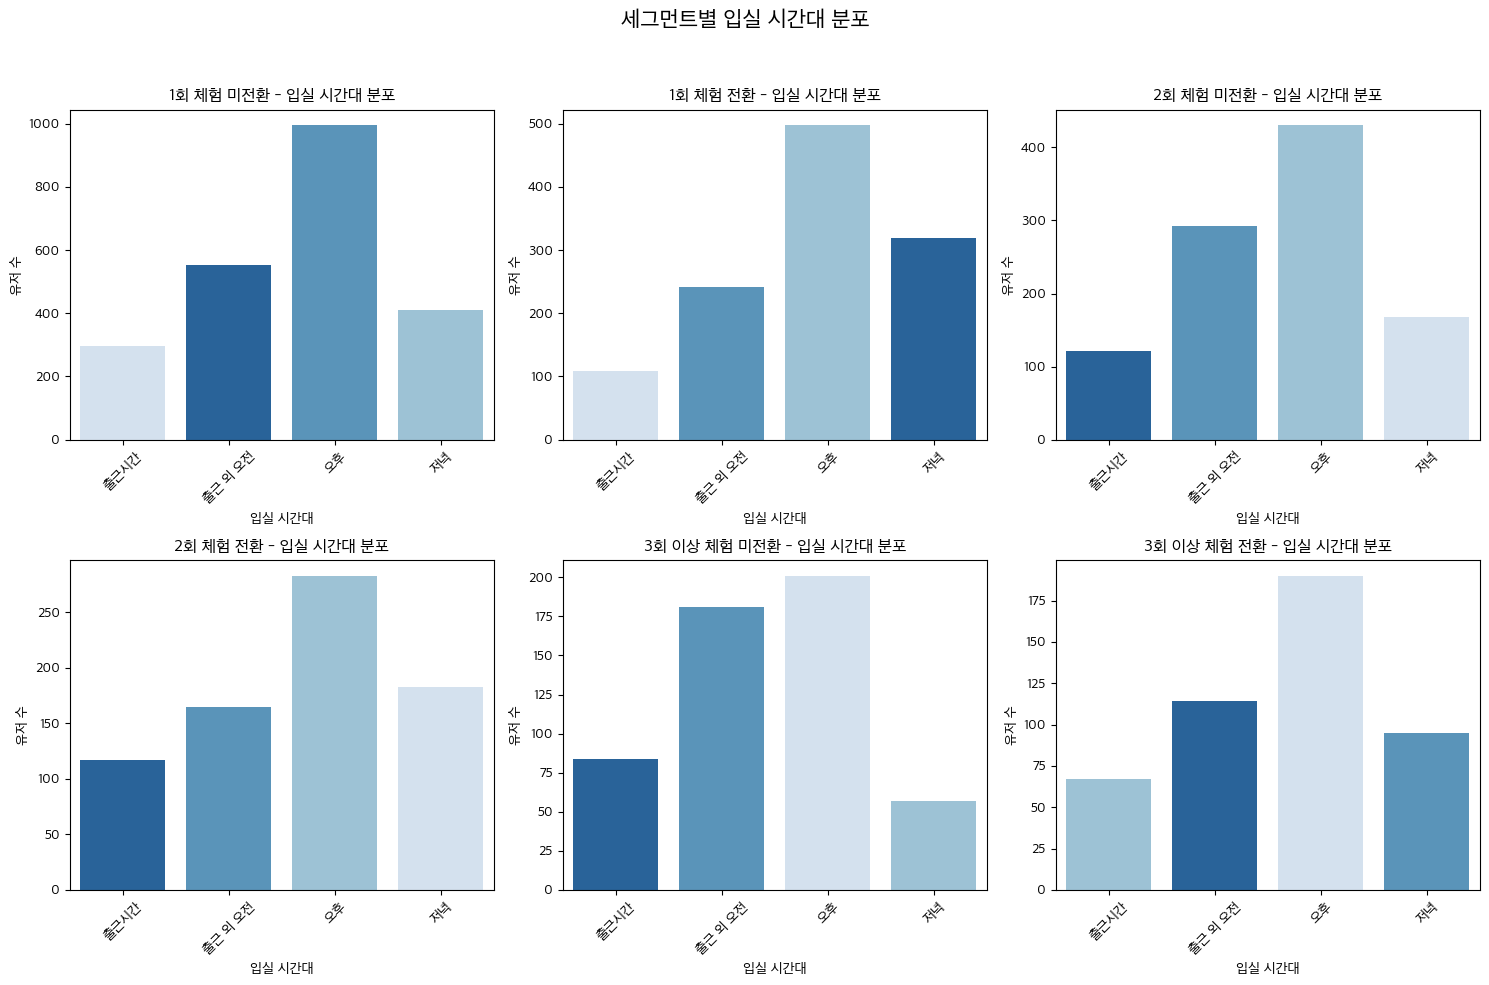

In [87]:
# ÏÑ∏Í∑∏Î®ºÌä∏ Î¶¨Ïä§Ìä∏
segments = df['segment'].unique()

# subplot ÏÑ§Ï†ï
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ ÏûÖÏã§ ÏãúÍ∞ÑÎåÄ Î∂ÑÌè¨', fontsize=16)
time_order = ['Ï∂úÍ∑ºÏãúÍ∞Ñ', 'Ï∂úÍ∑º Ïô∏ Ïò§Ï†Ñ', 'Ïò§ÌõÑ', 'Ï†ÄÎÖÅ']

# ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ Í∑∏ÎûòÌîÑ
for i, segment in enumerate(sorted(segments)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    sns.countplot(
        data=df[df['segment'] == segment],
        x='enter_time_group',
        hue='enter_time_group',
        order=time_order,
        palette='Blues',
        legend=False,
        ax=ax
    )

    ax.set_title(f'{segment} - ÏûÖÏã§ ÏãúÍ∞ÑÎåÄ Î∂ÑÌè¨')
    ax.set_xlabel('ÏûÖÏã§ ÏãúÍ∞ÑÎåÄ')
    ax.set_ylabel('Ïú†Ï†Ä Ïàò')
    ax.tick_params(axis='x', rotation=45)

# Îπà subplot Ï†úÍ±∞
for j in range(len(segments), 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

‚úÖ Ï£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏

1. Ï†ÑÌôò/ÎØ∏Ï†ÑÌôò Í≥µÌÜµ Ìå®ÌÑ¥: Ïò§ÌõÑ ÏûÖÏã§ ÎπÑÏ§ëÏù¥ Í∞ÄÏû• ÎÜíÏùå
    - Ï†Ñ ÏÑ∏Í∑∏Î®ºÌä∏ÏóêÏÑú ‚ÄòÏò§ÌõÑ‚Äô ÏãúÍ∞ÑÎåÄ ÏûÖÏã§ ÎπÑÏ§ëÏù¥ Í∞ÄÏû• ÎÜíÏùå
    - Ïù¥Îäî Ïú†Ï†ÄÎì§Ïù¥ Ï£ºÎ°ú ÏóÖÎ¨¥ Ï§ë/ÌõÑ Ïó¨Ïú† ÏãúÍ∞ÑÏóê ÌîåÎû´ÌèºÏùÑ Î∞©Î¨∏ÌïòÎäî Í≤ΩÌñ•ÏùÑ ÏãúÏÇ¨
    - ÌäπÌûà ÎØ∏Ï†ÑÌôò Í∑∏Î£π(1~2Ìöå)Ïùò Í≤ΩÏö∞ Ïò§ÌõÑ ÏßëÏ§ëÎèÑÍ∞Ä ÎçîÏö± Í∞ïÌï®

2. Ï†ÑÌôò Ïú†Ï†ÄÎäî Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú 'Ï∂úÍ∑º Ïô∏ Ïò§Ï†Ñ' ÏûÖÏã§ ÎπÑÏ§ëÏù¥ ÎÜíÏùå
    - Ï†ÑÌôò ÏÑ∏Í∑∏Î®ºÌä∏(1~3Ìöå Ïù¥ÏÉÅ)Îäî Ï∂úÍ∑º Ïô∏ Ïò§Ï†Ñ ÏãúÍ∞ÑÎåÄÏùò ÏûÖÏã§ ÎπÑÏ§ëÏù¥ ÎØ∏Ï†ÑÌôò ÎåÄÎπÑ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÜíÏùå
    - Ïòà: 1Ìöå Ï≤¥Ìóò Ï†ÑÌôòÏùÄ Ïò§Ï†Ñ ÎπÑÏ§ëÏù¥ 1Ìöå ÎØ∏Ï†ÑÌôòÎ≥¥Îã§ ÎÜíÏùå
    - Ïù¥Îäî ÏóÖÎ¨¥ ÏãúÏûë Ï†Ñ Ïó¨Ïú† ÏãúÍ∞ÑÏùÑ ÌôúÏö©ÌïòÎäî Ïú†Ï†ÄÍ∞Ä Ï†ÑÌôòÏú®Ïù¥ ÎÜíÏùÑ Ïàò ÏûàÏùåÏùÑ ÏãúÏÇ¨

3. ‚ÄòÏ∂úÍ∑ºÏãúÍ∞Ñ‚Äô ÏûÖÏã§ÏùÄ Ï†ÑÌôò Ïó¨Î∂ÄÏôÄ ÎöúÎ†∑Ìïú ÏÉÅÍ¥Ä ÏóÜÏùå
    - Ï∂úÍ∑ºÏãúÍ∞Ñ ÏãúÍ∞ÑÎåÄÎäî ÎåÄÎ∂ÄÎ∂Ñ ÏÑ∏Í∑∏Î®ºÌä∏ÏóêÏÑú ÎÇÆÏùÄ ÎπÑÏ§ëÏùÑ Î≥¥Ïù¥Î©∞, Ï†ÑÌôò/ÎØ∏Ï†ÑÌôò Í∞Ñ ÌÅ∞ Ï∞®Ïù¥ ÏóÜÏùå

4. ‚ÄòÏ†ÄÎÖÅ‚Äô ÏãúÍ∞ÑÎåÄÎäî Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú ÎπÑÏ§ëÏù¥ ÎÇÆÏßÄÎßå, Ï†ÑÌôò ÏÑ∏Í∑∏Î®ºÌä∏ÏóêÏÑú ÏÜåÌè≠ ÏÉÅÏäπ
    - 3Ìöå Ïù¥ÏÉÅ Ï†ÑÌôò ÏÑ∏Í∑∏Î®ºÌä∏ÏóêÏÑúÎäî ‚ÄòÏ†ÄÎÖÅ‚Äô ÏãúÍ∞ÑÎåÄ ÎπÑÏ§ëÏù¥ ÎØ∏Ï†ÑÌôòÎ≥¥Îã§ ÎÜíÏùå
    - Ïù¥Îäî Íæ∏Ï§ÄÌûà ÏÇ¨Ïö©ÌïòÎäî Ïú†Ï†ÄÏùºÏàòÎ°ù Ìá¥Í∑º ÌõÑÏóêÎèÑ ÌîåÎû´ÌèºÏóê Ï†ëÏÜçÌïòÎäî ÌñâÎèô ÌäπÏÑ±ÏùÑ Î∞òÏòÅÌï† Ïàò ÏûàÏùå

#### Ï≤¥ÌÅ¨Ïù∏ Ìå®ÌÑ¥

In [88]:
df['total_checkins'].value_counts()

total_checkins
1     1165
2      961
4      747
3      575
6      493
5      399
8      368
7      252
10     220
12     165
9      137
11     114
13     110
14      93
16      53
15      46
20      37
18      36
21      26
25      21
27      17
31      17
63      16
54      16
17      15
22      14
19      13
26      10
24       9
23       9
30       4
38       3
28       3
33       2
40       1
29       1
34       1
Name: count, dtype: int64

In [89]:
def categorize_checkin_freq(x):
    if x == 1:
        return '1Ìöå Ï≤¥ÌÅ¨Ïù∏'
    elif 2 <= x <= 10:
        return 'Ï§ëÍ∞Ñ ÎπàÎèÑ Ï≤¥ÌÅ¨Ïù∏'
    elif x >= 10:
        return 'Îã§Ìöå Ï≤¥ÌÅ¨Ïù∏'

df['checkin_freq_category'] = df['total_checkins'].apply(categorize_checkin_freq)

In [90]:
print(df['total_checkins'].describe())

count    6169.000000
mean        5.786189
std         6.355255
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        63.000000
Name: total_checkins, dtype: float64


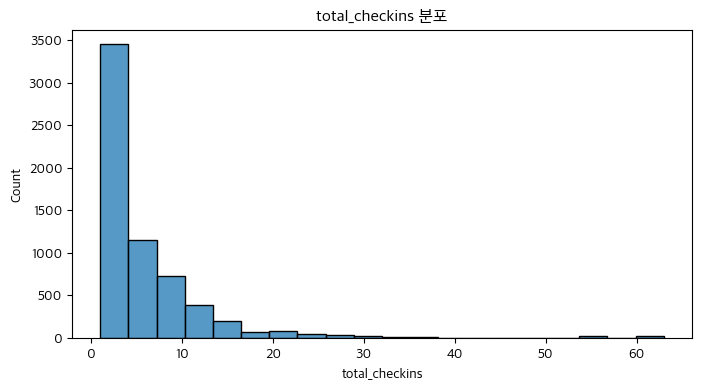

In [91]:
plt.figure(figsize=(8,4))
sns.histplot(df['total_checkins'], bins=20)
plt.title('total_checkins Î∂ÑÌè¨')
plt.show()

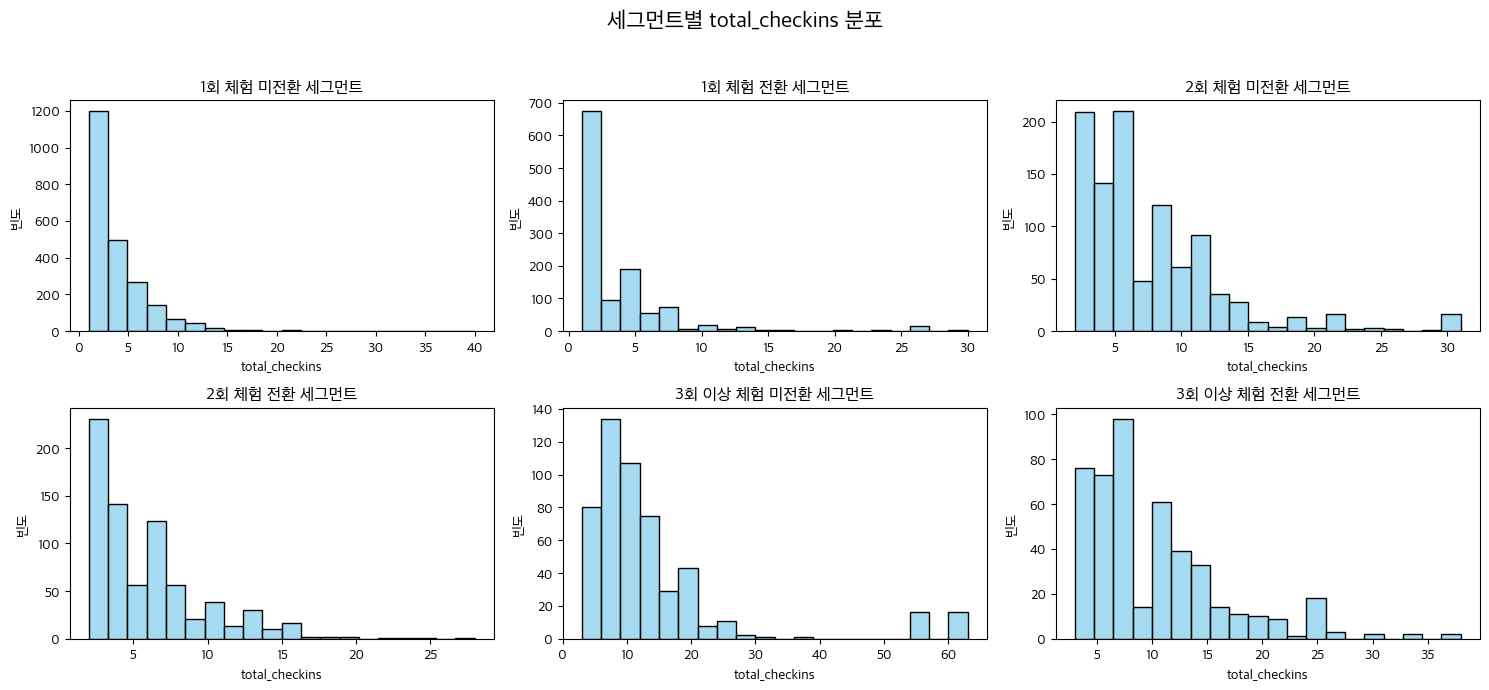

In [92]:
segments = df['segment'].unique()

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
fig.suptitle('ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ total_checkins Î∂ÑÌè¨', fontsize=16)

for i, segment in enumerate(sorted(segments)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    sns.histplot(
        data=df[df['segment'] == segment],
        x='total_checkins',
        bins=20,
        ax=ax,
        kde=False,
        color='skyblue'
    )

    ax.set_title(f'{segment} ÏÑ∏Í∑∏Î®ºÌä∏')
    ax.set_xlabel('total_checkins')
    ax.set_ylabel('ÎπàÎèÑ')

# Îπà subplot Ï†úÍ±∞
for j in range(len(segments), 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- Ï†ÑÌôò Í∑∏Î£π(Ï≤¥Ìóò ÌõÑ Ïù¥Ïö© Ï†ÑÌôòÌïú ÏÇ¨Ïö©Ïûê)ÏùÄ ÌèâÍ∑†Ï†ÅÏúºÎ°ú Ï≤¥ÌÅ¨Ïù∏ ÌöüÏàòÍ∞Ä Îçî ÎßéÍ≥†, Íæ∏Ï§ÄÌûà Ïù¥Ïö©ÌïòÎäî Í≤ΩÌñ•Ïù¥ Í∞ïÌï®
- ÎØ∏Ï†ÑÌôò Í∑∏Î£πÏùÄ ÎåÄÏ≤¥Î°ú Ï≤¥ÌÅ¨Ïù∏ ÌöüÏàòÍ∞Ä Ï†ÅÍ≥†, Ïù¥Ïö© ÎπàÎèÑÍ∞Ä ÎÇÆÏùå
- ÌäπÌûà, 3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Í∑∏Î£πÏóêÏÑú Ï†ÑÌôò Ïó¨Î∂ÄÏóê Îî∞Î•∏ Ï∞®Ïù¥Í∞Ä Îçî ÎöúÎ†∑ÌïòÍ≤å ÎÇòÌÉÄÎÇ®
- Ï¶â, Ï≤¥Ìóò ÌöüÏàòÍ∞Ä ÎäòÏñ¥ÎÇ†ÏàòÎ°ù Ï†ÑÌôò Í∞ÄÎä•ÏÑ±ÎèÑ ÎÜíÏïÑÏßÄÍ≥†, Ï†ÑÌôòÎêú ÏÇ¨Ïö©ÏûêÎäî Îçî ÎπàÎ≤àÌïòÍ≤å Í≥µÏú†Ïò§ÌîºÏä§Î•º Ïù¥Ïö©ÌïòÎäî Ìå®ÌÑ¥Ïù¥ ÌôïÏù∏

#### Ï≤¥Î•òÏãúÍ∞Ñ

In [93]:
df.head(2)

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   

  trial_date  visit_delay_days    segment  enter_hour  leave_hour   weekday  \
0 2023-12-21                 0  1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò           9          16  Thursday   
1 2023-12-21                 0  1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò           4          15  Thursday   

   congestion_score congestion_level enter_time_group checkin_freq_category  
0          0.076025               Î≥¥ÌÜµ             Ï∂úÍ∑ºÏãúÍ∞Ñ             Ï§ëÍ∞Ñ ÎπàÎèÑ Ï≤¥ÌÅ¨Ïù∏  
1          0.000648               Ïó¨Ïú†               Ï†ÄÎÖÅ             Ï§ëÍ∞Ñ ÎπàÎèÑ Ï≤¥ÌÅ¨Ïù∏

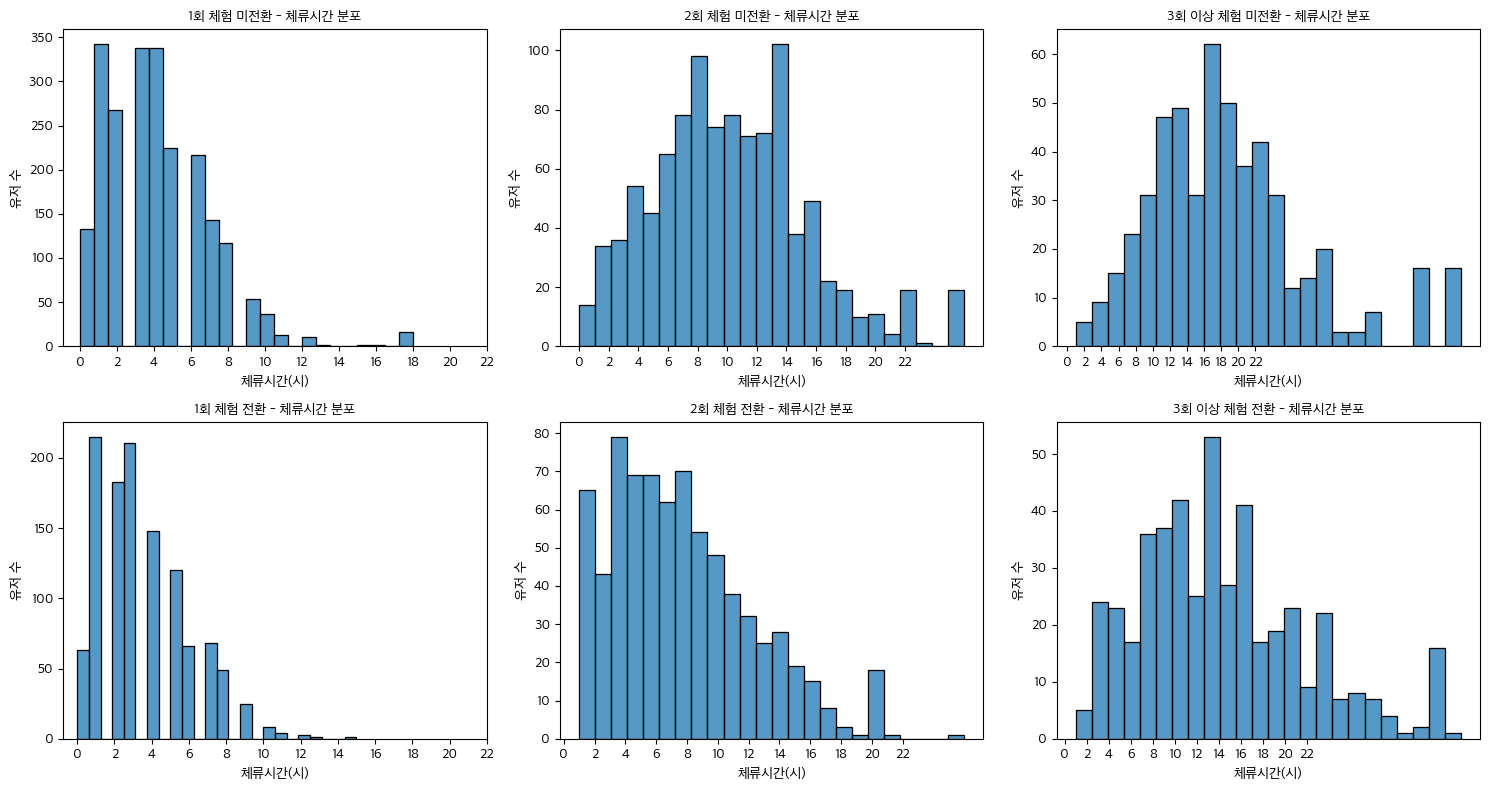

In [94]:
segment_order = [
    '1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '1Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò'
]

# subplot Î∞∞Ïó¥ Íµ¨ÏÑ± (Ïòà: 2Ìñâ 3Ïó¥)
n_segments = len(segment_order)
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

# subplot Î∞∞Ïó¥ Íµ¨ÏÑ± (Ïòà: 2Ìñâ 3Ïó¥)
n_cols = 3
n_rows = math.ceil(n_segments/ n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.histplot(subset['stay_time_hour'], bins=24, kde=False)
    plt.title(f'{seg} - Ï≤¥Î•òÏãúÍ∞Ñ Î∂ÑÌè¨', fontsize=10)
    plt.xlabel('Ï≤¥Î•òÏãúÍ∞Ñ(Ïãú)')
    plt.xticks(range(0, 24, 2))
    plt.ylabel('Ïú†Ï†Ä Ïàò')

plt.tight_layout()
plt.show()

#### Î∞©Î¨∏ÏßÄÏó∞ÏãúÍ∞Ñ

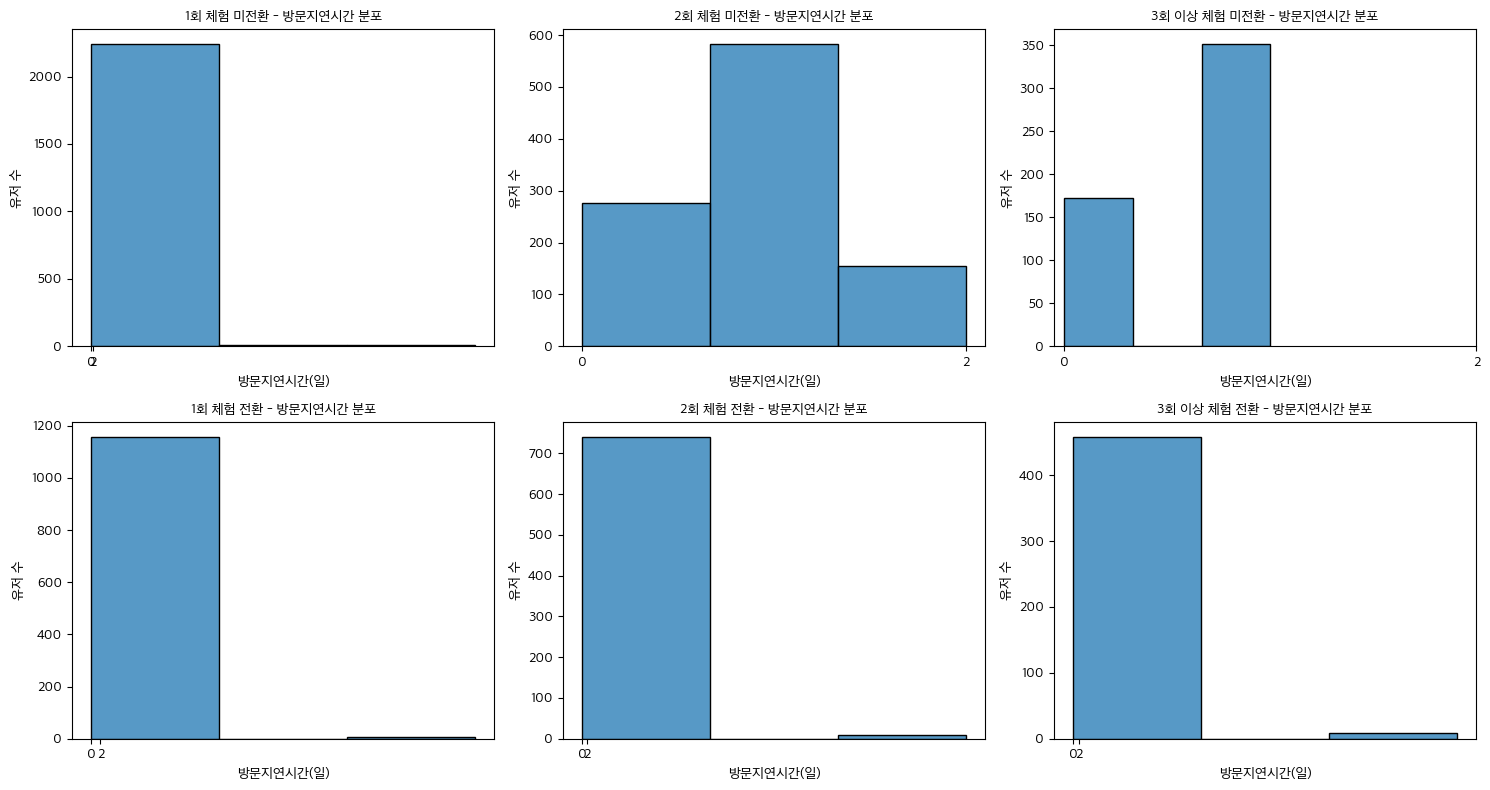

In [95]:
segment_order = [
    '1Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò ÎØ∏Ï†ÑÌôò',
    '1Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '2Ìöå Ï≤¥Ìóò Ï†ÑÌôò',
    '3Ìöå Ïù¥ÏÉÅ Ï≤¥Ìóò Ï†ÑÌôò'
]

# subplot Î∞∞Ïó¥ Íµ¨ÏÑ± (Ïòà: 2Ìñâ 3Ïó¥)
n_segments = len(segment_order)
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

# subplot Î∞∞Ïó¥ Íµ¨ÏÑ± (Ïòà: 2Ìñâ 3Ïó¥)
n_cols = 3
n_rows = math.ceil(n_segments/ n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.histplot(subset['visit_delay_days'], bins=3, kde=False)
    plt.title(f'{seg} - Î∞©Î¨∏ÏßÄÏó∞ÏãúÍ∞Ñ Î∂ÑÌè¨', fontsize=10)
    plt.xlabel('Î∞©Î¨∏ÏßÄÏó∞ÏãúÍ∞Ñ(Ïùº)')
    plt.xticks(range(0, 3, 2))
    plt.ylabel('Ïú†Ï†Ä Ïàò')

plt.tight_layout()
plt.show()

---

## 2.3 Î™®Îç∏ÎßÅÏùÑ ÏúÑÌïú ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ±

### 2.3.1 Ï≤¥ÌÅ¨Ïù∏ Í¥ÄÎ†® ÌååÏÉùÎ≥ÄÏàò

#### Ïùº ÌèâÍ∑† Ï≤¥ÌÅ¨Ïù∏ Ïàò (`mean_checkins_per_day`)

In [96]:
# 0ÏúºÎ°ú ÎÇòÎàÑÎäî Í≤ΩÏö∞ NaNÏúºÎ°ú Ï≤òÎ¶¨Ìïú Îí§ float64Î°ú Î≥ÄÌôò
user['mean_checkins_per_day'] = (
    user['total_checkins'] / user['days'].replace(0, np.nan)
).round(2).astype('float64')

In [97]:
# Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥ ÌôïÏù∏
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_uuid              6169 non-null   object        
 1   first_visit            6169 non-null   datetime64[ns]
 2   last_visit             6169 non-null   datetime64[ns]
 3   total_checkins         6169 non-null   int64         
 4   stay_time_hour         6169 non-null   int64         
 5   days                   6169 non-null   int64         
 6   is_payment             6169 non-null   int64         
 7   trial_date             6169 non-null   datetime64[ns]
 8   visit_delay_days       6169 non-null   int64         
 9   mean_checkins_per_day  6169 non-null   float64       
dtypes: datetime64[ns](3), float64(1), int64(5), object(1)
memory usage: 482.1+ KB


In [98]:
# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
user.head()

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   
2  2ba8ab19-2d40-4423-ad04-f0f9ca814871 2023-12-21 21:31:16   
3  1d49ba36-6c23-405b-9514-aa7f4aeceff0 2023-12-21 21:16:39   
4  b2d80cf6-2ced-4270-9d7a-43119bba35d2 2023-12-22 15:37:55   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   
2 2023-12-21 22:50:51               2               1     1           0   
3 2023-12-21 22:50:56               2               1     1           0   
4 2023-12-22 17:59:12               2               2     1           0   

  trial_date  visit_delay_days  mean_checkins_per_day  
0 2023-12-21                 0                    6.0  
1 2023-12-21                 0                    2.0  
2 2023-12-21                 0                    2.0  
3 2023-12-21                 0                    2.0  
4 2023-12-22                 0                    2.0

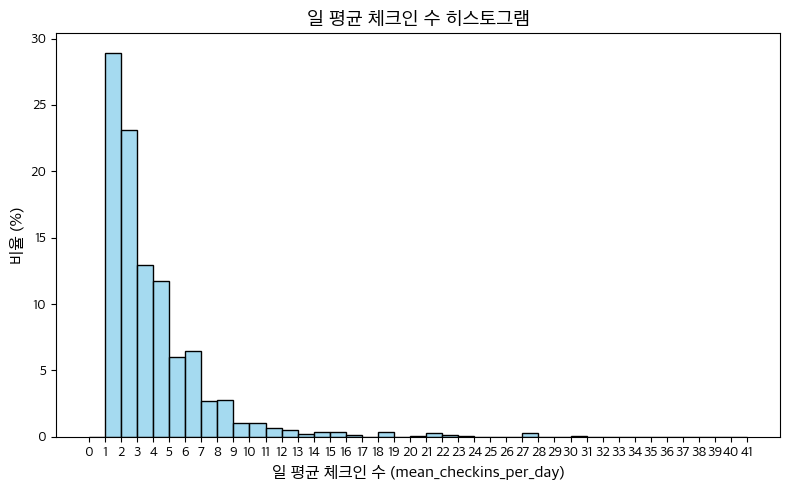

In [99]:
# 1. bin Í∏∞Ï§Ä ÏÑ§Ï†ï (0Î∂ÄÌÑ∞ 10ÍπåÏßÄ 1 Í∞ÑÍ≤©ÏúºÎ°ú, ÌïÑÏöîÏãú ÌôïÏû• Í∞ÄÎä•)
bins = np.arange(0, user['mean_checkins_per_day'].max() + 2, 1)

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.histplot(data=user, x='mean_checkins_per_day', bins=bins, stat='percent', kde=False, color='skyblue', edgecolor='black')

# 3. Íæ∏ÎØ∏Í∏∞
plt.xlabel('Ïùº ÌèâÍ∑† Ï≤¥ÌÅ¨Ïù∏ Ïàò (mean_checkins_per_day)', fontsize=12)
plt.ylabel('ÎπÑÏú® (%)', fontsize=12)
plt.title('Ïùº ÌèâÍ∑† Ï≤¥ÌÅ¨Ïù∏ Ïàò ÌûàÏä§ÌÜ†Í∑∏Îû®', fontsize=14)
plt.xticks(bins)  # ÎààÍ∏à Ï†ïÏàòÎ°ú Í≥†Ï†ï
plt.tight_layout()
plt.show()

#### Ïùº ÌèâÍ∑† Ï≤¥ÌÅ¨Ïù∏ Ïàò Î≤îÏ£ºÌòï ÌååÏÉùÎ≥ÄÏàò (`mean_checkins_level`)
- Ìï¥ÏÑùÏùÑ Ïö©Ïù¥ÌïòÍ≤å ÌïòÍ≥†, ÏïàÏ†ïÏÑ±ÏùÑ ÌôïÎ≥¥ÌïòÍ∏∞ ÏúÑÌï¥ Î≤îÏ£ºÌòï Î≥ÄÏàòÎ•º ÎèÑÏûÖÌï©ÎãàÎã§.

In [100]:
# mean_checkins_per_day Í∏∞Ï§ÄÏúºÎ°ú Î≤îÏ£º ÏÉùÏÑ±
def label_checkins(mean):
    if mean < 2:
        return 1  # 1 Ïù¥ÏÉÅ ~ 2 ÎØ∏Îßå
    elif mean < 4:
        return 2  # 2 Ïù¥ÏÉÅ ~ 4 ÎØ∏Îßå
    else:
        return 3  # 4 Ïù¥ÏÉÅ

# Ï†ÅÏö©
user['mean_checkins_level'] = user['mean_checkins_per_day'].apply(label_checkins).astype('int64')

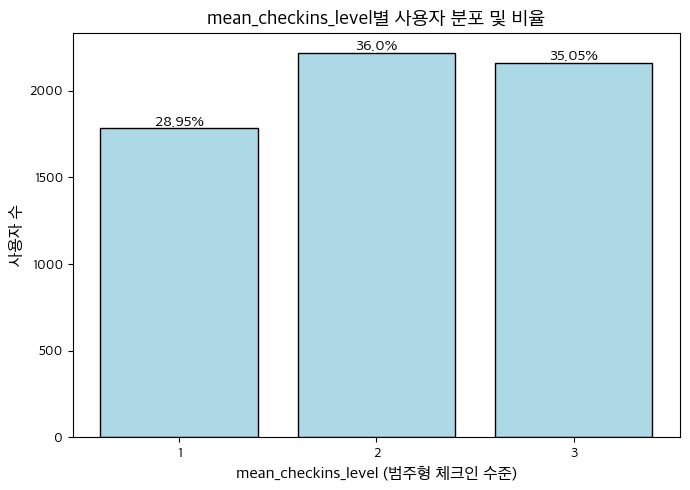

In [101]:
# 1. Í∞í Í≥ÑÏÇ∞
level_counts = user['mean_checkins_level'].value_counts().sort_index()
level_percent = (level_counts / level_counts.sum() * 100).round(2)

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(7, 5))
bars = plt.bar(level_counts.index.astype(str), level_counts.values, color='lightblue', edgecolor='black')

# 3. ÎπÑÏú® ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
for i, (count, percent) in enumerate(zip(level_counts, level_percent)):
    plt.text(i, count + 2, f'{percent}%', ha='center', va='bottom', fontsize=11)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xlabel('mean_checkins_level (Î≤îÏ£ºÌòï Ï≤¥ÌÅ¨Ïù∏ ÏàòÏ§Ä)', fontsize=12)
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=12)
plt.title('mean_checkins_levelÎ≥Ñ ÏÇ¨Ïö©Ïûê Î∂ÑÌè¨ Î∞è ÎπÑÏú®', fontsize=14)
plt.tight_layout()
plt.show()

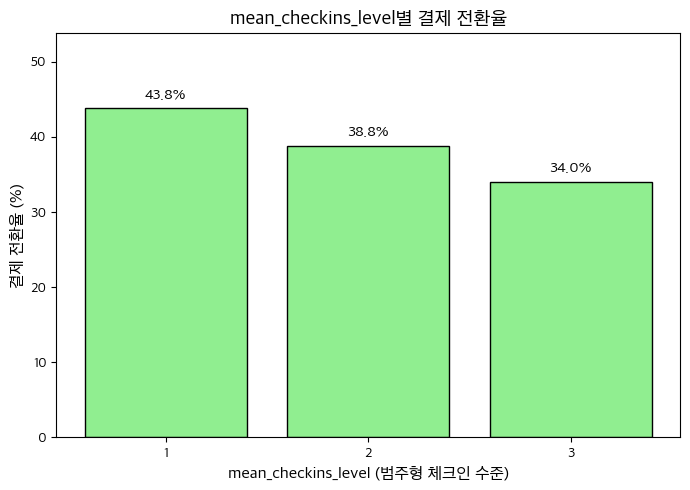

In [102]:
# 1. Í∞Å Î†àÎ≤®Î≥Ñ Í≤∞Ï†úÏú® Í≥ÑÏÇ∞
conversion_rate = user.groupby('mean_checkins_level')['is_payment'].mean().round(3) * 100  # ÌçºÏÑºÌä∏Î°ú ÌëúÍ∏∞

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(7, 5))
bars = plt.bar(conversion_rate.index.astype(str), conversion_rate.values, color='lightgreen', edgecolor='black')

# 3. ÎπÑÏú® ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
for i, rate in enumerate(conversion_rate.values):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom', fontsize=11)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xlabel('mean_checkins_level (Î≤îÏ£ºÌòï Ï≤¥ÌÅ¨Ïù∏ ÏàòÏ§Ä)', fontsize=12)
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)', fontsize=12)
plt.title('mean_checkins_levelÎ≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú®', fontsize=14)
plt.ylim(0, max(conversion_rate.values) + 10)
plt.tight_layout()
plt.show()

#### Ïù¥ÏßÑ ÌååÏÉùÎ≥ÄÏàò: ÎπàÎ≤àÌïú Ï≤¥ÌÅ¨Ïù∏ (`frequent_checkins`)

- `mean_checkins_per_day` Î∂ÑÌè¨Î•º ÌûàÏä§ÌÜ†Í∑∏Îû®ÏúºÎ°ú ÌôïÏù∏Ìïú Í≤∞Í≥º,  
  **ÏùºÏùº ÌèâÍ∑† Ï≤¥ÌÅ¨Ïù∏ ÏàòÍ∞Ä 3 Ïù¥ÏÉÅÏù∏ ÏÇ¨Ïö©ÏûêÍ∞Ä Ï†ÑÏ≤¥Ïùò ÏïΩ Ï†àÎ∞ò ÏàòÏ§Ä**ÏûÑÏùÑ ÌôïÏù∏Ìï®.
- `frequent_checkins_user`: ÏùºÏùº ÌèâÍ∑† Ï≤¥ÌÅ¨Ïù∏ ÏàòÍ∞Ä **3 Ïù¥ÏÉÅÏù¥Î©¥ 1**, ÏïÑÎãàÎ©¥ 0
- ÏÇ¨Ïö©ÏûêÏùò **Ï≤¥Ìóò ÌòïÌÉúÎÇò Í≥µÍ∞Ñ Ïù¥Ïö© ÌñâÌÉúÏùò Î∂ÑÏ†àÏÑ±**ÏùÑ Í∞ÄÎ¶¨ÌÇ§Îäî Î≥¥Ï°∞Ï†Å ÏßÄÌëúÎ°ú ÌôúÏö©

In [103]:
# frequent_checkins_user Î≥ÄÏàò ÏÉùÏÑ±
user['frequent_checkins'] = (user['mean_checkins_per_day'] >= 3).astype('int64')

In [104]:
# Ïó¥ ÌôïÏù∏
user.columns

Index(['user_uuid', 'first_visit', 'last_visit', 'total_checkins',
       'stay_time_hour', 'days', 'is_payment', 'trial_date',
       'visit_delay_days', 'mean_checkins_per_day', 'mean_checkins_level',
       'frequent_checkins'],
      dtype='object')

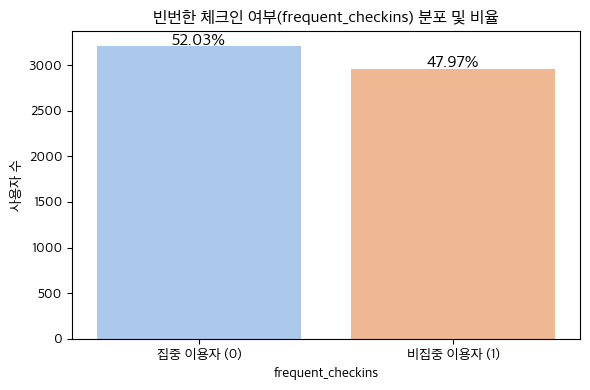

In [105]:
# 1. Í∞í Í≥ÑÏÇ∞
checkins_counts = user['frequent_checkins'].value_counts().sort_index()
checkins_percent = (checkins_counts / len(user) * 100).round(2)

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
sns.barplot(x=checkins_counts.index, y=checkins_counts.values, palette='pastel')

# 3. ÎπÑÏú® ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
for i, (count, percent) in enumerate(zip(checkins_counts, checkins_percent)):
    plt.text(i, count + 10, f'{percent}%', ha='center', fontsize=12)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xticks([0, 1], ['ÏßëÏ§ë Ïù¥Ïö©Ïûê (0)', 'ÎπÑÏßëÏ§ë Ïù¥Ïö©Ïûê (1)'])
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò')
plt.title('ÎπàÎ≤àÌïú Ï≤¥ÌÅ¨Ïù∏ Ïó¨Î∂Ä(frequent_checkins) Î∂ÑÌè¨ Î∞è ÎπÑÏú®')
plt.tight_layout()
plt.show()

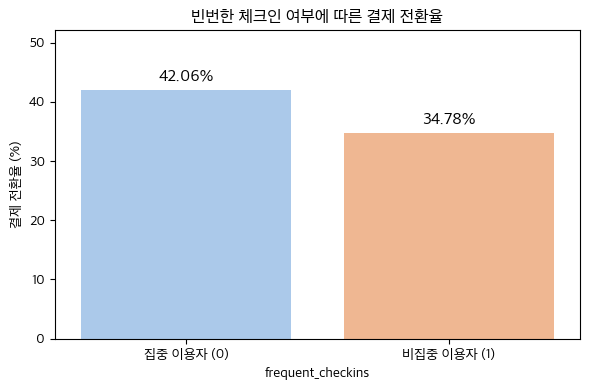

In [106]:
# 1. Í≤∞Ï†ú Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
checkins_conversion = user.groupby('frequent_checkins')['is_payment'].mean().round(4) * 100

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=checkins_conversion.index, y=checkins_conversion.values, palette='pastel')

# 3. ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä (ÎßâÎåÄ ÏúÑÏóê Î∞∞Ïπò)
for i, val in enumerate(checkins_conversion.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xticks([0, 1], ['ÏßëÏ§ë Ïù¥Ïö©Ïûê (0)', 'ÎπÑÏßëÏ§ë Ïù¥Ïö©Ïûê (1)'])
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)')
plt.title('ÎπàÎ≤àÌïú Ï≤¥ÌÅ¨Ïù∏ Ïó¨Î∂ÄÏóê Îî∞Î•∏ Í≤∞Ï†ú Ï†ÑÌôòÏú®')
plt.ylim(0, max(checkins_conversion.values) + 10)  # ÌÖçÏä§Ìä∏ Í≥µÍ∞Ñ ÌôïÎ≥¥
plt.tight_layout()
plt.show()

#### ‚úÖ Ïù∏ÏÇ¨Ïù¥Ìä∏

- **frequent_checkins == 0** (Îçú ÎπàÎ≤àÌïòÍ≤å Ï≤¥ÌÅ¨Ïù∏Ìïú ÏÇ¨Ïö©Ïûê)Ïùò **Ï†ÑÌôòÏú®ÏùÄ 41.87%**  
- **frequent_checkins == 1** (ÎπàÎ≤àÌïòÍ≤å Ï≤¥ÌÅ¨Ïù∏Ìïú ÏÇ¨Ïö©Ïûê)Ïùò **Ï†ÑÌôòÏú®ÏùÄ 35.04%**

Ï¶â, Îì§ÎùΩÎÇ†ÎùΩÌïòÏßÄ ÏïäÍ≥† ÏßëÏ§ëÏ†ÅÏúºÎ°ú Ïù¥Ïö©Ìïú ÏÇ¨Ïö©ÏûêÏùò Í≤∞Ï†ú Ï†ÑÌôòÏú®Ïù¥ **Îçî ÎÜíÏùå**.

### 2.3.2 ÌèâÍ∑† Ï≤¥Î•òÏãúÍ∞Ñ Î∂ÑÌè¨ Î∞è Ï†ÑÌôòÎ•† ÌôïÏù∏

#### Ïùº ÌèâÍ∑† Ï≤¥Î•òÏãúÍ∞Ñ (`mean_stay_time_hour`)
- ÏÇ¨Ïö©ÏûêÎßàÎã§ Î∞©Î¨∏ÏùºÏàòÍ∞Ä Îã§Î•¥ÎØÄÎ°ú Îã®ÏàúÌûà Ï¥ù Ï≤¥Î•ò ÏãúÍ∞ÑÏúºÎ°úÎäî ÎπÑÍµêÍ∞Ä Ïñ¥Î†µÏäµÎãàÎã§.
- ÏùòÎØ∏ ÏûàÎäî ÎπÑÍµêÎ•º ÏúÑÌï¥ Ïùº ÌèâÍ∑† Ï≤¥Î•ò ÏãúÍ∞Ñ ÌååÏÉùÎ≥ÄÏàòÎ•º ÎèÑÏûÖÌï©ÎãàÎã§.

In [107]:
# 0ÏúºÎ°ú ÎÇòÎàÑÎäî Í≤ΩÏö∞ NaNÏúºÎ°ú Ï≤òÎ¶¨Ìïú Îí§ float64Î°ú Î≥ÄÌôò
user['mean_stay_time_hour'] = (
    user['stay_time_hour'] / user['days'].replace(0, np.nan)
).round(2).astype('float64')

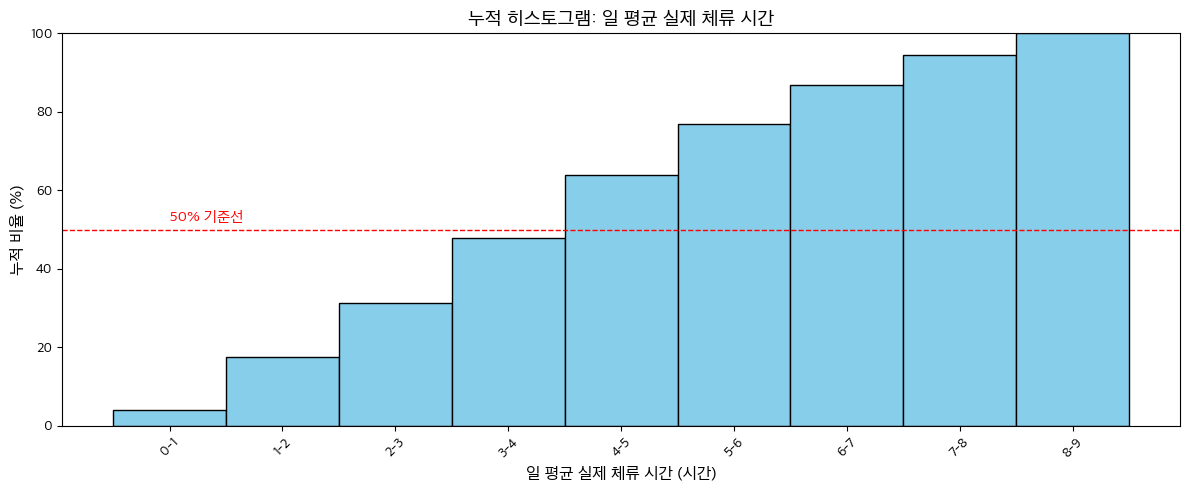

In [108]:
# 1. 1ÏãúÍ∞Ñ Îã®ÏúÑ bin ÏÑ§Ï†ï
bins = np.arange(0, 10, 1)

# 2. mean_stay_time_hour Í∞í Ï§ë 10 ÎÇ¥Ïùò Í∞íÎßå ÏÇ¨Ïö©
filtered = user['mean_stay_time_hour'].clip(upper=10)

# 3. Í∞Å binÏóê ÏÜçÌïòÎäî Í∞í Ïàò Í≥ÑÏÇ∞
bin_counts = pd.cut(filtered, bins=bins, right=False).value_counts().sort_index()

# 4. ÎàÑÏ†ÅÌï© ÎπÑÏú® Í≥ÑÏÇ∞
cumulative_percent = (bin_counts.cumsum() / bin_counts.sum() * 100).round(2)

# 5. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 5))
plt.bar(range(len(cumulative_percent)), cumulative_percent, width=1.0, align='center',
        color='skyblue', edgecolor='black')

# 6. xÏ∂ï ÎààÍ∏à ÏÑ§Ï†ï
bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in cumulative_percent.index]
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)
plt.ylim(0, 100)

# 7. Í∏∞Ï§ÄÏÑ† (50% ÎèåÌåå ÏãúÏ†ê ÏãúÍ∞ÅÌôî)
plt.axhline(50, color='red', linestyle='--', linewidth=1)
plt.text(0, 52, '50% Í∏∞Ï§ÄÏÑ†', color='red', fontsize=11)

# 8. ÎùºÎ≤®ÎßÅ
plt.xlabel('Ïùº ÌèâÍ∑† Ïã§Ï†ú Ï≤¥Î•ò ÏãúÍ∞Ñ (ÏãúÍ∞Ñ)', fontsize=12)
plt.ylabel('ÎàÑÏ†Å ÎπÑÏú® (%)', fontsize=12)
plt.title('ÎàÑÏ†Å ÌûàÏä§ÌÜ†Í∑∏Îû®: Ïùº ÌèâÍ∑† Ïã§Ï†ú Ï≤¥Î•ò ÏãúÍ∞Ñ', fontsize=14)
plt.tight_layout()
plt.show()

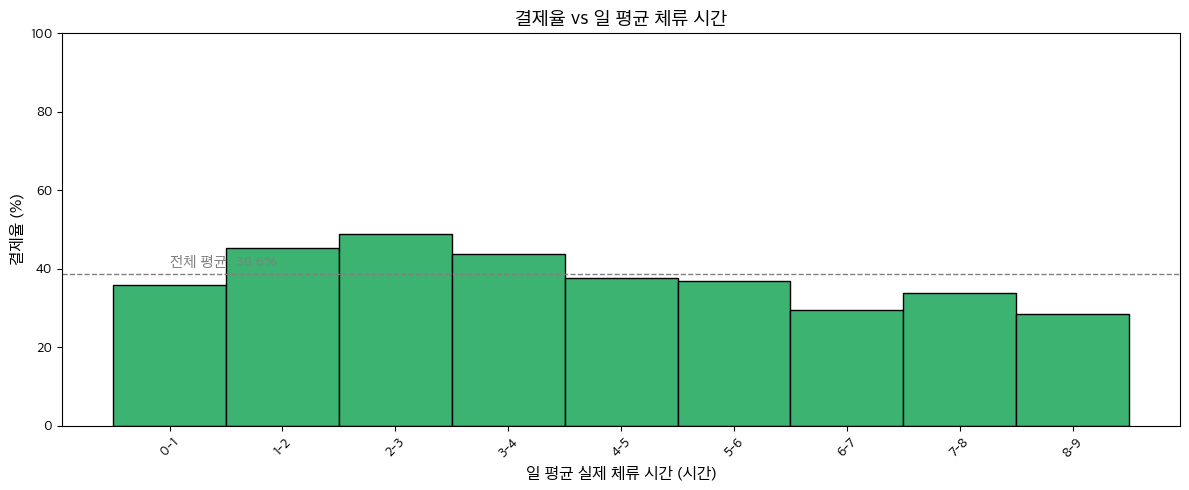

In [109]:
# 1. 1ÏãúÍ∞Ñ Îã®ÏúÑ bin ÏÑ§Ï†ï
bins = np.arange(0, 10, 1)

# 2. 10ÏãúÍ∞Ñ ÎØ∏Îßå ÏÇ¨Ïö©Ïûê ÌïÑÌÑ∞ÎßÅ
filtered_user = user[user['mean_stay_time_hour'] < 10].copy()

# 3. bin ÏßÄÏ†ï
filtered_user['stay_time_bin'] = pd.cut(filtered_user['mean_stay_time_hour'], bins=bins, right=False)

# 4. Í∞Å binÎ≥Ñ Ï†ÑÌôòÏú® Í≥ÑÏÇ∞ (Ïó¨Í∏∞ÏÑ† is_paymentÎ•º Ï†ÑÌôò ÏßÄÌëúÎ°ú ÏÇ¨Ïö©)
conversion_rate = (
    filtered_user.groupby('stay_time_bin')['is_payment']
    .mean()
    .round(3) * 100  # Î∞±Î∂ÑÏú®
)

# 5. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 5))
plt.bar(range(len(conversion_rate)), conversion_rate, width=1.0, align='center',
        color='mediumseagreen', edgecolor='black')

# 6. xÏ∂ï ÎààÍ∏à ÏÑ§Ï†ï
bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in conversion_rate.index]
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)
plt.ylim(0, 100)

# 7. Ï†ÑÏ≤¥ ÌèâÍ∑† Ï†ÑÌôòÏú® ÌëúÏãúÏÑ†
overall_rate = user['is_payment'].mean() * 100
plt.axhline(overall_rate, color='gray', linestyle='--', linewidth=1)
plt.text(0, overall_rate + 2, f'Ï†ÑÏ≤¥ ÌèâÍ∑†: {overall_rate:.1f}%', color='gray', fontsize=11)

# 8. ÎùºÎ≤®ÎßÅ
plt.xlabel('Ïùº ÌèâÍ∑† Ïã§Ï†ú Ï≤¥Î•ò ÏãúÍ∞Ñ (ÏãúÍ∞Ñ)', fontsize=12)
plt.ylabel('Í≤∞Ï†úÏú® (%)', fontsize=12)
plt.title('Í≤∞Ï†úÏú® vs Ïùº ÌèâÍ∑† Ï≤¥Î•ò ÏãúÍ∞Ñ', fontsize=14)
plt.tight_layout()
plt.show()

#### Ïùº ÌèâÍ∑† Ï≤¥Î•òÏãúÍ∞Ñ Î≤îÏ£ºÌòï ÌååÏÉùÎ≥ÄÏàò (`stay_time_level`)

Í∑∏ÎûòÌîÑÎ•º Î≥¥Î©¥ Ï†ÑÌôòÏú®Ïù¥ ÏùºÏ†ïÌïòÍ≤å Ï¶ùÍ∞ÄÌïòÍ±∞ÎÇò Í∞êÏÜåÌïòÏßÄ ÏïäÍ≥†, ÌäπÏ†ï Íµ¨Í∞ÑÎ∂ÄÌÑ∞ Í∞êÏÜåÌïòÎäî Í≤ΩÌñ•Ïù¥ Î≥¥ÏûÖÎãàÎã§. Ïù¥Î•º Í≥†Î†§ÌïòÎ©¥ Îã§ÏùåÍ≥º Í∞ôÏùÄ Í∏∞Ï§ÄÏúºÎ°ú stay_time_levelÏùÑ 3Í∞ú Ï†ïÎèÑÏùò Íµ¨Í∞ÑÏúºÎ°ú ÎÇòÎàÑÎäî Í≤ÉÏù¥ Ìï©Î¶¨Ï†ÅÏûÖÎãàÎã§:
1.	1Î†àÎ≤® (Ï†Ä Ï≤¥Î•ò): mean_stay_time_hour < 3
	-	ÏÇ¨Ïö©Ïûê ÎπÑÏú® ÎßéÏùå
	-	Ï†ÑÌôòÏú® ÌèâÍ∑† ÎòêÎäî ÌèâÍ∑† Ïù¥ÏÉÅ
2.	2Î†àÎ≤® (Ï§ë Ï≤¥Î•ò): 3 ‚â§ mean_stay_time_hour < 6
	-	Ï†ÑÌôòÏú® Í∞ÄÏû• ÎÜíÏùÄ Íµ¨Í∞Ñ Ìè¨Ìï®
3.	3Î†àÎ≤® (Í≥† Ï≤¥Î•ò): mean_stay_time_hour ‚â• 6
	-	Ï†ÑÌôòÏú®Ïù¥ Í∏âÍ≤©Ìûà Îñ®Ïñ¥ÏßÄÎäî Íµ¨Í∞Ñ

In [110]:
def categorize_stay_time(hour):
    if hour < 3:
        return 1
    elif hour < 6:
        return 2
    else:
        return 3

user['mean_stay_time_level'] = user['mean_stay_time_hour'].apply(categorize_stay_time).astype('int64')

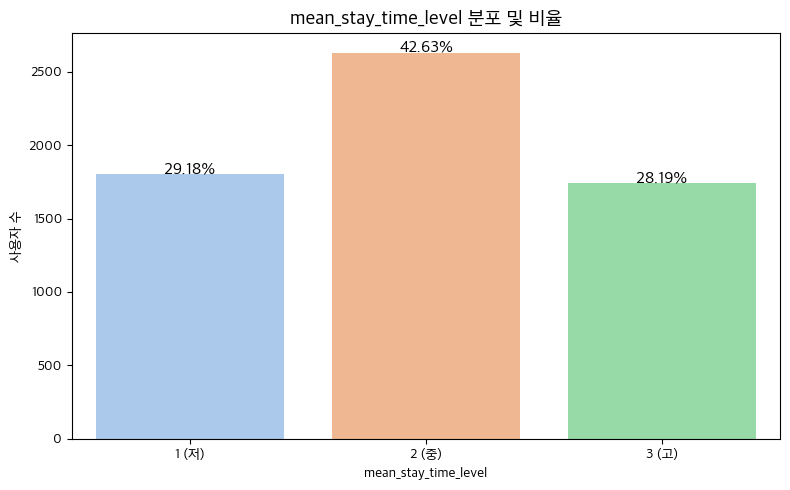

In [111]:
# 1. Î∂ÑÌè¨ Í≥ÑÏÇ∞
level_counts = user['mean_stay_time_level'].value_counts().sort_index()
level_percent = (level_counts / level_counts.sum() * 100).round(2)

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.barplot(x=level_counts.index, y=level_counts.values, palette='pastel')

# 3. ÎπÑÏú® ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
for i, (count, percent) in enumerate(zip(level_counts, level_percent)):
    plt.text(i, count + 1, f'{percent:.2f}%', ha='center', fontsize=12)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xticks(ticks=[0, 1, 2], labels=['1 (Ï†Ä)', '2 (Ï§ë)', '3 (Í≥†)'])
plt.xlabel('mean_stay_time_level')
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò')
plt.title('mean_stay_time_level Î∂ÑÌè¨ Î∞è ÎπÑÏú®', fontsize=14)
plt.tight_layout()
plt.show()

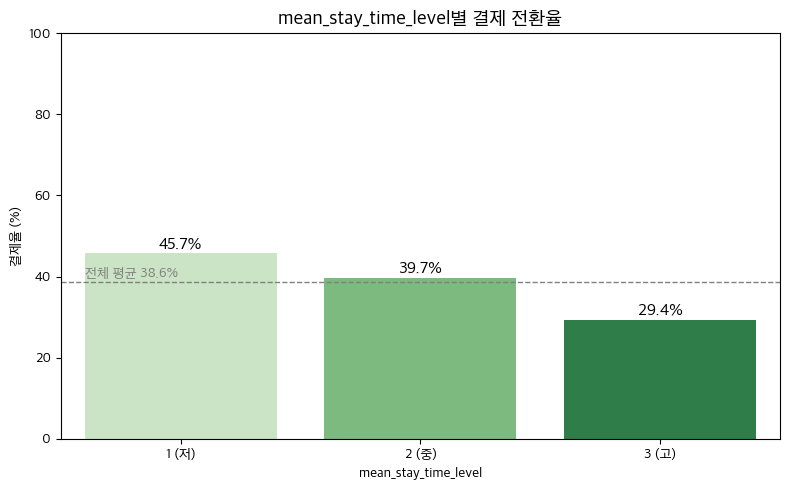

In [112]:
# 1. Í∑∏Î£πÎ≥Ñ Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
conversion_by_level = user.groupby('mean_stay_time_level')['is_payment'].mean().round(3) * 100

# 2. Ï†ÑÏ≤¥ ÌèâÍ∑† Ï†ÑÌôòÏú®
overall_conversion = user['is_payment'].mean().round(3) * 100

# 3. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_by_level.index, y=conversion_by_level.values, palette='Greens')

# 4. ÏàòÏπò ÎùºÎ≤® Ï∂îÍ∞Ä
for i, rate in enumerate(conversion_by_level.values):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', fontsize=12)

# 5. ÌèâÍ∑†ÏÑ† ÌëúÏãú
plt.axhline(overall_conversion, color='gray', linestyle='--', linewidth=1)
plt.text(-0.4, overall_conversion + 1, f'Ï†ÑÏ≤¥ ÌèâÍ∑† {overall_conversion:.1f}%', color='gray')

# 6. Íæ∏ÎØ∏Í∏∞
plt.xticks(ticks=[0, 1, 2], labels=['1 (Ï†Ä)', '2 (Ï§ë)', '3 (Í≥†)'])
plt.xlabel('mean_stay_time_level')
plt.ylabel('Í≤∞Ï†úÏú® (%)')
plt.title('mean_stay_time_levelÎ≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú®', fontsize=14)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### Ïù¥ÏßÑ ÌååÏÉùÎ≥ÄÏàò: Í∏¥ Ï≤¥Î•òÏãúÍ∞Ñ (`long_stay`)

mean_stay_time_hourÏùò Î∂ÑÌè¨Î•º Î≥¥Î©¥, ÏïΩ 4ÏãúÍ∞ÑÏùÑ Ï†ÑÌõÑÎ°ú ÏÇ¨Ïö©Ïûê Î∂ÑÌè¨Í∞Ä Ïñ¥Îäê Ï†ïÎèÑ Í∑†Ìòï ÏûàÍ≤å ÎÇòÎâòÎ©∞,
Ïù¥Î•º Í∏∞Ï§ÄÏúºÎ°ú Ïùº ÌèâÍ∑† Ïã§Ï†ú Ï≤¥Î•ò ÏãúÍ∞ÑÏù¥ Í∏¥ ÏÇ¨Ïö©ÏûêÏôÄ Í∑∏Î†áÏßÄ ÏïäÏùÄ ÏÇ¨Ïö©ÏûêÎ•º Íµ¨Î∂ÑÌïòÍ∏∞ Ï†ÅÏ†àÌï©ÎãàÎã§.

In [113]:
# ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±: long_stay_user
user['long_stay'] = (user['mean_stay_time_hour'] >= 4).astype(int)

In [114]:
# Ïó¥ ÌôïÏù∏
user.columns

Index(['user_uuid', 'first_visit', 'last_visit', 'total_checkins',
       'stay_time_hour', 'days', 'is_payment', 'trial_date',
       'visit_delay_days', 'mean_checkins_per_day', 'mean_checkins_level',
       'frequent_checkins', 'mean_stay_time_hour', 'mean_stay_time_level',
       'long_stay'],
      dtype='object')

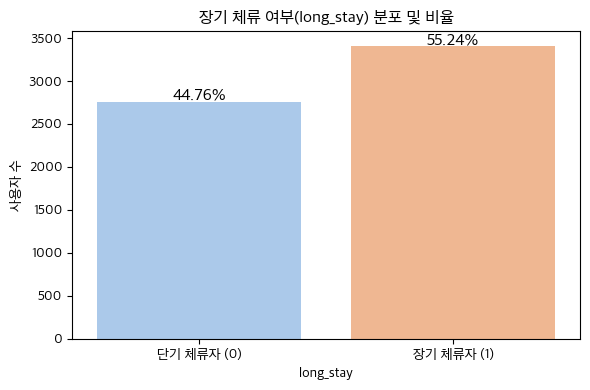

In [115]:
# 1. Í∞í Í≥ÑÏÇ∞
longstay_counts = user['long_stay'].value_counts().sort_index()
longstay_percent = (longstay_counts / len(user) * 100).round(2)

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
sns.barplot(x=longstay_counts.index, y=longstay_counts.values, palette='pastel')

# 3. ÎπÑÏú® ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
for i, (count, percent) in enumerate(zip(longstay_counts, longstay_percent)):
    plt.text(i, count + 10, f'{percent}%', ha='center', fontsize=12)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xticks([0, 1], ['Îã®Í∏∞ Ï≤¥Î•òÏûê (0)', 'Ïû•Í∏∞ Ï≤¥Î•òÏûê (1)'])
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò')
plt.title('Ïû•Í∏∞ Ï≤¥Î•ò Ïó¨Î∂Ä(long_stay) Î∂ÑÌè¨ Î∞è ÎπÑÏú®')
plt.tight_layout()
plt.show()

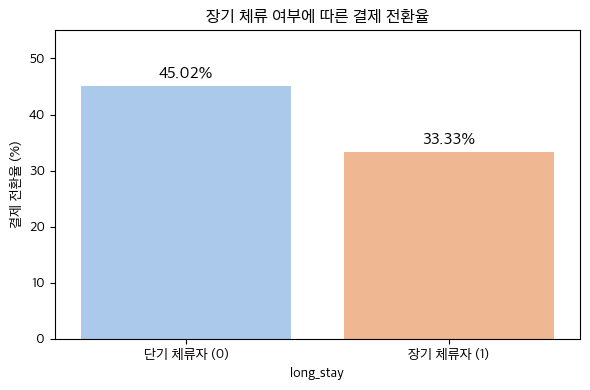

In [116]:
# 1. Í≤∞Ï†ú Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
longstay_conversion = user.groupby('long_stay')['is_payment'].mean().round(4) * 100

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=longstay_conversion.index, y=longstay_conversion.values, palette='pastel')

# 3. ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä (ÎßâÎåÄ ÏúÑÏóê Î∞∞Ïπò)
for i, val in enumerate(longstay_conversion.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xticks([0, 1], ['Îã®Í∏∞ Ï≤¥Î•òÏûê (0)', 'Ïû•Í∏∞ Ï≤¥Î•òÏûê (1)'])
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)')
plt.title('Ïû•Í∏∞ Ï≤¥Î•ò Ïó¨Î∂ÄÏóê Îî∞Î•∏ Í≤∞Ï†ú Ï†ÑÌôòÏú®')
plt.ylim(0, max(longstay_conversion.values) + 10)  # ÌÖçÏä§Ìä∏ Í≥µÍ∞Ñ ÌôïÎ≥¥
plt.tight_layout()
plt.show()

#### üìå Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏöîÏïΩ

- Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê Ï§ë Ïû•Í∏∞ Ï≤¥Î•òÏûêÎäî ÏïΩ 55.24%Î°ú Îã®Í∏∞ Ï≤¥Î•òÏûêÏôÄ ÎπÑÏä∑Ìïú ÎπÑÏú®ÏùÑ Ï∞®ÏßÄÌï®.
- Í∑∏Îü¨ÎÇò Ïû•Í∏∞ Ï≤¥Î•òÏûêÏùò Í≤∞Ï†ú Ï†ÑÌôòÏú®ÏùÄ 33.33%Î°ú, Îã®Í∏∞ Ï≤¥Î•òÏûê(45.02%)Ïóê ÎπÑÌï¥ 11.69%p ÎÇÆÏùå.
- Ïû•ÏãúÍ∞Ñ Î®∏Î¨∏Îã§Í≥† Ìï¥ÏÑú Î∞òÎìúÏãú Í≤∞Ï†úÎ°ú Ïù¥Ïñ¥ÏßÄÎäî Í≤ÉÏùÄ ÏïÑÎãòÏùÑ ÏãúÏÇ¨Ìï®.
- Ïò§ÌûàÎ†§ ÏßßÍ≤å Ï≤¥Î•òÌïòÎäî ÏÇ¨Ïö©ÏûêÍµ∞Ïù¥ Îçî Ï†ÅÍ∑πÏ†ÅÏù∏ Ï†ÑÌôò ÌñâÎèôÏùÑ Î≥¥Ïùº Ïàò ÏûàÏùå.

### 2.3.3 Ï≤´ Î∞©Î¨∏ Í¥ÄÎ†® ÌååÏÉùÎ≥ÄÏàò

#### Ï≤´ Î∞©Î¨∏ Ïõî (`first_visit_month`)

In [117]:
# first_visit_month ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±
user['first_visit_month'] = user['first_visit'].dt.month.astype('int64')

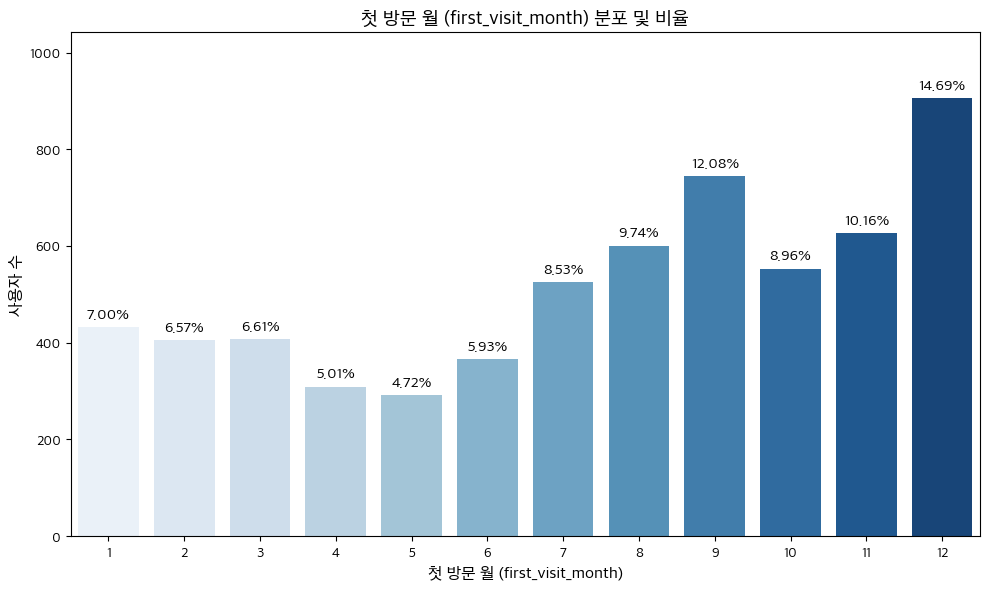

In [118]:
# 1. first_visit_monthÏùò Í∞í Í≥ÑÏÇ∞
first_visit_month_counts = user['first_visit_month'].value_counts().sort_index()
first_visit_month_percent = (first_visit_month_counts / len(user) * 100).round(2)

# 2. ÏãúÍ∞ÅÌôî (ÎßâÎåÄÍ∑∏ÎûòÌîÑ)
plt.figure(figsize=(10, 6)) # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞Î•º ÏÑ§Ï†ïÌï©ÎãàÎã§.
ax = sns.barplot(x=first_visit_month_counts.index, y=first_visit_month_counts.values, palette='Blues')

# 3. Í∞Å ÎßâÎåÄ ÏúÑÏóê ÎπÑÏú® ÌÖçÏä§Ìä∏Î•º Ï∂îÍ∞ÄÌï©ÎãàÎã§.
for i, (count, percent) in enumerate(zip(first_visit_month_counts, first_visit_month_percent)):
    plt.text(i, count + (ax.get_ylim()[1] * 0.02), f'{percent:.2f}%', ha='center', fontsize=11)

# 4. Í∑∏ÎûòÌîÑÎ•º Íæ∏Î∞âÎãàÎã§.
plt.xlabel('Ï≤´ Î∞©Î¨∏ Ïõî (first_visit_month)', fontsize=12)
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=12)
plt.title('Ï≤´ Î∞©Î¨∏ Ïõî (first_visit_month) Î∂ÑÌè¨ Î∞è ÎπÑÏú®', fontsize=14)
plt.ylim(0, first_visit_month_counts.max() * 1.15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

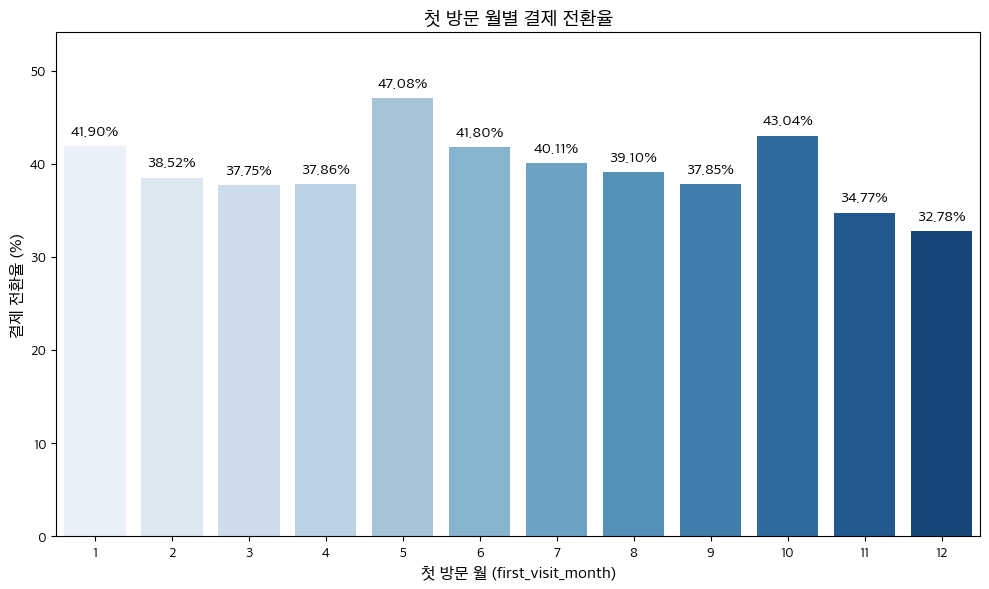

In [119]:
# 1. Ï≤´ Î∞©Î¨∏ ÏõîÎ≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
visit_month_conversion = user.groupby('first_visit_month')['is_payment'].mean().round(4) * 100

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=visit_month_conversion.index, y=visit_month_conversion.values, palette='Blues')

# 3. ÎßâÎåÄ ÏúÑ ÌÖçÏä§Ìä∏ ÌëúÏãú
for i, val in enumerate(visit_month_conversion.values):
    plt.text(i, val + (ax.get_ylim()[1] * 0.02), f'{val:.2f}%', ha='center', va='bottom', fontsize=11)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xlabel('Ï≤´ Î∞©Î¨∏ Ïõî (first_visit_month)', fontsize=12)
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)', fontsize=12)
plt.title('Ï≤´ Î∞©Î¨∏ ÏõîÎ≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú®', fontsize=14)
plt.ylim(0, visit_month_conversion.max() * 1.15 if not visit_month_conversion.empty else 10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Ï≤´ Î∞©Î¨∏ Î∂ÑÍ∏∞ (`first_visit_q`)

In [120]:
user['first_visit_q'] = ((user['first_visit_month'] - 1) // 3 + 1).astype('int64')

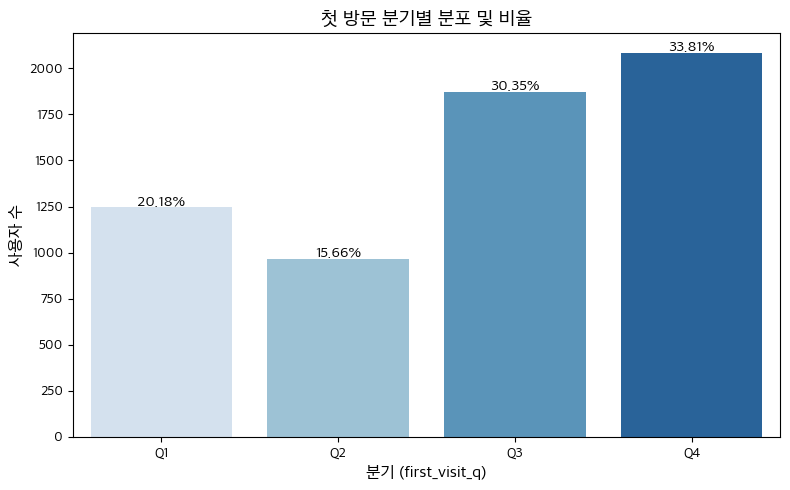

In [121]:
# Î∂ÑÌè¨ Í≥ÑÏÇ∞
q_counts = user['first_visit_q'].value_counts().sort_index()
q_percent = (q_counts / q_counts.sum() * 100).round(2)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.barplot(x=q_counts.index, y=q_counts.values, palette='Blues')

# Í∞í ÎùºÎ≤® ÌëúÏãú
for i, (count, percent) in enumerate(zip(q_counts, q_percent)):
    plt.text(i, count + 10, f"{percent}%", ha='center', fontsize=11)

# Íæ∏ÎØ∏Í∏∞
plt.title("Ï≤´ Î∞©Î¨∏ Î∂ÑÍ∏∞Î≥Ñ Î∂ÑÌè¨ Î∞è ÎπÑÏú®", fontsize=14)
plt.xlabel("Î∂ÑÍ∏∞ (first_visit_q)", fontsize=12)
plt.ylabel("ÏÇ¨Ïö©Ïûê Ïàò", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.tight_layout()
plt.show()

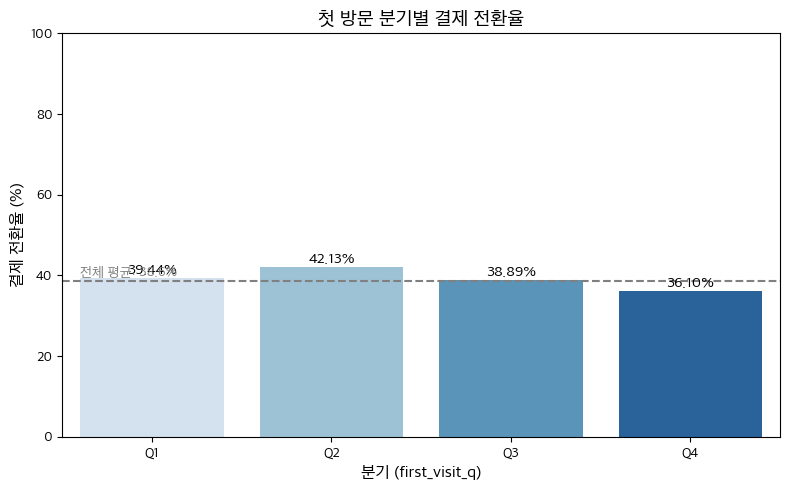

In [122]:
# Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
conversion_by_q = user.groupby('first_visit_q')['is_payment'].mean().round(4) * 100
conversion_by_q = conversion_by_q.sort_index()

# Ï†ÑÏ≤¥ ÌèâÍ∑† Ï†ÑÌôòÏú®
avg_conversion = user['is_payment'].mean() * 100

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_by_q.index, y=conversion_by_q.values, palette='Blues')

# ÎùºÎ≤® ÌëúÏãú
for i, val in enumerate(conversion_by_q.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=11)

# Ï†ÑÏ≤¥ ÌèâÍ∑† Í∏∞Ï§ÄÏÑ†
plt.axhline(avg_conversion, color='gray', linestyle='--')
plt.text(-0.4, avg_conversion + 1, f'Ï†ÑÏ≤¥ ÌèâÍ∑†: {avg_conversion:.1f}%', color='gray')

# Íæ∏ÎØ∏Í∏∞
plt.title("Ï≤´ Î∞©Î¨∏ Î∂ÑÍ∏∞Î≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú®", fontsize=14)
plt.xlabel("Î∂ÑÍ∏∞ (first_visit_q)", fontsize=12)
plt.ylabel("Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### Ï≤´ Î∞©Î¨∏ Í≥ÑÏ†à (`first_visit_season`)

In [123]:
def month_to_season(m):
    if m in [12, 1, 2]: return '4'
    if m in [3, 4, 5]: return '1'
    if m in [6, 7, 8]: return '2'
    return '3'

user['first_visit_season'] = user['first_visit_month'].apply(month_to_season)

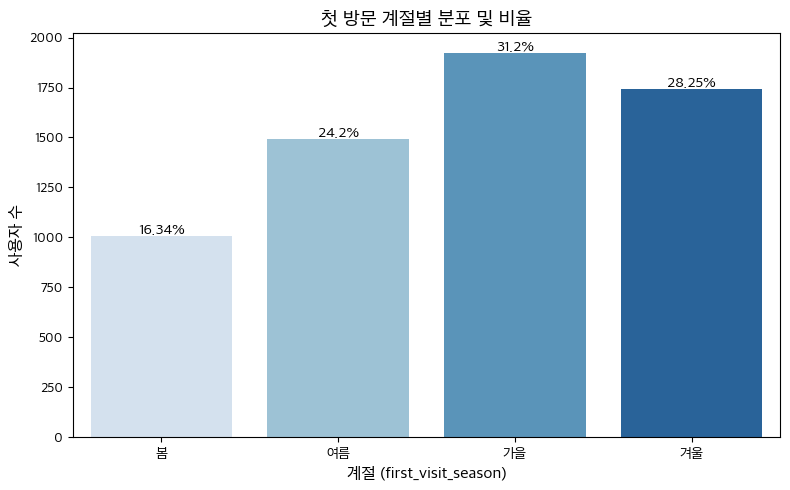

In [124]:
# Î∂ÑÌè¨ Í≥ÑÏÇ∞
season_counts = user['first_visit_season'].value_counts().sort_index()
season_percent = (season_counts / season_counts.sum() * 100).round(2)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.barplot(x=season_counts.index, y=season_counts.values, palette='Blues')

# Í∞í ÎùºÎ≤® ÌëúÏãú
for i, (count, percent) in enumerate(zip(season_counts, season_percent)):
    plt.text(i, count + 10, f"{percent}%", ha='center', fontsize=11)

# Íæ∏ÎØ∏Í∏∞
plt.title("Ï≤´ Î∞©Î¨∏ Í≥ÑÏ†àÎ≥Ñ Î∂ÑÌè¨ Î∞è ÎπÑÏú®", fontsize=14)
plt.xlabel("Í≥ÑÏ†à (first_visit_season)", fontsize=12)
plt.ylabel("ÏÇ¨Ïö©Ïûê Ïàò", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Î¥Ñ', 'Ïó¨Î¶Ñ', 'Í∞ÄÏùÑ', 'Í≤®Ïö∏'])
plt.tight_layout()
plt.show()

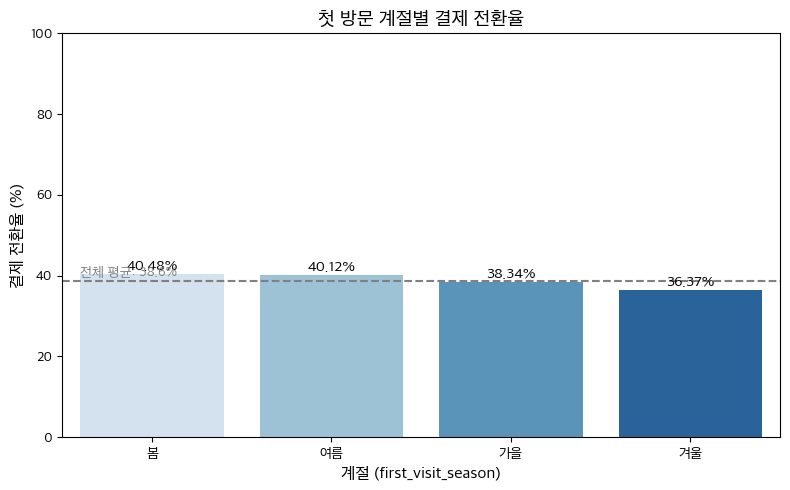

In [125]:
# Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
conversion_by_season = user.groupby('first_visit_season')['is_payment'].mean().round(4) * 100
conversion_by_season = conversion_by_season.sort_index()

# Ï†ÑÏ≤¥ ÌèâÍ∑† Ï†ÑÌôòÏú®
avg_conversion = user['is_payment'].mean() * 100

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_by_season.index, y=conversion_by_season.values, palette='Blues')

# ÎùºÎ≤® ÌëúÏãú
for i, val in enumerate(conversion_by_season.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=11)

# Ï†ÑÏ≤¥ ÌèâÍ∑† Í∏∞Ï§ÄÏÑ†
plt.axhline(avg_conversion, color='gray', linestyle='--')
plt.text(-0.4, avg_conversion + 1, f'Ï†ÑÏ≤¥ ÌèâÍ∑†: {avg_conversion:.1f}%', color='gray')

# Íæ∏ÎØ∏Í∏∞
plt.title("Ï≤´ Î∞©Î¨∏ Í≥ÑÏ†àÎ≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú®", fontsize=14)
plt.xlabel("Í≥ÑÏ†à (first_visit_season)", fontsize=12)
plt.ylabel("Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Î¥Ñ', 'Ïó¨Î¶Ñ', 'Í∞ÄÏùÑ', 'Í≤®Ïö∏'])
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### Ïù¥ÏßÑ ÌååÏÉùÎ≥ÄÏàò: Ï†ÑÌôòÏú® ÎÜíÏùÄ Ïõî (`high_convert_month`)

In [126]:
user['high_convert_month'] = user['first_visit_month'].isin([5, 6, 10]).astype(int)

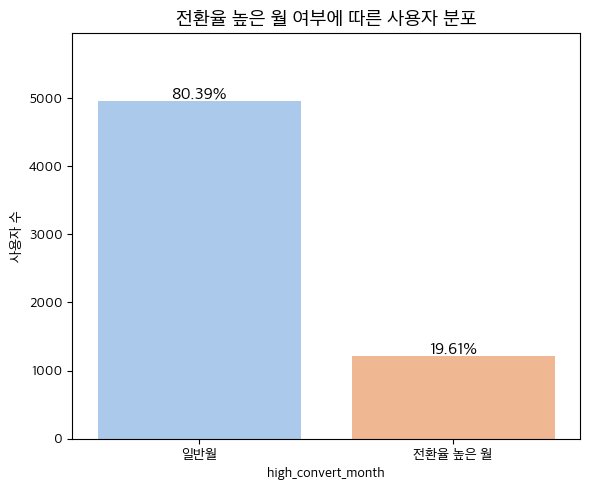

In [127]:
# 1. Í∞íÍ≥º ÎπÑÏú® Í≥ÑÏÇ∞
counts = user['high_convert_month'].value_counts().sort_index()
percent = (counts / counts.sum() * 100).round(2)

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 5))
sns.barplot(x=counts.index.map({0: 'ÏùºÎ∞òÏõî', 1: 'Ï†ÑÌôòÏú® ÎÜíÏùÄ Ïõî'}), y=counts.values, palette='pastel')

# 3. ÎπÑÏú® ÌÖçÏä§Ìä∏ ÌëúÏãú
for i, (count, pct) in enumerate(zip(counts, percent)):
    plt.text(i, count + 20, f'{pct:.2f}%', ha='center', fontsize=12)

# 4. ÎùºÎ≤® Î∞è Íæ∏ÎØ∏Í∏∞
plt.title('Ï†ÑÌôòÏú® ÎÜíÏùÄ Ïõî Ïó¨Î∂ÄÏóê Îî∞Î•∏ ÏÇ¨Ïö©Ïûê Î∂ÑÌè¨', fontsize=14)
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò')
plt.xlabel('high_convert_month')
plt.ylim(0, counts.max() * 1.2)
plt.tight_layout()
plt.show()

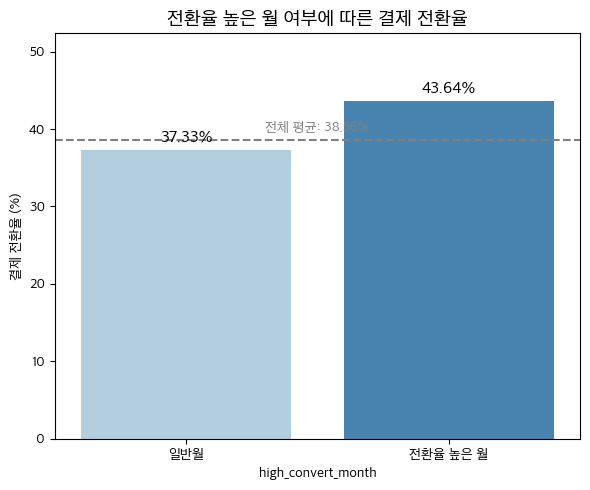

In [128]:
# 1. Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
conversion_rate = user.groupby('high_convert_month')['is_payment'].mean().mul(100).round(2)

# 2. Ï†ÑÏ≤¥ ÌèâÍ∑† Ï†ÑÌôòÏú®
overall_rate = user['is_payment'].mean() * 100

# 3. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 5))
sns.barplot(x=conversion_rate.index.map({0: 'ÏùºÎ∞òÏõî', 1: 'Ï†ÑÌôòÏú® ÎÜíÏùÄ Ïõî'}),
            y=conversion_rate.values, palette='Blues')

# 4. ÎùºÎ≤®ÎßÅ
for i, rate in enumerate(conversion_rate.values):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', fontsize=12)

# 5. Ï†ÑÏ≤¥ ÌèâÍ∑†ÏÑ†
plt.axhline(overall_rate, color='gray', linestyle='--')
plt.text(0.5, overall_rate + 1, f'Ï†ÑÏ≤¥ ÌèâÍ∑†: {overall_rate:.2f}%', ha='center', fontsize=10, color='gray')

# 6. Í∏∞ÌÉÄ ÏÑ§Ï†ï
plt.title('Ï†ÑÌôòÏú® ÎÜíÏùÄ Ïõî Ïó¨Î∂ÄÏóê Îî∞Î•∏ Í≤∞Ï†ú Ï†ÑÌôòÏú®', fontsize=14)
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)')
plt.xlabel('high_convert_month')
plt.ylim(0, max(conversion_rate.max(), overall_rate) * 1.2)
plt.tight_layout()
plt.show()

#### Ï≤´ Î∞©Î¨∏ ÏãúÍ∞Ñ (`first_visit_hour`)

In [129]:
# first_visit_hour ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±
user['first_visit_hour'] = user['first_visit'].dt.hour.astype('int64')

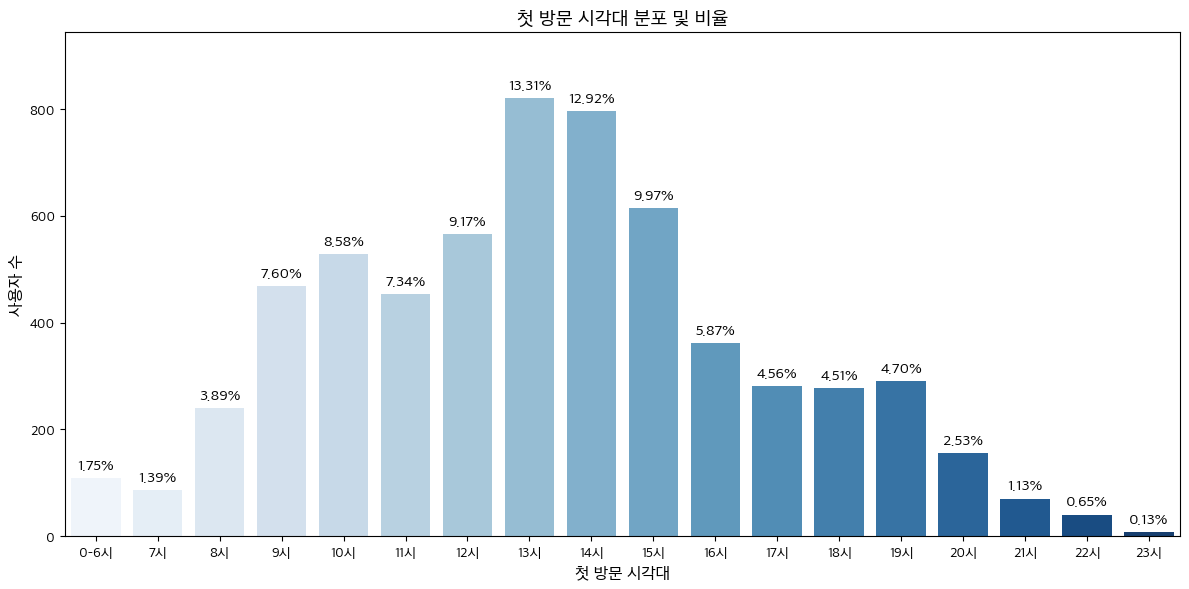

In [130]:
# 0. Î®ºÏ†Ä first_visit_hourÎ•º Í∏∞Î∞òÏúºÎ°ú ÏÉà ÏãúÍ∞ÅÎåÄ Í∑∏Î£π Î≥ÄÏàò ÏÉùÏÑ±
def map_hour_group(hour):
    return '0‚Äì6Ïãú' if hour <= 6 else f'{hour}Ïãú'

user['first_visit_hour_group'] = user['first_visit_hour'].apply(map_hour_group)

# 1. ÏõêÌïòÎäî ÏàúÏÑúÎåÄÎ°ú ÎùºÎ≤® Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
hour_labels = ['0‚Äì6Ïãú'] + [f'{h}Ïãú' for h in range(7, 24)]

# 2. ÎùºÎ≤®ÏùÑ CategoricalÎ°ú Î≥ÄÌôò (ÏàúÏÑú Î≥¥Ïû•)
hour_group = pd.Categorical(user['first_visit_hour_group'], categories=hour_labels, ordered=True)
user = user.drop(columns=['first_visit_hour_group'])

# 3. Í∞í Í≥ÑÏÇ∞ (Ï†ïÎ†¨ ÏûêÎèô Î≥¥Ïû•Îê®)
group_counts = hour_group.value_counts().sort_index()
group_percent = (group_counts / len(user) * 100).round(2)

# 4. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=group_counts.index, y=group_counts.values, palette='Blues')

# ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
for i, (count, percent) in enumerate(zip(group_counts, group_percent)):
    plt.text(i, count + (ax.get_ylim()[1] * 0.02), f'{percent:.2f}%', ha='center', fontsize=11)

plt.xlabel('Ï≤´ Î∞©Î¨∏ ÏãúÍ∞ÅÎåÄ', fontsize=12)
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=12)
plt.title('Ï≤´ Î∞©Î¨∏ ÏãúÍ∞ÅÎåÄ Î∂ÑÌè¨ Î∞è ÎπÑÏú®', fontsize=14)
plt.ylim(0, group_counts.max() * 1.15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

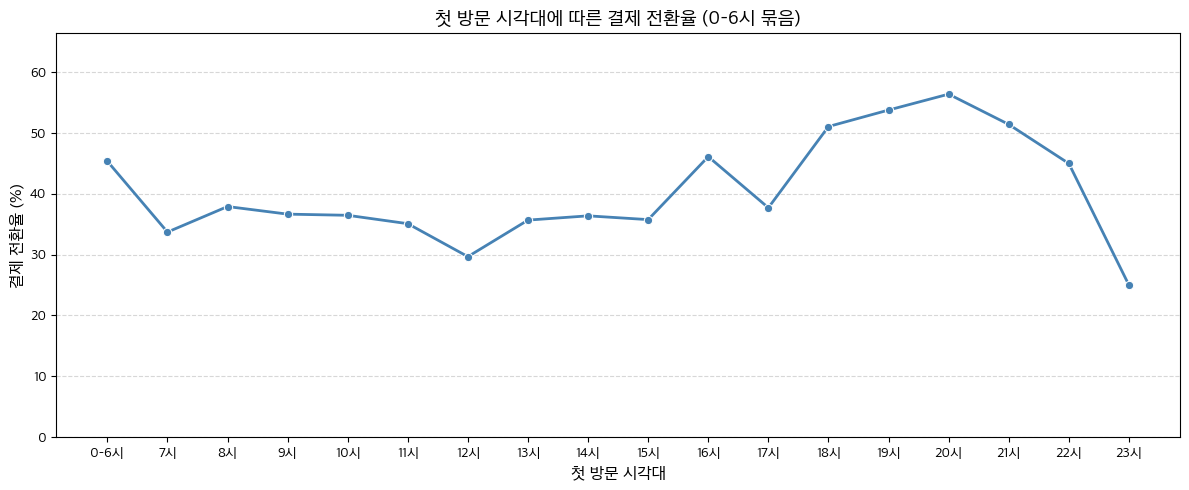

In [131]:
# 1. ÏãúÍ∞ÅÎåÄ Í∑∏Î£πÌôî Ìï®Ïàò
def group_hour(hour):
    return '0‚Äì6Ïãú' if hour in range(0, 7) else f'{hour}Ïãú'

# 2. Í∑∏Î£π ÎùºÎ≤® ÏÉùÏÑ± Î∞è ÏàúÏÑú ÏßÄÏ†ï
hour_group = user['first_visit_hour'].apply(group_hour)
hour_labels = ['0‚Äì6Ïãú'] + [f'{h}Ïãú' for h in range(7, 24)]
hour_group_cat = pd.Categorical(hour_group, categories=hour_labels, ordered=True)

# 3. Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
conversion = user.groupby(hour_group_cat)['is_payment'].mean().reset_index()
conversion.columns = ['first_visit_hour', 'conversion_rate']
conversion['conversion_rate'] = (conversion['conversion_rate'] * 100).round(2)

# 4. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 5))
sns.lineplot(x=conversion['first_visit_hour'], y=conversion['conversion_rate'],
             marker='o', linewidth=2, color='steelblue')

# 5. Íæ∏ÎØ∏Í∏∞
plt.xlabel('Ï≤´ Î∞©Î¨∏ ÏãúÍ∞ÅÎåÄ', fontsize=12)
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)', fontsize=12)
plt.title('Ï≤´ Î∞©Î¨∏ ÏãúÍ∞ÅÎåÄÏóê Îî∞Î•∏ Í≤∞Ï†ú Ï†ÑÌôòÏú® (0‚Äì6Ïãú Î¨∂Ïùå)', fontsize=14)
plt.ylim(0, conversion['conversion_rate'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- Ï†ÑÌôòÏú® Î∂ÑÏÑù Í≤∞Í≥º, 18Ïãú~21ÏãúÏóê Î∞©Î¨∏Ìïú ÏÇ¨Ïö©ÏûêÏùò Í≤∞Ï†ú Ï†ÑÌôòÏú®Ïù¥ Ïú†ÎèÖ ÎÜíÍ≤å ÎÇòÌÉÄÎÇ¨ÏäµÎãàÎã§.  
- Ï†ÄÎÖÅ ÏãúÍ∞ÑÎåÄ Î∞©Î¨∏ Ïó¨Î∂ÄÎäî Î™®Îç∏Ïùò ÏòàÏ∏°Î†•ÏùÑ ÎÜíÏù¥Îäî Îç∞ Í∏∞Ïó¨Ìï† Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.  
- Ïù¥Ïóê Îî∞Îùº Ìï¥Îãπ ÏãúÍ∞ÑÎåÄ Î∞©Î¨∏ Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÇ¥Îäî Ïù¥ÏßÑ Î≥ÄÏàò `evening_visit`ÏùÑ ÌååÏÉùÏãúÌÇµÎãàÎã§.

#### Ïù¥ÏßÑ ÌååÏÉùÎ≥ÄÏàò: Ï†ÄÎÖÅ Î∞©Î¨∏ (`evening_visit`)

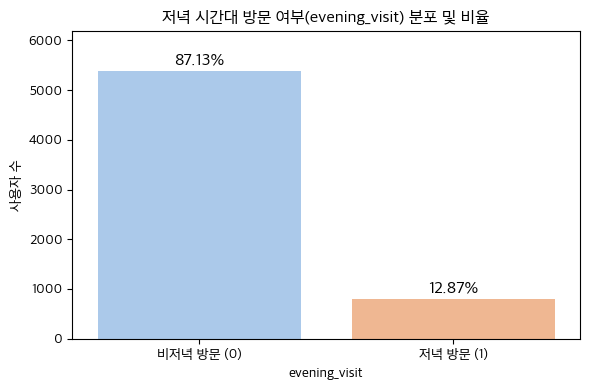

In [132]:
# 1. evening_visit ÌååÏÉù (18Ïãú~21Ïãú: 1, ÎÇòÎ®∏ÏßÄ: 0)
user['evening_visit'] = user['first_visit_hour'].isin([18, 19, 20, 21]).astype("int64")

# 2. Í∏∞Ï°¥ first_visit_hour Ïª¨Îüº Ï†úÍ±∞
user = user.drop(columns='first_visit_hour')

# 3. ÏÇ¨Ïö©Ïûê Ïàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
evening_counts = user['evening_visit'].value_counts().sort_index()
evening_percent = (evening_counts / len(user) * 100).round(2)

# 4. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=evening_counts.index, y=evening_counts.values, palette='pastel')

# 5. ÌÖçÏä§Ìä∏ ÌëúÏãú
for i, (count, percent) in enumerate(zip(evening_counts, evening_percent)):
    plt.text(i, count + (ax.get_ylim()[1] * 0.02), f'{percent}%', ha='center', fontsize=12)

# 6. Íæ∏ÎØ∏Í∏∞
plt.xticks([0, 1], ['ÎπÑÏ†ÄÎÖÅ Î∞©Î¨∏ (0)', 'Ï†ÄÎÖÅ Î∞©Î¨∏ (1)'])
plt.xlabel('evening_visit')
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò')
plt.title('Ï†ÄÎÖÅ ÏãúÍ∞ÑÎåÄ Î∞©Î¨∏ Ïó¨Î∂Ä(evening_visit) Î∂ÑÌè¨ Î∞è ÎπÑÏú®')
plt.ylim(0, evening_counts.max() * 1.15)
plt.tight_layout()
plt.show()

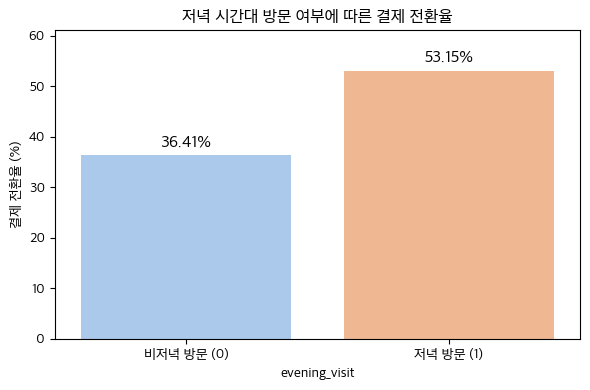

In [133]:
# 1. Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
evening_conversion = user.groupby('evening_visit')['is_payment'].mean().round(4) * 100

# 2. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=evening_conversion.index, y=evening_conversion.values, palette='pastel')

# 3. ÌÖçÏä§Ìä∏ ÌëúÏãú
for i, val in enumerate(evening_conversion.values):
    plt.text(i, val + (ax.get_ylim()[1] * 0.02), f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

# 4. Íæ∏ÎØ∏Í∏∞
plt.xticks([0, 1], ['ÎπÑÏ†ÄÎÖÅ Î∞©Î¨∏ (0)', 'Ï†ÄÎÖÅ Î∞©Î¨∏ (1)'])
plt.xlabel('evening_visit')
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)')
plt.title('Ï†ÄÎÖÅ ÏãúÍ∞ÑÎåÄ Î∞©Î¨∏ Ïó¨Î∂ÄÏóê Îî∞Î•∏ Í≤∞Ï†ú Ï†ÑÌôòÏú®')
plt.ylim(0, evening_conversion.max() * 1.15)
plt.tight_layout()
plt.show()

#### Ïù∏ÏÇ¨Ïù¥Ìä∏
- Ï†ÄÎÖÅ ÏãúÍ∞ÑÎåÄ(18Ïãú~21Ïãú) Î∞©Î¨∏ÏûêÎäî Ï†ÑÏ≤¥Ïùò 12.87%Ïóê Î∂àÍ≥ºÌïòÏßÄÎßå, Í≤∞Ï†ú Ï†ÑÌôòÏú®ÏùÄ 53.15%Î°ú Îß§Ïö∞ ÎÜíÏäµÎãàÎã§.  
- Ï†ÑÌôòÏú®Ïù¥ ÌèâÍ∑†Î≥¥Îã§ Ïú†ÏùòÌïòÍ≤å ÎÜíÏïÑ ÏòàÏ∏° Î™®Îç∏Ïùò Ï£ºÏöî ÌîºÏ≤òÎ°ú ÌôúÏö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.  

#### Ï≤´ Î∞©Î¨∏ ÏöîÏùº (`first_visit_dayofweek`)

In [134]:
# ÏöîÏùº ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ± (Ïõî=0, Ïùº=6 Í∏∞Ï§Ä)
user['first_visit_dayofweek'] = user['first_visit'].dt.dayofweek.astype('int64')

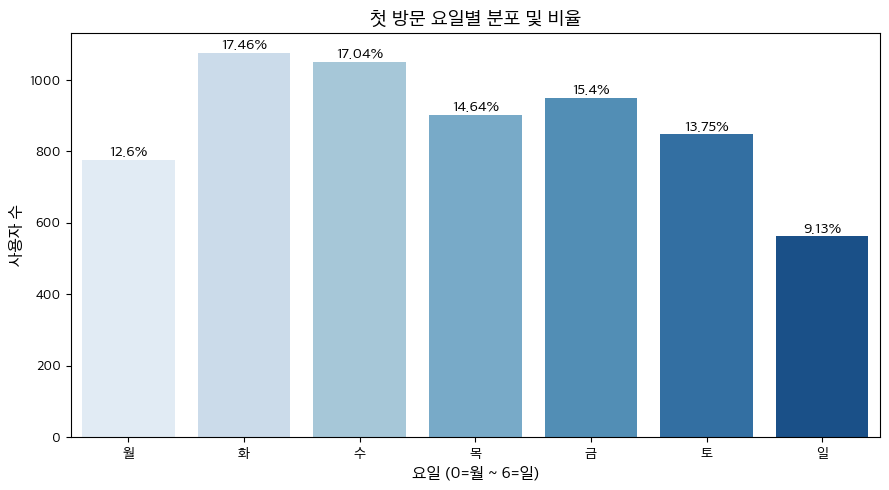

In [135]:
# ÏöîÏùº Ïù¥Î¶Ñ Îß§Ìïë
day_labels = ['Ïõî', 'Ìôî', 'Ïàò', 'Î™©', 'Í∏à', 'ÌÜ†', 'Ïùº']

# Î∂ÑÌè¨ Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
dow_counts = user['first_visit_dayofweek'].value_counts().sort_index()
dow_percent = (dow_counts / dow_counts.sum() * 100).round(2)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(9, 5))
sns.barplot(x=dow_counts.index, y=dow_counts.values, palette='Blues')

# ÎπÑÏú® ÎùºÎ≤® ÌëúÏãú
for i, (count, percent) in enumerate(zip(dow_counts, dow_percent)):
    plt.text(i, count + 10, f"{percent}%", ha='center', fontsize=11)

# Íæ∏ÎØ∏Í∏∞
plt.title("Ï≤´ Î∞©Î¨∏ ÏöîÏùºÎ≥Ñ Î∂ÑÌè¨ Î∞è ÎπÑÏú®", fontsize=14)
plt.xlabel("ÏöîÏùº (0=Ïõî ~ 6=Ïùº)", fontsize=12)
plt.ylabel("ÏÇ¨Ïö©Ïûê Ïàò", fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels)
plt.tight_layout()
plt.show()

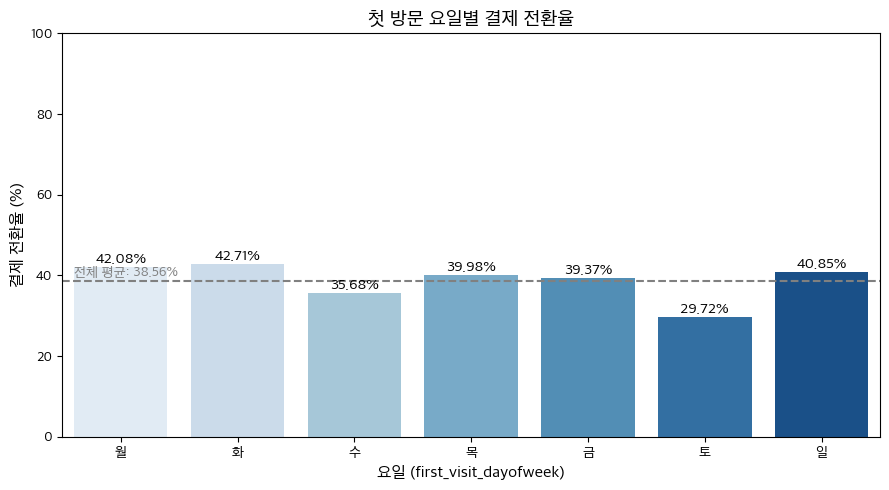

In [136]:
# ÏöîÏùº Ïù¥Î¶Ñ Îß§Ìïë
day_labels = ['Ïõî', 'Ìôî', 'Ïàò', 'Î™©', 'Í∏à', 'ÌÜ†', 'Ïùº']

# ÏöîÏùºÎ≥Ñ Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
conversion_by_dow = user.groupby('first_visit_dayofweek')['is_payment'].mean().round(4) * 100
conversion_by_dow = conversion_by_dow.sort_index()

# Ï†ÑÏ≤¥ ÌèâÍ∑† Ï†ÑÌôòÏú®
avg_conversion = user['is_payment'].mean() * 100

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(9, 5))
sns.barplot(x=conversion_by_dow.index, y=conversion_by_dow.values, palette='Blues')

# ÎπÑÏú® ÎùºÎ≤® ÌëúÏãú
for i, val in enumerate(conversion_by_dow.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=11)

# Ï†ÑÏ≤¥ ÌèâÍ∑† Í∏∞Ï§ÄÏÑ†
plt.axhline(avg_conversion, color='gray', linestyle='--')
plt.text(-0.4, avg_conversion + 1, f'Ï†ÑÏ≤¥ ÌèâÍ∑†: {avg_conversion:.2f}%', color='gray')

# Íæ∏ÎØ∏Í∏∞
plt.title("Ï≤´ Î∞©Î¨∏ ÏöîÏùºÎ≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú®", fontsize=14)
plt.xlabel("ÏöîÏùº (first_visit_dayofweek)", fontsize=12)
plt.ylabel("Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)", fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### Ïù¥ÏßÑ ÌååÏÉùÎ≥ÄÏàò: Ï†ÑÌôòÏú® ÎÜíÏùÄ ÏöîÏùº (`high_convert_dayofweek`)
- Ï†ÑÌôòÏú®Ïù¥ ÌäπÌûà ÎÜíÏùÄ ÌôîÏöîÏùº, ÏùºÏöîÏùº Ïó¨Î∂ÄÎ•º Íµ¨Î∂ÑÌïòÎäî ÌååÏÉùÎ≥ÄÏàòÎ•º ÏÉùÏÑ±Ìï©ÎãàÎã§.

In [137]:
user['high_convert_dayofweek'] = user['first_visit_dayofweek'].isin([1, 6]).astype(int)

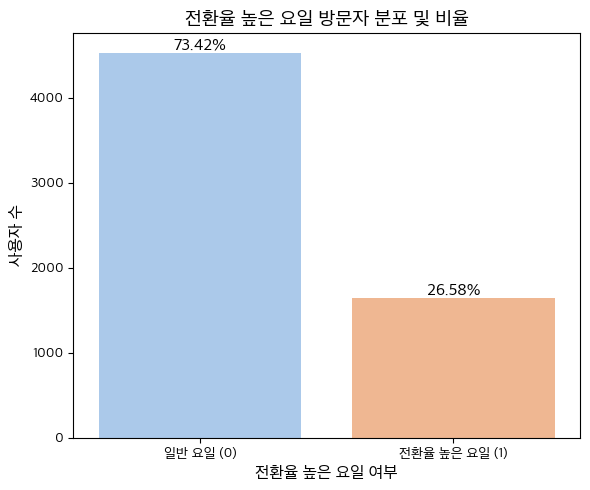

In [138]:
# Î∂ÑÌè¨ Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
day_flag_counts = user['high_convert_dayofweek'].value_counts().sort_index()
day_flag_percent = (day_flag_counts / day_flag_counts.sum() * 100).round(2)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 5))
sns.barplot(x=day_flag_counts.index, y=day_flag_counts.values, palette='pastel')

# Í∞í ÎùºÎ≤® ÌëúÏãú
labels = ['ÏùºÎ∞ò ÏöîÏùº (0)', 'Ï†ÑÌôòÏú® ÎÜíÏùÄ ÏöîÏùº (1)']
for i, (count, percent) in enumerate(zip(day_flag_counts, day_flag_percent)):
    plt.text(i, count + 30, f'{percent}%', ha='center', fontsize=12)

# Íæ∏ÎØ∏Í∏∞
plt.xticks([0, 1], labels)
plt.xlabel('Ï†ÑÌôòÏú® ÎÜíÏùÄ ÏöîÏùº Ïó¨Î∂Ä', fontsize=12)
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò', fontsize=12)
plt.title('Ï†ÑÌôòÏú® ÎÜíÏùÄ ÏöîÏùº Î∞©Î¨∏Ïûê Î∂ÑÌè¨ Î∞è ÎπÑÏú®', fontsize=14)
plt.tight_layout()
plt.show()

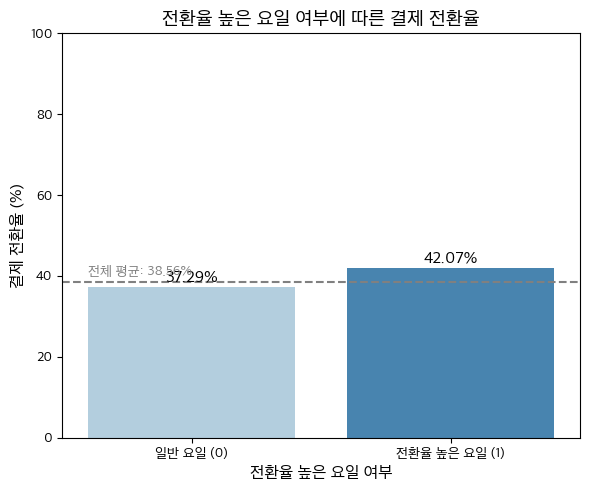

In [139]:
# Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
conversion_by_dayflag = user.groupby('high_convert_dayofweek')['is_payment'].mean().round(4) * 100
conversion_by_dayflag = conversion_by_dayflag.sort_index()

# Ï†ÑÏ≤¥ ÌèâÍ∑† Ï†ÑÌôòÏú®
avg_conversion = user['is_payment'].mean() * 100

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 5))
sns.barplot(x=conversion_by_dayflag.index, y=conversion_by_dayflag.values, palette='Blues')

# Í∞í ÎùºÎ≤® ÌëúÏãú
for i, val in enumerate(conversion_by_dayflag.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=12)

# Ï†ÑÏ≤¥ ÌèâÍ∑† Í∏∞Ï§ÄÏÑ†
plt.axhline(avg_conversion, color='gray', linestyle='--')
plt.text(-0.4, avg_conversion + 1.5, f'Ï†ÑÏ≤¥ ÌèâÍ∑†: {avg_conversion:.2f}%', color='gray')

# Íæ∏ÎØ∏Í∏∞
plt.xticks([0, 1], ['ÏùºÎ∞ò ÏöîÏùº (0)', 'Ï†ÑÌôòÏú® ÎÜíÏùÄ ÏöîÏùº (1)'])
plt.xlabel('Ï†ÑÌôòÏú® ÎÜíÏùÄ ÏöîÏùº Ïó¨Î∂Ä', fontsize=12)
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)', fontsize=12)
plt.title('Ï†ÑÌôòÏú® ÎÜíÏùÄ ÏöîÏùº Ïó¨Î∂ÄÏóê Îî∞Î•∏ Í≤∞Ï†ú Ï†ÑÌôòÏú®', fontsize=14)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### Ïù¥ÏßÑ ÌååÏÉùÎ≥ÄÏàò: Ï£ºÎßê Ï≤´ Î∞©Î¨∏ (`first_visit_is_weekend`)

In [140]:
# Ï£ºÎßê Ïó¨Î∂Ä ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ±: ÌÜ†(5), Ïùº(6)Ïù¥Î©¥ 1, ÏïÑÎãàÎ©¥ 0
user['first_visit_is_weekend'] = user['first_visit'].dt.dayofweek.isin([5, 6]).astype(int)

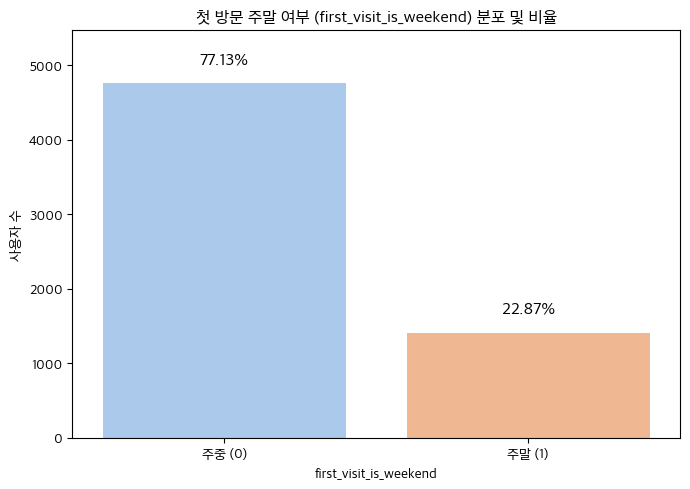

In [141]:
# 1. first_visit_is_weekend Í∞í Í≥ÑÏÇ∞
# value_counts()Î°ú Í∞Å Î≤îÏ£º(0: Ï£ºÏ§ë, 1: Ï£ºÎßê)Ïùò Í∞úÏàòÎ•º ÏÑ∏Í≥†, sort_index()Î°ú Ï†ïÎ†¨Ìï©ÎãàÎã§.
first_visit_weekend_counts = user['first_visit_is_weekend'].value_counts().sort_index()
# Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê Ïàò ÎåÄÎπÑ Í∞Å Î≤îÏ£ºÏùò ÎπÑÏú®ÏùÑ ÌçºÏÑºÌä∏Î°ú Í≥ÑÏÇ∞ÌïòÍ≥† ÏÜåÏàòÏ†ê ÎëòÏß∏ ÏûêÎ¶¨ÍπåÏßÄ Î∞òÏò¨Î¶ºÌï©ÎãàÎã§.
first_visit_weekend_percent = (first_visit_weekend_counts / len(user) * 100).round(2)

# 2. ÏãúÍ∞ÅÌôî (ÎßâÎåÄÍ∑∏ÎûòÌîÑ)
plt.figure(figsize=(7, 5)) # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞Î•º ÏÑ§Ï†ïÌï©ÎãàÎã§.
# seabornÏùò barplotÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÎßâÎåÄÍ∑∏ÎûòÌîÑÎ•º Í∑∏Î¶ΩÎãàÎã§.
# xÏ∂ïÏùÄ Î≤îÏ£º (0 ÎòêÎäî 1), yÏ∂ïÏùÄ Ìï¥Îãπ Î≤îÏ£ºÏùò ÏÇ¨Ïö©Ïûê ÏàòÏûÖÎãàÎã§.
ax = sns.barplot(x=first_visit_weekend_counts.index, y=first_visit_weekend_counts.values, palette='pastel')

# 3. Í∞Å ÎßâÎåÄ ÏúÑÏóê ÎπÑÏú® ÌÖçÏä§Ìä∏Î•º Ï∂îÍ∞ÄÌï©ÎãàÎã§.
for i, (count, percent) in enumerate(zip(first_visit_weekend_counts, first_visit_weekend_percent)):
    # ÌÖçÏä§Ìä∏ ÏúÑÏπòÎ•º ÎßâÎåÄ ÎÜíÏù¥Ïùò ÏïΩ 5% ÏúÑÎ°ú ÏÑ§Ï†ïÌïòÏó¨ Í≤πÏπòÏßÄ ÏïäÎèÑÎ°ù Ìï©ÎãàÎã§.
    plt.text(i, count + (ax.get_ylim()[1] * 0.05), f'{percent:.2f}%', ha='center', fontsize=12)

# 4. Í∑∏ÎûòÌîÑÎ•º Íæ∏Î∞âÎãàÎã§.
# xÏ∂ï Ìã± Î†àÏù¥Î∏îÏùÑ 'Ï£ºÏ§ë (0)'ÏôÄ 'Ï£ºÎßê (1)'Î°ú Î≥ÄÍ≤ΩÌïòÏó¨ ÏùòÎØ∏Î•º Î™ÖÌôïÌûà Ìï©ÎãàÎã§.
plt.xticks([0, 1], ['Ï£ºÏ§ë (0)', 'Ï£ºÎßê (1)'])
plt.ylabel('ÏÇ¨Ïö©Ïûê Ïàò') # yÏ∂ï Î†àÏù¥Î∏îÏùÑ ÏÑ§Ï†ïÌï©ÎãàÎã§.
plt.title('Ï≤´ Î∞©Î¨∏ Ï£ºÎßê Ïó¨Î∂Ä (first_visit_is_weekend) Î∂ÑÌè¨ Î∞è ÎπÑÏú®') # Í∑∏ÎûòÌîÑ Ï†úÎ™©ÏùÑ ÏÑ§Ï†ïÌï©ÎãàÎã§.
plt.ylim(0, first_visit_weekend_counts.max() * 1.15) # YÏ∂ï Î≤îÏúÑÎ•º Ï°∞Ï†ïÌïòÏó¨ ÌÖçÏä§Ìä∏Í∞Ä Ïûò Î≥¥Ïù¥ÎèÑÎ°ù Ìï©ÎãàÎã§.
plt.tight_layout() # Í∑∏ÎûòÌîÑ ÏöîÏÜåÎì§Ïù¥ Ïûò Î≥¥Ïù¥ÎèÑÎ°ù Î†àÏù¥ÏïÑÏõÉÏùÑ ÏûêÎèôÏúºÎ°ú Ï°∞Ï†ïÌï©ÎãàÎã§.
plt.show() # Í∑∏ÎûòÌîÑÎ•º ÌôîÎ©¥Ïóê ÌëúÏãúÌï©ÎãàÎã§.


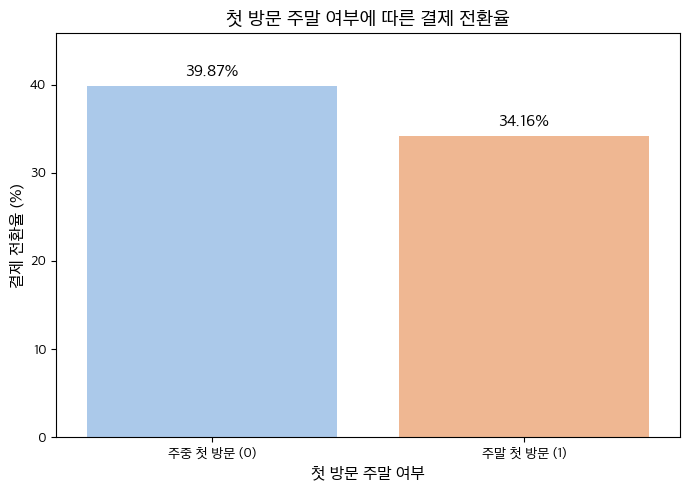

In [142]:
# 1. first_visit_is_weekend Î≥Ñ Í≤∞Ï†ú Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
first_visit_weekend_conversion = user.groupby('first_visit_is_weekend')['is_payment'].mean().round(4) * 100

# 2. ÏãúÍ∞ÅÌôî (ÎßâÎåÄÍ∑∏ÎûòÌîÑ)
plt.figure(figsize=(7, 5))
ax = sns.barplot(x=first_visit_weekend_conversion.index, y=first_visit_weekend_conversion.values, palette='pastel')

# 3. ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä (ÎßâÎåÄ ÏúÑÏóê Î∞∞Ïπò)
for i, val in enumerate(first_visit_weekend_conversion.values):
    plt.text(i, val + (ax.get_ylim()[1] * 0.02), f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

# 4. Í∑∏ÎûòÌîÑÎ•º Íæ∏Î∞âÎãàÎã§.
plt.xlabel('Ï≤´ Î∞©Î¨∏ Ï£ºÎßê Ïó¨Î∂Ä', fontsize=12)
plt.ylabel('Í≤∞Ï†ú Ï†ÑÌôòÏú® (%)', fontsize=12)
plt.title('Ï≤´ Î∞©Î¨∏ Ï£ºÎßê Ïó¨Î∂ÄÏóê Îî∞Î•∏ Í≤∞Ï†ú Ï†ÑÌôòÏú®', fontsize=14)
plt.ylim(0, first_visit_weekend_conversion.max() * 1.15 if not first_visit_weekend_conversion.empty else 10)
plt.xticks([0, 1], ['Ï£ºÏ§ë Ï≤´ Î∞©Î¨∏ (0)', 'Ï£ºÎßê Ï≤´ Î∞©Î¨∏ (1)'])
plt.tight_layout()
plt.show()

In [143]:
from statsmodels.stats.proportion import proportions_ztest

# Ï£ºÏ§ë (0) vs Ï£ºÎßê (1) Í∑∏Î£πÏùò ÏÑ±Í≥µ(1) ÏàòÏôÄ Ï†ÑÏ≤¥ Ïàò
success = user.groupby('first_visit_is_weekend')['is_payment'].sum().values
nobs = user.groupby('first_visit_is_weekend')['is_payment'].count().values

# Z-test Ïã§Ìñâ
z_stat, p_val = proportions_ztest(count=success, nobs=nobs)

print(f"Z-statistic = {z_stat:.3f}")
print(f"P-value = {p_val:.4f}")

Z-statistic = 3.870
P-value = 0.0001


#### Ïù∏ÏÇ¨Ïù¥Ìä∏
- Ï£ºÏ§ë Î∞©Î¨∏ Í≥†Í∞ùÏùò ÎÜíÏùÄ Ï†ÑÌôò Ïû†Ïû¨Î†•: Í≥µÏú†Ïò§ÌîºÏä§ Ï£ºÏ§ë Î∞©Î¨∏ Í≥†Í∞ùÏùÄ Ï£ºÎßê Î∞©Î¨∏ Í≥†Í∞ùÎ≥¥Îã§ Í≤∞Ï†ú Ï†ÑÌôòÏú®Ïù¥ ÏïΩ  5.71%p Îçî ÎÜíÏäµÎãàÎã§.
- ÎßàÏºÄÌåÖ Ï†ÑÎûµ Ï∞®Î≥ÑÌôî: Ï£ºÏ§ë Í≥†Í∞ùÏùÄ ÎÜíÏùÄ Ï†ÑÌôòÏú® Ïú†ÏßÄÎ•º ÏúÑÌïú ÏµúÏ†ÅÌôîÎêú Ïò®Î≥¥Îî© Î∞è ÌîÑÎ°úÎ™®ÏÖòÏùÑ, Ï£ºÎßê Í≥†Í∞ùÏùÄ ÎßûÏ∂§Ìòï Í∞ÄÏπò Ï†úÏïàÏúºÎ°ú Ï†ÑÌôòÏú® Ìñ•ÏÉÅ Î∞©ÏïàÏùÑ Î™®ÏÉâÌï¥Ïïº Ìï©ÎãàÎã§.
- Î¶¨ÏÜåÏä§ ÏßëÏ§ë: Ïã†Í∑ú Í≥†Í∞ù Ïú†Ïπò Î∞è Ï†ÑÌôò Î¶¨ÏÜåÏä§Î•º Ï£ºÏ§ë Î∞©Î¨∏ Í≥†Í∞ùÏóêÍ≤å ÏßëÏ§ëÌïòÍ≥†, Ï£ºÎßê Í≥†Í∞ùÏùÑ ÏúÑÌïú ÎßûÏ∂§Ìòï Ï†ÑÎûµ Í∞úÎ∞úÏóê Ìà¨ÏûêÌïòÏó¨ Ìö®Ïú®ÏÑ±ÏùÑ ÎÜíÏùº Ïàò ÏûàÏäµÎãàÎã§.

#### Ïù¥ÏßÑ ÌååÏÉùÎ≥ÄÏàò: ÌòºÏû°Ìïú ÏãúÍ∞ÑÎåÄ (`peak_top5`)

In [150]:
user['first_visit_hour'] = user.first_visit.apply(lambda x: x.hour)
is_payment_hour_cnt = user.query('is_payment == 1')['first_visit_hour'].value_counts().sort_values(ascending=False)
is_payment_hour_cnt_df = pd.DataFrame(is_payment_hour_cnt, columns=['count'])

hour_counts = user['first_visit_hour'].value_counts().sort_values(ascending=False)
hour_counts_df = pd.DataFrame(hour_counts, columns=['count'])

display(is_payment_hour_cnt_df.head(10))
display(hour_counts_df.head(10))

count
first_visit_hour       
13                  293
14                  290
15                  220
10                  193
9                   172
12                  168
16                  167
11                  159
19                  156
18                  142

count
first_visit_hour       
13                  821
14                  797
15                  615
12                  566
10                  529
9                   469
11                  453
16                  362
19                  290
17                  281

In [151]:
# ÌòºÏû°Ìïú ÏãúÍ∞ÑÎåÄ top5 ÏïàÏóê ÏûàÏúºÎ©¥ 1, ÏïÑÎãêÏãú 0
hour_rank_map = {hour: rank+1 for rank, hour in enumerate(hour_counts.index)}
user['visit_peak_rank'] = user['first_visit_hour'].map(hour_rank_map)
user['peak_top5'] = user['visit_peak_rank'].apply(lambda x: 1 if x <= 5 else 0).fillna(0).astype(int)
user = user.drop(columns='visit_peak_rank')

- Ï≤´ Î∞©Î¨∏ ÏãúÍ∞ÑÎåÄÍ∞Ä ÏÇ¨Ïö©ÏûêÍ∞Ä Î™∞Î¶¨Îäî ÌòºÏû°Ìïú ÏãúÍ∞ÑÎåÄÏùºÏàòÎ°ù Ïú†Î£å Ï†ÑÌôòÏú®Ïù¥ ÎÜíÎã§Îäî Ìå®ÌÑ¥Ïù¥ Í¥ÄÏ∞∞Îê®
- Ïù¥Ïóê Îî∞Îùº, ÌòºÏû°ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏãúÍ∞ÑÎåÄÎ•º 4Îã®Í≥ÑÎ°ú Íµ¨Î∂ÑÌïú Î≤îÏ£ºÌòï Î≥ÄÏàòÎ°ú Î≥ÄÌôòÌïòÏó¨, Ìï¥Îãπ Î≥ÄÏàòÎ•º Ïú†Î£å Ï†ÑÌôò Ïó¨Î∂ÄÎ•º ÏòàÏ∏°ÌïòÎäî Ïù¥ÏßÑ Î∂ÑÎ•ò Î™®Îç∏Ïùò Ï£ºÏöî ÌîºÏ≤òÎ°ú ÌôúÏö©

In [152]:
user.head()

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   
2  2ba8ab19-2d40-4423-ad04-f0f9ca814871 2023-12-21 21:31:16   
3  1d49ba36-6c23-405b-9514-aa7f4aeceff0 2023-12-21 21:16:39   
4  b2d80cf6-2ced-4270-9d7a-43119bba35d2 2023-12-22 15:37:55   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   
2 2023-12-21 22:50:51               2               1     1           0   
3 2023-12-21 22:50:56               2               1     1           0   
4 2023-12-22 17:59:12               2               2     1           0   

  trial_date  visit_delay_days  mean_checkins_per_day  mean_checkins_level  \
0 2023-12-21                 0                    6.0                    3   
1 2023-12-21                 0                    2.0                    2   
2 2023-12-21                 0                    2.0                    2   
3 2023-12-21                 0                    2.0                    2   
4 2023-12-22                 0                    2.0                    2   

   frequent_checkins  mean_stay_time_hour  mean_stay_time_level  long_stay  \
0                  1                  5.0                     2          1   
1                  0                  3.0                     2          0   
2                  0                  1.0                     1          0   
3                  0                  1.0                     1          0   
4                  0                  2.0                     1          0   

   first_visit_month  first_visit_q  first_visit_season  high_convert_month  \
0                 12              4                   4                   0   
1                 12              4                   4                   0   
2                 12              4                   4                   0   
3                 12              4                   4                   0   
4                 12              4                   4                   0   

   evening_visit  first_visit_dayofweek  high_convert_dayofweek  \
0              0                      3                       0   
1              0                      3                       0   
2              1                      3                       0   
3              1                      3                       0   
4              0                      4                       0   

   first_visit_is_weekend  first_visit_hour  peak_top5  
0                       0                 9          0  
1                       0                 4          0  
2                       0                21          0  
3                       0                21          0  
4                       0                15          1

In [153]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_uuid               6169 non-null   object        
 1   first_visit             6169 non-null   datetime64[ns]
 2   last_visit              6169 non-null   datetime64[ns]
 3   total_checkins          6169 non-null   int64         
 4   stay_time_hour          6169 non-null   int64         
 5   days                    6169 non-null   int64         
 6   is_payment              6169 non-null   int64         
 7   trial_date              6169 non-null   datetime64[ns]
 8   visit_delay_days        6169 non-null   int64         
 9   mean_checkins_per_day   6169 non-null   float64       
 10  mean_checkins_level     6169 non-null   int64         
 11  frequent_checkins       6169 non-null   int64         
 12  mean_stay_time_hour     6169 non-null   float64 

In [154]:
user.to_csv('user.csv', index=False)

In [5]:
user = pd.read_csv('user.csv', parse_dates=['first_visit', 'last_visit', 'trial_date'])
user.head()

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   
2  2ba8ab19-2d40-4423-ad04-f0f9ca814871 2023-12-21 21:31:16   
3  1d49ba36-6c23-405b-9514-aa7f4aeceff0 2023-12-21 21:16:39   
4  b2d80cf6-2ced-4270-9d7a-43119bba35d2 2023-12-22 15:37:55   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   
2 2023-12-21 22:50:51               2               1     1           0   
3 2023-12-21 22:50:56               2               1     1           0   
4 2023-12-22 17:59:12               2               2     1           0   

  trial_date  visit_delay_days  mean_checkins_per_day  ...  first_visit_month  \
0 2023-12-21                 0                    6.0  ...                 12   
1 2023-12-21                 0                    2.0  ...                 12   
2 2023-12-21                 0                    2.0  ...                 12   
3 2023-12-21                 0                    2.0  ...                 12   
4 2023-12-22                 0                    2.0  ...                 12   

   first_visit_q  first_visit_season  high_convert_month  evening_visit  \
0              4                   4                   0              0   
1              4                   4                   0              0   
2              4                   4                   0              1   
3              4                   4                   0              1   
4              4                   4                   0              0   

   first_visit_dayofweek  high_convert_dayofweek  first_visit_is_weekend  \
0                      3                       0                       0   
1                      3                       0                       0   
2                      3                       0                       0   
3                      3                       0                       0   
4                      4                       0                       0   

   first_visit_hour  peak_top5  
0                 9          0  
1                 4          0  
2                21          0  
3                21          0  
4                15          1  

[5 rows x 25 columns]

# 3. Î™®Îç∏ÎßÅ

## 3.1 Î™®Îç∏ÎßÅ Ï§ÄÎπÑ

### 3.1.1 ÌôòÍ≤ΩÏÑ§Ï†ï

In [5]:
sns.set_theme(
    style='white',
    font='Apple SD Gothic Neo', 
    palette='pastel',
    rc={
        'axes.unicode_minus': False, 
        'figure.figsize': (12, 6),   
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'axes.titleweight': 'bold',
        'axes.titlesize': 16
    }
)


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

### 3.1.2 ÌèâÍ∞Ä Ìï®Ïàò ÏÉùÏÑ±

In [6]:
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_auc_score, 
                            confusion_matrix
)


def get_clf_eval(y_test, pred=None, pred_proba=None):
    conf_matix = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print(f"Ïò§Ï∞®ÌñâÎ†¨:\n{conf_matix}")
    print(f"\nÏ†ïÌôïÎèÑ: {accuracy:.4f}\nÏ†ïÎ∞ÄÎèÑ: {precision:.4f}\nÏû¨ÌòÑÏú®: {recall:.4f}\nf1_score: {f1:.4f}\nroc_auc: {roc_auc:.4f}")

### 3.1.3 ÌõàÎ†®-ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨

In [7]:
X = user.drop(columns=['user_uuid', 'is_payment', 'first_visit', 'last_visit', 'trial_date'])
y = user['is_payment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=151)

## 3.2 Î≤†Ïù¥Ïä§ ÎùºÏù∏ Î™®Îç∏: <font color='tomato'>LogisticRegression</font>

### 3.2.1 Í∏∞Î≥∏ Î™®Îç∏

- LogisticRegressionÏùÑ ÏÑ†Ï†ïÌïú Ïù¥Ïú†Îäî Ìï¥ÏÑùÏù¥ ÏßÅÍ¥ÄÏ†ÅÏù¥Í≥† Î™ÖÌôïÌïòÎ©∞, Îã®ÏàúÌïòÍ≥† Îπ†Î•¥Í≤å ÌïôÏäµÏù¥ Í∞ÄÎä•Ìï¥ ÏÑ±Îä• ÎπÑÍµê Í∏∞Ï§ÄÏ†êÏùÑ Ï†úÍ≥µÌïúÎã§Í≥† ÌåêÎã®

In [8]:
# Î≤†Ïù¥Ïä§ÎùºÏù∏ Î°úÏßÄÏä§Ìã±ÌöåÍ∑Ä Î™®Îç∏ Ï†ïÏùò
lr_clf_b = LogisticRegression(max_iter=1000, random_state=151)

# MLflow Ïã§Ìóò Í∏∞Î°ù
mlflow.set_experiment("logistic_regression_experiment")

with mlflow.start_run(run_name='baseline_model'):
    lr_clf_b.fit(X_train, y_train)
    lr_b_pred = lr_clf_b.predict(X_test)
    lr_b_pred_proba = lr_clf_b.predict_proba(X_test)[:, 1]

    # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
    get_clf_eval(y_test, lr_b_pred, lr_b_pred_proba)

    # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
    accuracy = np.round(accuracy_score(y_test, lr_b_pred), 4)
    precision = np.round(precision_score(y_test, lr_b_pred), 4)
    recall = np.round(recall_score(y_test, lr_b_pred), 4)
    f1 = np.round(f1_score(y_test, lr_b_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, lr_b_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞
    mlflow.log_params({
        "model_type": "LogisticRegression",
        "max_iter": 1000
    })

    # ÌèâÍ∞Ä ÏßÄÌëú
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

Ïò§Ï∞®ÌñâÎ†¨:
[[990 147]
 [531 183]]

Ï†ïÌôïÎèÑ: 0.6337
Ï†ïÎ∞ÄÎèÑ: 0.5545
Ïû¨ÌòÑÏú®: 0.2563
f1_score: 0.3506
roc_auc: 0.6020


- MLflowÎ°ú Ïã§Ìóò Í≥ºÏ†ïÏùÑ Í∏∞Î°ùÌïòÏó¨ Ï∂îÌõÑ ÎπÑÍµêÎ•º ÏúÑÌïú Í∏∞Ï§ÄÏ†êÏùÑ ÎßàÎ†®
- LogisticRegressionÏùÑ ÌôúÏö©Ìïú Ï≤´ Ïã§ÌóòÏóêÏÑú F1 ScoreÎäî 0.3506ÏúºÎ°ú, Ï†ïÎ∞ÄÎèÑÎäî ÏñëÌò∏ÌïòÎÇò Ïû¨ÌòÑÏú®Ïù¥ ÎÇÆÏïÑ ÏñëÏÑ± ÌÅ¥ÎûòÏä§ ÌÉêÏßÄ ÏÑ±Îä•ÏùÄ Ï†úÌïúÏ†ÅÏù¥ÏòÄÏùå

### 3.2.2 ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Î≥¥Ï†ïÏùÑ ÏúÑÌïú ÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ï†ï

In [9]:
with mlflow.start_run(run_name='class_weight_balanced'):
    lr_clf_m1 = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', random_state=151)

    lr_clf_m1.fit(X_train, y_train)
    lr_m1_pred = lr_clf_m1.predict(X_test)
    lr_m1_pred_proba = lr_clf_m1.predict_proba(X_test)[:, 1]

    # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
    get_clf_eval(y_test, lr_m1_pred, lr_b_pred_proba)

    # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
    accuracy = np.round(accuracy_score(y_test, lr_m1_pred), 4)
    precision = np.round(precision_score(y_test, lr_m1_pred), 4)
    recall = np.round(recall_score(y_test, lr_m1_pred), 4)
    f1 = np.round(f1_score(y_test, lr_m1_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, lr_m1_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞
    mlflow.log_params({
        "model_type": "LogisticRegression",
        "max_iter": 1000,
        "class_weight": "balanced",
        "solver": "liblinear"
    })

    # ÌèâÍ∞Ä ÏßÄÌëú
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

Ïò§Ï∞®ÌñâÎ†¨:
[[714 423]
 [342 372]]

Ï†ïÌôïÎèÑ: 0.5867
Ï†ïÎ∞ÄÎèÑ: 0.4679
Ïû¨ÌòÑÏú®: 0.5210
f1_score: 0.4930
roc_auc: 0.6020


- class_weight='balanced' ÏòµÏÖòÏùÑ Ï†ÅÏö© ÌõÑ Ïû¨ÌòÑÏú®Ïù¥ 0.510ÏúºÎ°ú ÌÅ¨Í≤å Ìñ•ÏÉÅÎêòÏóàÏúºÎ©∞, F1 ScoreÎèÑ 0.4930ÏúºÎ°ú Í∞úÏÑ†
- Ï†ïÌôïÎèÑÎäî ÌïòÎùΩÌñàÏßÄÎßå, ÏñëÏÑ± ÌÅ¥ÎûòÏä§ ÌÉêÏßÄ Îä•Î†•Ïù¥ 183ÏóêÏÑú 372Î°ú ÌÅ¨Í≤å Ìñ•ÏÉÅÎêòÏñ¥ Î∂àÍ∑†Ìòï Î¨∏Ï†ú ÏôÑÌôî Ìö®Í≥ºÍ∞Ä ÌôïÏù∏

### 3.2.3 max_iterÏôÄ CÎ•º ÌôúÏö©Ìïú Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä ÏÑ±Îä• ÌäúÎãù

In [10]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Í∞íÎì§
max_iter_list = [100, 300, 1000]
C_list = [0.01, 0.1, 1.0, 10.0]

for max_iter in max_iter_list:
    for C in C_list:
            lr_clf_m2 = LogisticRegression(
                                max_iter=max_iter,
                                C=C,
                                class_weight='balanced',
                                solver='liblinear',
                                random_state=151)

            lr_clf_m2.fit(X_train, y_train)
            lr_m2_pred = lr_clf_m2.predict(X_test)
            lr_m2_pred_proba = lr_clf_m2.predict_proba(X_test)[:, 1]

            # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
            get_clf_eval(y_test, lr_m2_pred, lr_b_pred_proba)

            # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
            accuracy = np.round(accuracy_score(y_test, lr_m2_pred), 4)
            precision = np.round(precision_score(y_test, lr_m2_pred), 4)
            recall = np.round(recall_score(y_test, lr_m2_pred), 4)
            f1 = np.round(f1_score(y_test, lr_m2_pred), 4)
            roc_auc = np.round(roc_auc_score(y_test, lr_m2_pred_proba), 4)

            # ÌååÎùºÎØ∏ÌÑ∞
            mlflow.log_params({
                "model_type": "LogisticRegression",
                "max_iter": 1000,
                "class_weight": "balanced",
                "solver": "liblinear"
            })

            # ÌèâÍ∞Ä ÏßÄÌëú
            mlflow.log_metrics({
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1_Score": f1,
                "Roc_Auc": roc_auc
            })

Ïò§Ï∞®ÌñâÎ†¨:
[[657 480]
 [304 410]]

Ï†ïÌôïÎèÑ: 0.5764
Ï†ïÎ∞ÄÎèÑ: 0.4607
Ïû¨ÌòÑÏú®: 0.5742
f1_score: 0.5112
roc_auc: 0.6020
Ïò§Ï∞®ÌñâÎ†¨:
[[697 440]
 [337 377]]

Ï†ïÌôïÎèÑ: 0.5802
Ï†ïÎ∞ÄÎèÑ: 0.4614
Ïû¨ÌòÑÏú®: 0.5280
f1_score: 0.4925
roc_auc: 0.6020
Ïò§Ï∞®ÌñâÎ†¨:
[[714 423]
 [342 372]]

Ï†ïÌôïÎèÑ: 0.5867
Ï†ïÎ∞ÄÎèÑ: 0.4679
Ïû¨ÌòÑÏú®: 0.5210
f1_score: 0.4930
roc_auc: 0.6020
Ïò§Ï∞®ÌñâÎ†¨:
[[720 417]
 [342 372]]

Ï†ïÌôïÎèÑ: 0.5900
Ï†ïÎ∞ÄÎèÑ: 0.4715
Ïû¨ÌòÑÏú®: 0.5210
f1_score: 0.4950
roc_auc: 0.6020
Ïò§Ï∞®ÌñâÎ†¨:
[[657 480]
 [304 410]]

Ï†ïÌôïÎèÑ: 0.5764
Ï†ïÎ∞ÄÎèÑ: 0.4607
Ïû¨ÌòÑÏú®: 0.5742
f1_score: 0.5112
roc_auc: 0.6020
Ïò§Ï∞®ÌñâÎ†¨:
[[697 440]
 [337 377]]

Ï†ïÌôïÎèÑ: 0.5802
Ï†ïÎ∞ÄÎèÑ: 0.4614
Ïû¨ÌòÑÏú®: 0.5280
f1_score: 0.4925
roc_auc: 0.6020
Ïò§Ï∞®ÌñâÎ†¨:
[[714 423]
 [342 372]]

Ï†ïÌôïÎèÑ: 0.5867
Ï†ïÎ∞ÄÎèÑ: 0.4679
Ïû¨ÌòÑÏú®: 0.5210
f1_score: 0.4930
roc_auc: 0.6020
Ïò§Ï∞®ÌñâÎ†¨:
[[720 417]
 [342 372]]

Ï†ïÌôïÎèÑ: 0.5900
Ï†ïÎ∞ÄÎèÑ: 0.4715
Ïû¨ÌòÑÏú®: 0.5210
f1_score: 0.4950
roc_auc: 0.6020


- Î∞òÎ≥µ ÌöüÏàò(max_iter)ÏôÄ Ï†ïÍ∑úÌôî Í∞ïÎèÑ(C)Î•º ÌäúÎãùÌïú Í≤∞Í≥º, Ïû¨ÌòÑÏú®Ïù¥ ÏµúÎåÄ 0.5724, F1_Score ÏµúÎåÄ 0.5112Î°ú Ï¶ùÍ∞ÄÌï¥ ÏñëÏÑ± ÌÅ¥ÎûòÏä§ ÌÉêÏßÄ ÏÑ±Îä•Ïù¥ Í∞úÏÑ†
- ROC AUCÎäî 0.6019 ÏàòÏ§ÄÏóêÏÑú Î≥ÄÌôîÍ∞Ä ÏóÜÏóàÏúºÎ©∞, Ï†ïÌôïÎèÑÎäî ÎåÄÏ≤¥Î°ú ÌïòÎùΩÌï¥ Ï†ÑÏ≤¥ Î∂ÑÎ•ò ÏÑ±Îä•ÏùÄ Îã§ÏÜå Ï†úÌïúÏ†Å

## 3.3 2Ï∞® ÏÑ†Ï†ï Î™®Îç∏: Random Forest Classifier

- Î°úÏßÄÏä§Ìã± ÌöåÍ∑ÄÎäî Ìï¥ÏÑùÏóêÎäî Ïú†Î¶¨ÌïòÏßÄÎßå ÏÑ†ÌòïÏ†ÅÏù∏ Í¥ÄÍ≥ÑÎßå Î∞òÏòÅÌïòÎäî ÌïúÍ≥ÑÍ∞Ä ÏûàÏñ¥ ÏÑ±Îä• Ìñ•ÏÉÅÏù¥ Ïñ¥Î†§Ïõ†Ïùå
- Ïù¥Ïóê Îî∞Îùº, Î≥ÄÏàò Í∞Ñ Î≥µÏû°Ìïú ÏÉÅÌò∏ÏûëÏö©Í≥º ÎπÑÏÑ†Ìòï Íµ¨Ï°∞Î•º Î∞òÏòÅÌï† Ïàò ÏûàÎäî Random Forest Î™®Îç∏ÏùÑ Ï†ÅÏö©ÌïòÏó¨ Î≥¥Îã§ Ï†ïÍµêÌïú ÏòàÏ∏°ÏùÑ ÏãúÎèÑ

### 3.3.1 Í∏∞Î≥∏ Î™®Îç∏

In [11]:
# 2Ï∞®Î°ú ÏÑ†Ï†ïÌïú RandomForestClassifier Î™®Îç∏ Ï†ïÏùò
rf_clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=151)

# MLflow
if mlflow.active_run():
    mlflow.end_run()
    
mlflow.set_experiment("random_forest_experiment")

with mlflow.start_run(run_name='second_model'):
    rf_clf.fit(X_train, y_train)
    rf_pred = rf_clf.predict(X_test)
    rf_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

    # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
    get_clf_eval(y_test, rf_pred, rf_pred_proba)

    # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
    accuracy = np.round(accuracy_score(y_test, rf_pred), 4)
    precision = np.round(precision_score(y_test, rf_pred), 4)
    recall = np.round(recall_score(y_test, rf_pred), 4)
    f1 = np.round(f1_score(y_test, rf_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, rf_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞
    mlflow.log_params({
        "model_type": "RandomForestClassifier",
        "class_weight": "balanced",
        "n_estimators": 1000
    })

    # ÌèâÍ∞Ä ÏßÄÌëú
    mlflow.log_metrics({
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1_Score": f1,
                "Roc_Auc": roc_auc
    })

Ïò§Ï∞®ÌñâÎ†¨:
[[890 247]
 [447 267]]

Ï†ïÌôïÎèÑ: 0.6251
Ï†ïÎ∞ÄÎèÑ: 0.5195
Ïû¨ÌòÑÏú®: 0.3739
f1_score: 0.4349
roc_auc: 0.6308


- Ï†ïÌôïÎèÑ 0.6251, F1 Score 0.4349Î°ú LogisticRegression ÎåÄÎπÑ Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú ÏïàÏ†ïÎêú ÏÑ±Îä•
- ROC_AUCÎäî 0.6019 ÏàòÏ§ÄÏóêÏÑú ÌÅ∞ Î≥ÄÌôîÍ∞Ä ÏóÜÏóàÏúºÎ©∞, Ï†ïÌôïÎèÑÎäî ÎåÄÏ≤¥Î°ú ÌïòÎùΩÌï¥ Ï†ÑÏ≤¥ Î∂ÑÎ•ò ÏÑ±Îä•ÏùÄ Îã§ÏÜå Ï†úÌïúÏ†Å

### 3.3.2 GridSearchCVÎ•º ÌÜµÌïú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù

In [12]:
# ÌäúÎãùÌï† ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Í∑∏Î¶¨Îìú Ï†ïÏùò
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30, 40, 50], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 8, 10]
}

# GridSearchCV ÏÑ§Ï†ï
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

with mlflow.start_run(run_name='second_model'):
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    rf_m_pred = best_rf.predict(X_test)
    rf_m_pred_proba = best_rf.predict_proba(X_test)[:, 1]

    # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
    get_clf_eval(y_test, rf_m_pred, rf_m_pred_proba)

    # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
    accuracy = np.round(accuracy_score(y_test, rf_m_pred), 4)
    precision = np.round(precision_score(y_test, rf_m_pred), 4)
    recall = np.round(recall_score(y_test, rf_m_pred), 4)
    f1 = np.round(f1_score(y_test, rf_m_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, rf_m_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞
    mlflow.log_params(grid_search.best_params_)

    # ÌèâÍ∞Ä ÏßÄÌëú
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Ïò§Ï∞®ÌñâÎ†¨:
[[848 289]
 [398 316]]

Ï†ïÌôïÎèÑ: 0.6288
Ï†ïÎ∞ÄÎèÑ: 0.5223
Ïû¨ÌòÑÏú®: 0.4426
f1_score: 0.4792
roc_auc: 0.6385


- GridSearchCVÎ•º ÌÜµÌï¥ ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º ÌÉêÏÉâÌïú Í≤∞Í≥º, F1_ScoreÍ∞Ä 0.4792Î°ú Í∞úÏÑ†ÎêòÍ≥† ROC_AUCÎèÑ 0.6385Î°ú ÏÉÅÏäπÌïòÎ©∞ Î™®Îç∏ ÏÑ±Îä•Ïù¥ Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú Ìñ•ÏÉÅÎêòÏóàÏùå.
- ÌäúÎãù Ï†ÑÎ≥¥Îã§ Ïû¨ÌòÑÏú® 0.4426 Î∞è Ï†ïÎ∞ÄÎèÑ 0.5223Ïùò Í∑†ÌòïÏù¥ Ï¢ãÏïÑÏ†∏ Ïã§Î¨¥ Ï†ÅÏö© Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏïÑÏßê.

## 3.4 3Ï∞® ÏÑ†Ï†ï Î™®Îç∏: XGBoost

- ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Î™®Îç∏Î°ú ÌïòÏù¥Ìçº ÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãùÍπåÏßÄ Ï†ÅÏö©ÌïòÏòÄÏßÄÎßå, Ï†ïÌôïÎèÑÏôÄ Ï†ïÎ∞ÄÎèÑ, ROC_AUC Ï†êÏàòÎäî Îã§ÏÜå ÏÉÅÌñ•ÎêòÏóàÏßÄÎßå, Ïû¨ÌòÑÏú®Í≥º F1_ScoreÍ∞Ä Í∏âÍ≤©ÌïòÍ≤å ÎÇÆÏïÑÏßêÏùÑ Î≥¥ÏòÄÏùå Îî∞ÎùºÏÑú ÏòàÏ∏° ÏÑ±Îä• Í∞úÏÑ†ÏùÑ ÏúÑÌï¥ Gradient Boosting Í∏∞Î∞òÏùò ÏïôÏÉÅÎ∏î Î™®Îç∏Ïù∏ XGBoost Î™®Îç∏ÏùÑ Îã§Ïùå ÌïôÏäµ Î™®Îç∏Î°ú ÏÑ†Ï†ï 
- XGBoostÎäî Í∞úÎ≥Ñ Ìä∏Î¶¨ Í∞ÑÏùò Ïò§Ï∞®Î•º Î≥¥ÏôÑÌïòÎäî Î∞©ÏãùÏúºÎ°ú ÌïôÏäµÏù¥ ÏßÑÌñâÎêòÏñ¥ Í≥ºÏ†ÅÌï© Î∞©ÏßÄ Î∞è ÏùºÎ∞òÌôî ÏÑ±Îä• Ìñ•ÏÉÅÏóê Í∞ïÏ†êÏûàÍ≥† ÎòêÌïú, Îã§ÏñëÌïú Ï†ïÍ∑úÌôî Î∞è Ï°∞Í∏∞ Ï¢ÖÎ£åÍ∏∞Î≤ïÏùÑ ÏßÄÏõêÌïòÎ©∞, ÎûúÎç§Ìè¨Î†àÏä§Ìä∏Î≥¥Îã§ ÏÑ∏Î∂Ä ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ï†ï Î≤îÏúÑÍ∞Ä ÎÑìÏñ¥ ÏÑ±Îä• Í∞úÏÑ† Ïó¨ÏßÄÍ∞Ä Îçî ÌÅ¨Îã§Í≥† ÌåêÎã®ÌïòÏó¨ ÌïôÏäµ Î™®Îç∏Î°ú ÏÑ†Ï†ïÌïòÍ≤å ÎêòÏóàÏùå

### 3.4.1 Í∏∞Î≥∏ Î™®Îç∏

In [13]:
# ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í≤ÄÏ¶ù ÏÑ∏Ìä∏Î•º Î∂ÑÎ¶¨
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=151)

# 3Ï∞®Î°ú ÏÑ†Ï†ïÌïú XGBClassifier Î™®Îç∏ Ï†ïÏùò
xgb_clf = XGBClassifier(n_estimators=500, early_stopping_rounds=50, random_state=151)

# MLflow
mlflow.set_experiment("boosting_experiment")

with mlflow.start_run(run_name='third_model'):
    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
    xgb_pred = xgb_clf.predict(X_test)
    xgb_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

    # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
    get_clf_eval(y_test, xgb_pred, xgb_pred_proba)

    # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
    accuracy = np.round(accuracy_score(y_test, xgb_pred), 4)
    precision = np.round(precision_score(y_test, xgb_pred), 4)
    recall = np.round(recall_score(y_test, xgb_pred), 4)
    f1 = np.round(f1_score(y_test, xgb_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, xgb_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞
    mlflow.log_params({
        'model_type': "XGBClassifier",
        'n_estimators': 500,
        "early_stopping_rounds": 50
    })

    # ÌèâÍ∞Ä ÏßÄÌëú
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

Ïò§Ï∞®ÌñâÎ†¨:
[[940 197]
 [481 233]]

Ï†ïÌôïÎèÑ: 0.6337
Ï†ïÎ∞ÄÎèÑ: 0.5419
Ïû¨ÌòÑÏú®: 0.3263
f1_score: 0.4073
roc_auc: 0.6435


### 3.4.2 Hyperopt-TPE Í∏∞Î∞ò XGBoost ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù

In [14]:
# Í≥µÍ∞Ñ Ï†ïÏùò
space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95)
}

# Î™©Ï†ÅÌï®Ïàò Ï†ïÏùò
def objective_xgb(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        learning_rate=space['learning_rate'],
        colsample_bytree=space['colsample_bytree'],
        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1])
    )

    score = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy')
    
    return {'loss': -np.mean(score), 'status': STATUS_OK}

# ÏµúÏ†ÅÌôî
trials_xgb = Trials()
best_xgb = fmin(
    fn=objective_xgb,
    space=space_xgb,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_xgb
)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [02:16<00:00,  2.73s/trial, best loss: -0.6201560435411817]


In [15]:
with mlflow.start_run(run_name='third_model'):
    xgb_clf_m = XGBClassifier(
                        n_estimators=int(best_xgb['n_estimators']),
                        learning_rate=np.round(best_xgb['learning_rate'], 5),
                        colsample_bytree=np.round(best_xgb['colsample_bytree'], 5),
                        max_depth=int(best_xgb['max_depth']),
                        min_child_weight=int(best_xgb['min_child_weight']),
                        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1]),
                        early_stopping_rounds=50,
                        random_state=151
    )

    xgb_clf_m.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
    xgb_m_pred = xgb_clf_m.predict(X_test)
    xgb_m_pred_proba = xgb_clf_m.predict_proba(X_test)[:, 1]

    # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
    get_clf_eval(y_test, xgb_m_pred, xgb_m_pred_proba)

    # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
    accuracy = np.round(accuracy_score(y_test, xgb_m_pred), 4)
    precision = np.round(precision_score(y_test, xgb_m_pred), 4)
    recall = np.round(recall_score(y_test, xgb_m_pred), 4)
    f1 = np.round(f1_score(y_test, xgb_m_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, xgb_m_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞
    mlflow.log_params({
        "model_type": "XGBClassifier",
        'n_estimators': int(best_xgb['n_estimators']),
        'learning_rate': np.round(best_xgb['learning_rate'], 5),
        'colsample_bytree': np.round(best_xgb['colsample_bytree'], 5),
        'max_depth': int(best_xgb['max_depth']),
        'min_child_weight': int(best_xgb['min_child_weight']),
        'scale_pos_weight': (y.value_counts()[0] / y.value_counts()[1]),
        'early_stopping_rounds': 50
    })

    # ÌèâÍ∞Ä ÏßÄÌëú
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

Ïò§Ï∞®ÌñâÎ†¨:
[[748 389]
 [322 392]]

Ï†ïÌôïÎèÑ: 0.6159
Ï†ïÎ∞ÄÎèÑ: 0.5019
Ïû¨ÌòÑÏú®: 0.5490
f1_score: 0.5244
roc_auc: 0.6432


- Î≤†Ïù¥ÏßÄÏïà ÏµúÏ†ÅÌôî Í∏∞Î∞òÏùò hyperoptÎ°ú ÏµúÏ†ÅÌôîÌïú Í≤∞Í≥º, F1_ScoreÍ∞Ä 0.5212Î°ú ÌÅ¨Í≤å Ìñ•ÏÉÅÎêòÏóàÍ≥† Ïû¨ÌòÑÏú®ÎèÑ 0.5518 ÏàòÏ§ÄÍπåÏßÄ ÏÉÅÏäπÌïòÏó¨ ÏñëÏÑ± ÌÅ¥ÎûòÏä§ ÌÉêÏßÄ ÏÑ±Îä•Ïù¥ ÎöúÎ†∑ÌïòÍ≤å Í∞úÏÑ†
- Ï†ïÌôïÎèÑÎäî ÏïΩÍ∞Ñ Í∞êÏÜåÌñàÏßÄÎßå, Î™®Îç∏ Í∑†ÌòïÏÑ±Í≥º Ïã§Ï†Ñ Ï†ÅÏö© Í∞ÄÎä•ÏÑ± Î©¥ÏóêÏÑú Îß§Ïö∞ ÏùòÎØ∏ ÏûàÎäî ÏÑ±Îä• Í∞úÏÑ†ÏùÑ Î≥¥Ïó¨Ï£ºÏóàÏùå.

### 3.4.3 Feature Importance ÌôïÏù∏

- Î≤†Ïù¥ÏßÄÏïà ÏµúÏ†ÅÌôîÎ•º ÌÜµÌï¥ XGBoost Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ Í∞úÏÑ†Ìïú Ïù¥ÌõÑ, Î™®Îç∏Ïù¥ ÏòàÏ∏°Ïóê ÌôúÏö©ÌïòÎäî ÌîºÏ≤òÏùò Ï§ëÏöîÎèÑÎ•º Î≥¥Îã§ Ï†ïÎ∞ÄÌïòÍ≤å Î∂ÑÏÑùÌïòÍ∏∞ ÏúÑÌï¥ plot_importance, permutation_importance, SHAP ÏÑ∏ Í∞ÄÏßÄ Ìï¥ÏÑù Í∏∞Î≤ïÏùÑ Ï†ÅÏö©ÌïòÍ≥†, Ïù¥Î•º ÌÜµÌï¥ Î™®Îç∏Ïùò ÏùòÏÇ¨Í≤∞Ï†ï Î∞©ÏãùÏùÑ Ïù¥Ìï¥ÌïòÍ≥†, Í≥ºÏ†ÅÌï©Îêú Î≥ÄÏàò ÎòêÎäî Í∏∞Ïó¨ÎèÑÍ∞Ä ÎÇÆÏùÄ Î≥ÄÏàòÎ•º ÏÑ†Î≥ÑÌïòÎ©∞, ÏÑ±Îä• Í∞úÏÑ†ÏùÑ ÏúÑÌïú ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ± Î∞è Î≥ÄÏàò Ï†úÍ±∞ Ï†ÑÎûµÏùÑ ÌååÏïÖ

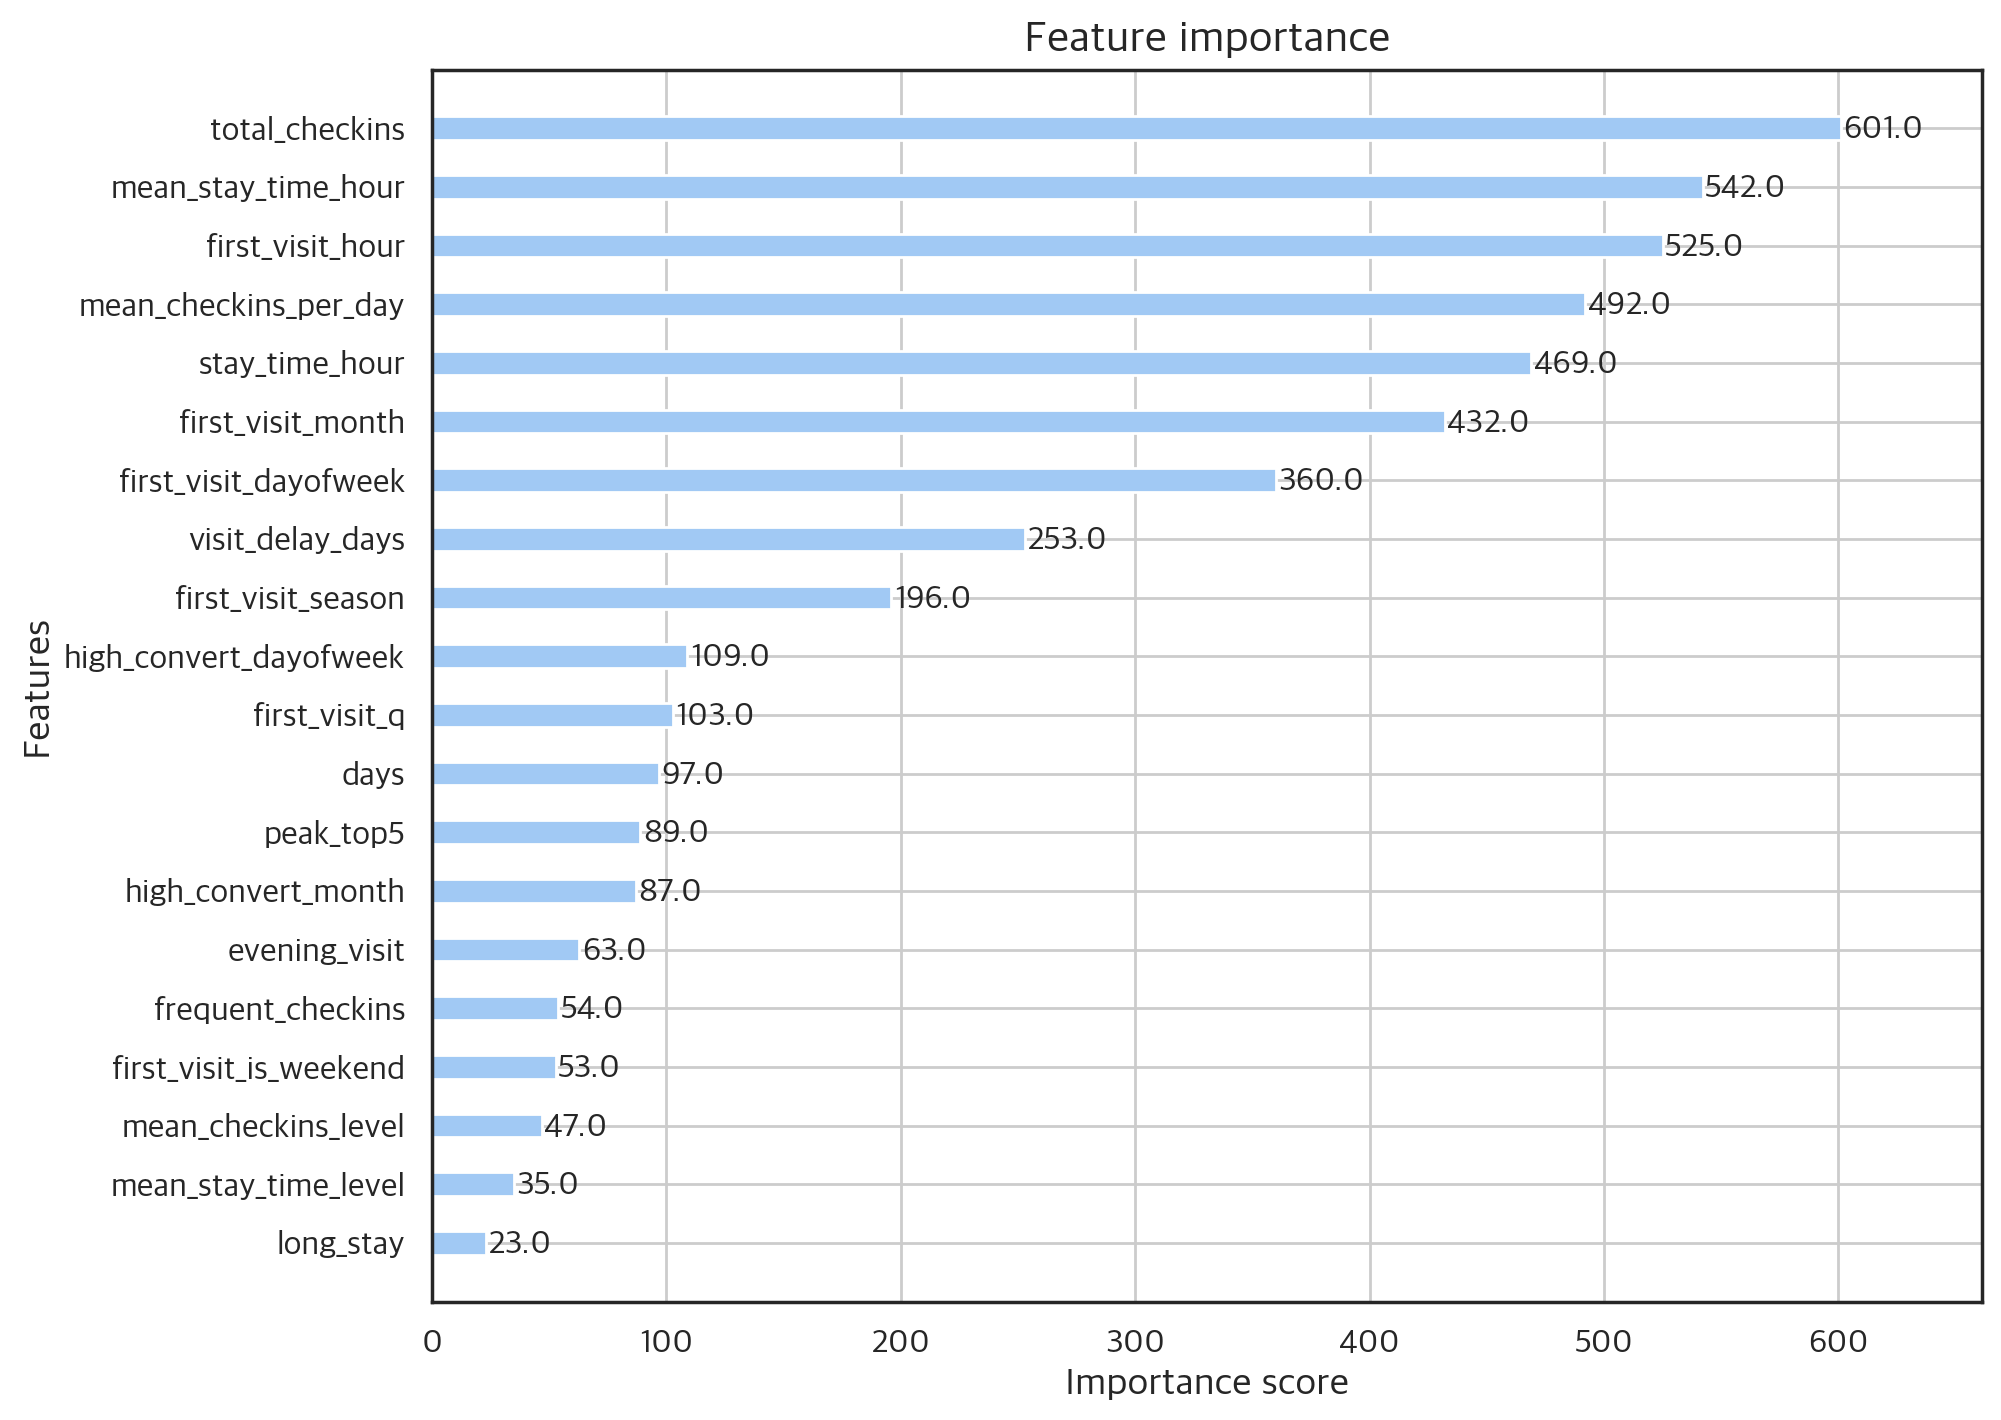

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_clf_m, ax=ax, max_num_features=20, height=0.4)
plt.show()

### 3.4.4 Permutation Importance ÌôïÏù∏

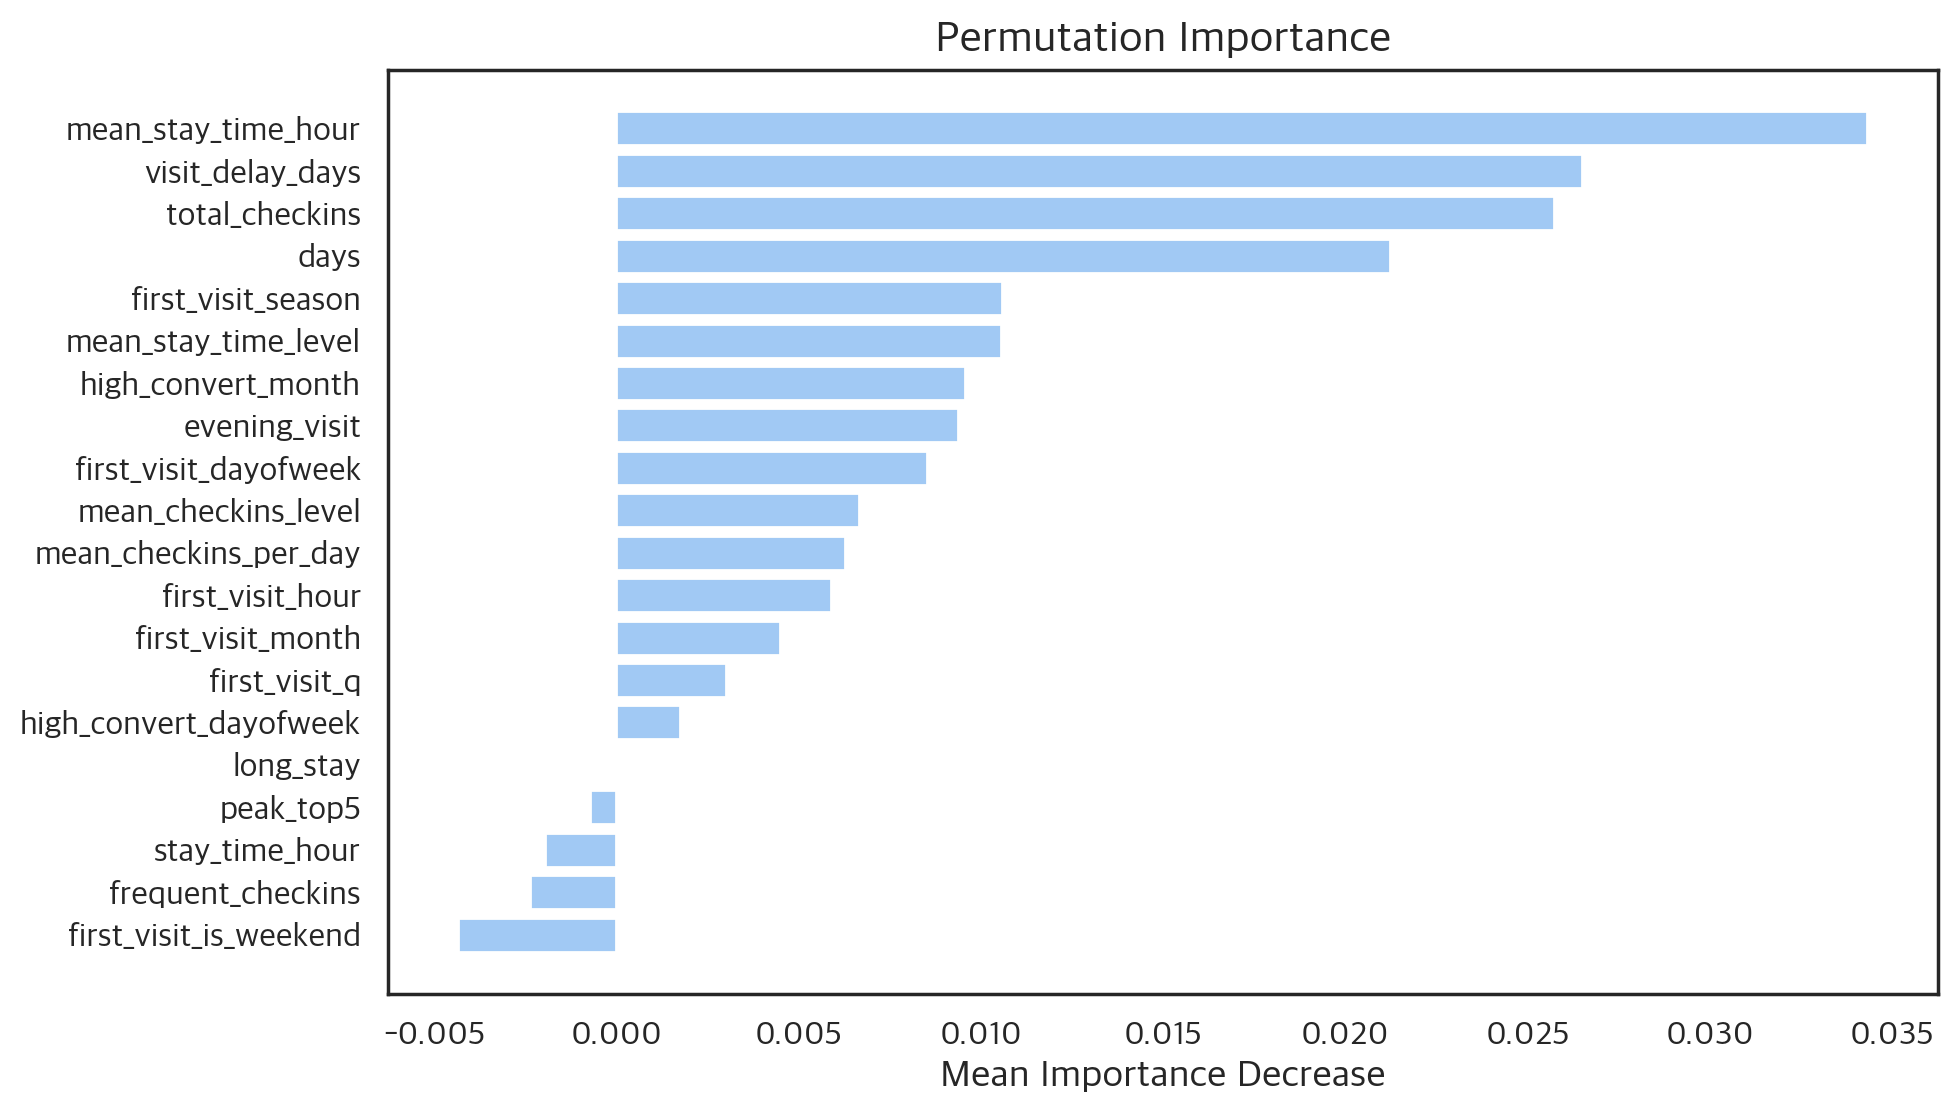

In [17]:
xgb_clf_m.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)

result = permutation_importance(xgb_clf_m, X_val, y_val, scoring='f1', n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [X_val.columns[i] for i in sorted_idx])
plt.xlabel("Mean Importance Decrease")
plt.title("Permutation Importance")
plt.show()

### 3.4.5 SHAP ÌôïÏù∏

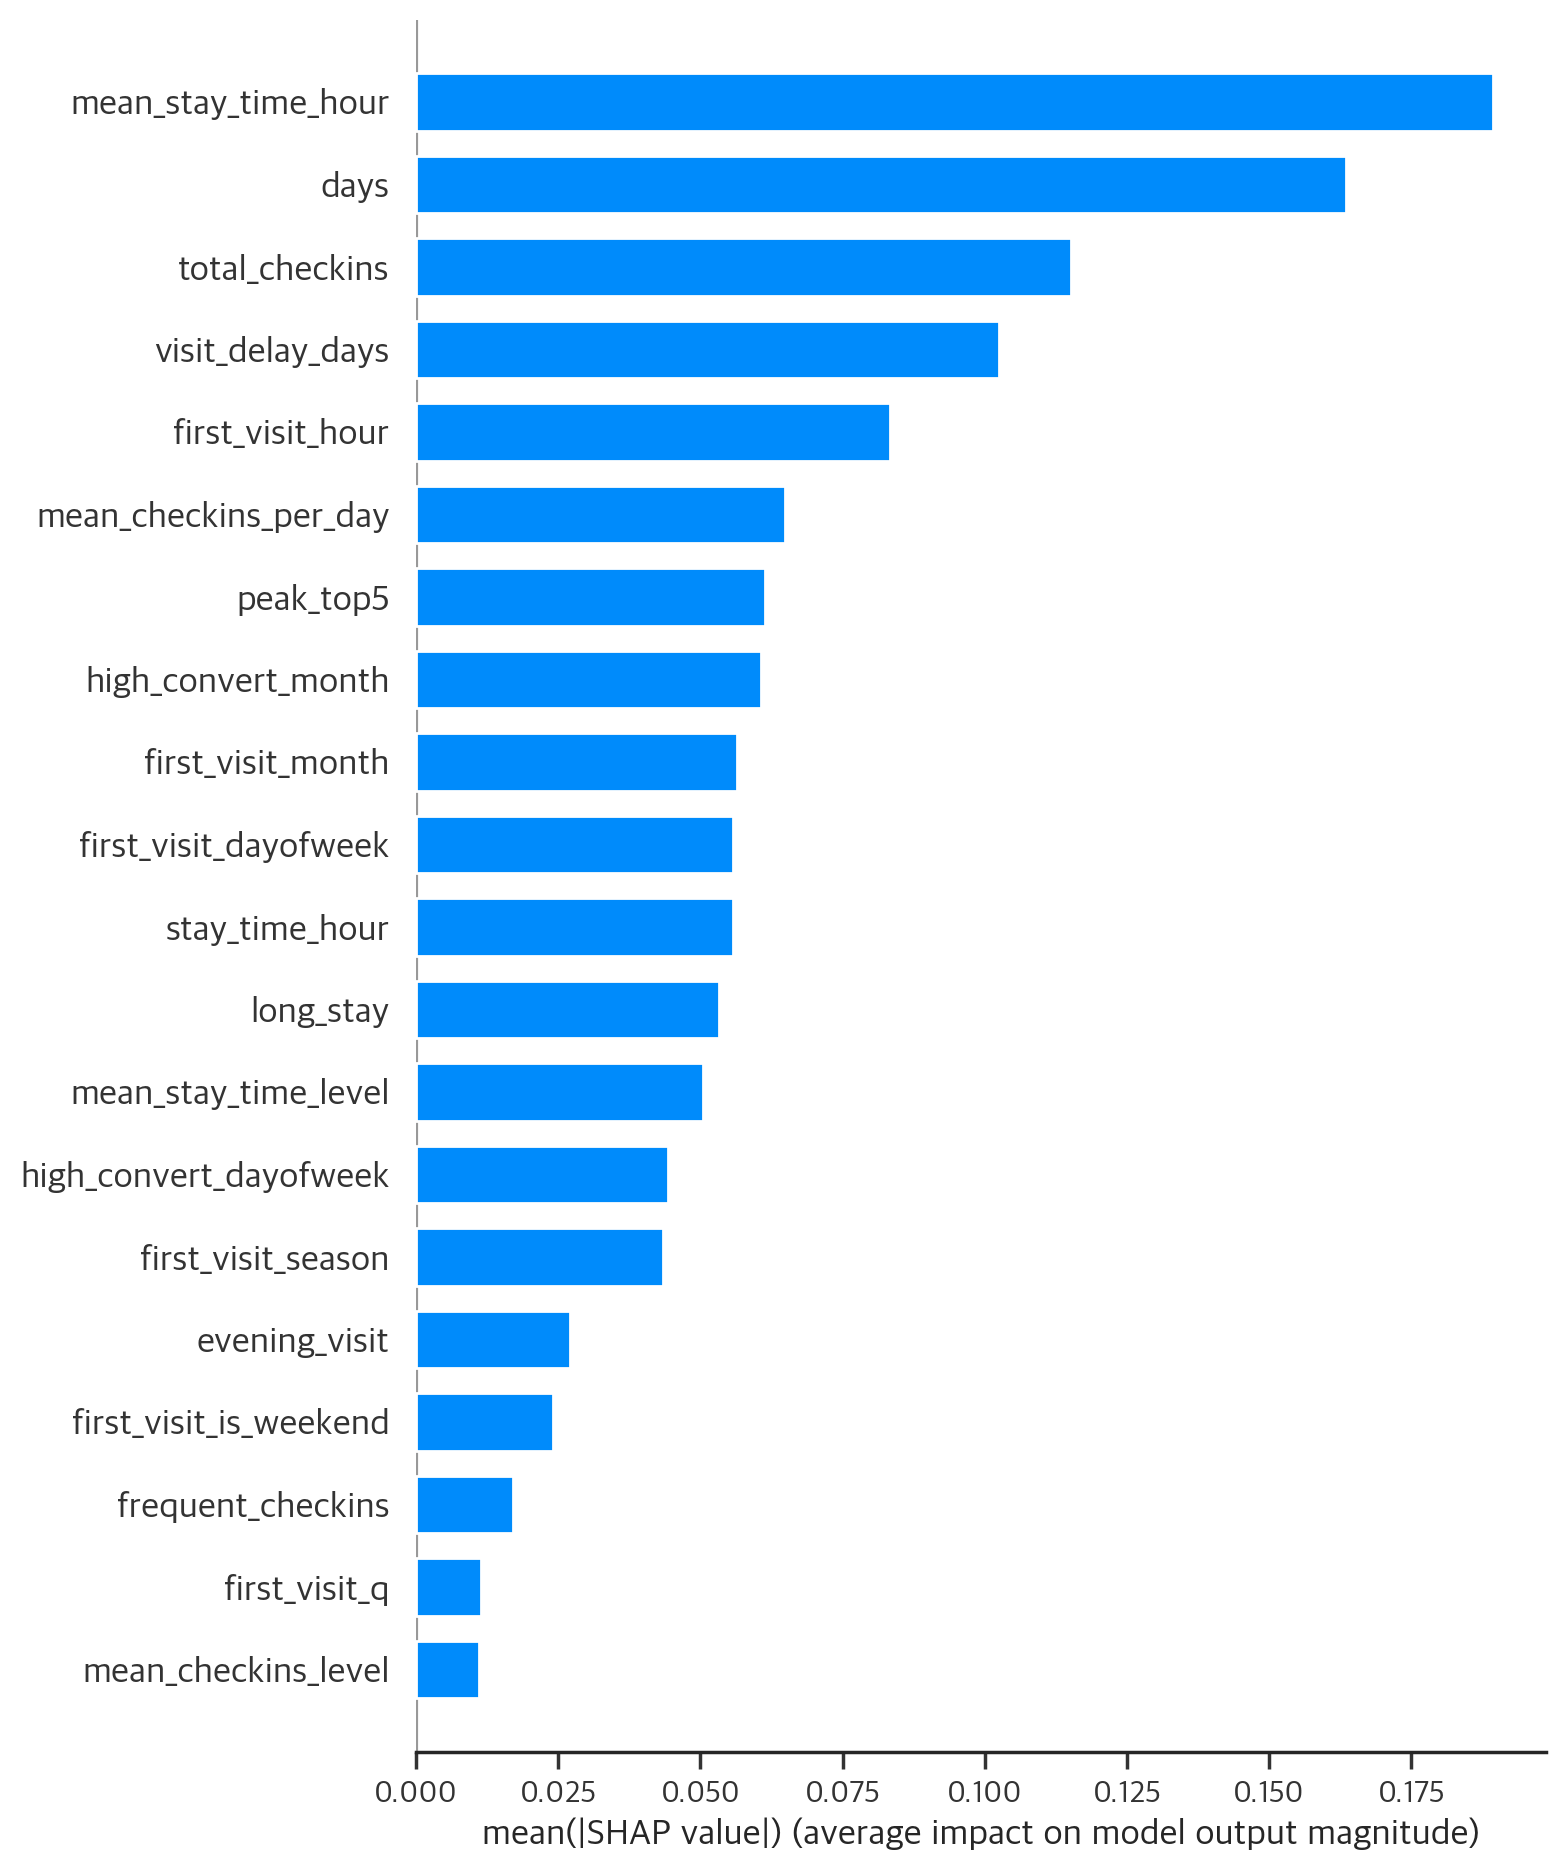

In [18]:
xgb_clf_m.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)

explainer = shap.TreeExplainer(xgb_clf_m)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")
plt.show()

- `total_checkins`, `mean_stay_time_hour`, `first_visit_hour`Îäî plot_importance Í∏∞Ï§ÄÏóêÏÑú ÏûêÏ£º ÏÇ¨Ïö©Îêú ÌïµÏã¨ Î∂ÑÍ∏∞ ÌîºÏ≤òÎ°ú ÌôïÏù∏
- permutation importanceÏôÄ SHAP Î∂ÑÏÑùÏóêÏÑúÎäî `days`, `visit_delay_days`, `mean_stay_time_hour`Í∞Ä Î™®Îç∏ ÏòàÏ∏° ÏÑ±Îä•Ïóê Ïã§ÏßàÏ†Å ÏòÅÌñ•ÏùÑ Ï£ºÎäî Ï£ºÏöî Î≥ÄÏàòÎ°ú Î∂ÄÍ∞ÅÎêòÏñ¥ Î™®Îç∏ ÎÇ¥Ïô∏Î∂Ä Í¥ÄÏ†êÏóêÏÑúÏùò ÌîºÏ≤ò Ï§ëÏöîÎèÑÏóê Ï∞®Ïù¥Í∞Ä ÏûàÏùåÏùÑ ÌôïÏù∏

### 3.4.6 ÌïµÏã¨ ÌîºÏ≤ò Ï§ëÏã¨Ïùò ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ± Î∞è Î∂àÌïÑÏöîÌïú ÌîºÏ≤ò Ï†úÍ±∞

- ÏòàÏ∏° ÏÑ±Îä• Ìñ•ÏÉÅÏùÑ ÏúÑÌï¥ Îã®Ïàú ÌîºÏ≤ò Í∞Ñ ÏÉÅÌò∏ÏûëÏö©ÏùÑ Î∞òÏòÅÌïú `delay_ratio`, `engagement_score` Îì± ÌñâÎèô ÌäπÏÑ±Í≥º Ï≤¥Î•ò Ìå®ÌÑ¥ÏùÑ Ï°∞Ìï©Ìïú ÌååÏÉù Î≥ÄÏàòÎ•º ÏÉàÎ°ú ÏÉùÏÑ±ÌñàÍ≥†, `frequent_checkins`, `mean_checkins_level` Îì±ÏùÄ Ï§ëÎ≥µ Ï†ïÎ≥¥ ÎòêÎäî Ï§ëÏöîÎèÑ Î∂ÑÏÑùÏóêÏÑú ÏòÅÌñ•Î†•Ïù¥ ÎÇÆÏùÄ ÌîºÏ≤òÎ°ú ÌåêÎã®ÎêòÏñ¥ Ï†úÍ±∞

In [25]:
user = pd.read_csv('user.csv', parse_dates=['first_visit', 'last_visit', 'trial_date'])
user.head()

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   
2  2ba8ab19-2d40-4423-ad04-f0f9ca814871 2023-12-21 21:31:16   
3  1d49ba36-6c23-405b-9514-aa7f4aeceff0 2023-12-21 21:16:39   
4  b2d80cf6-2ced-4270-9d7a-43119bba35d2 2023-12-22 15:37:55   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   
2 2023-12-21 22:50:51               2               1     1           0   
3 2023-12-21 22:50:56               2               1     1           0   
4 2023-12-22 17:59:12               2               2     1           0   

  trial_date  visit_delay_days  mean_checkins_per_day  mean_checkins_level  \
0 2023-12-21                 0                    6.0                    3   
1 2023-12-21                 0                    2.0                    2   
2 2023-12-21                 0                    2.0                    2   
3 2023-12-21                 0                    2.0                    2   
4 2023-12-22                 0                    2.0                    2   

   frequent_checkins  mean_stay_time_hour  mean_stay_time_level  long_stay  \
0                  1                  5.0                     2          1   
1                  0                  3.0                     2          0   
2                  0                  1.0                     1          0   
3                  0                  1.0                     1          0   
4                  0                  2.0                     1          0   

   first_visit_month  first_visit_q  first_visit_season  high_convert_month  \
0                 12              4                   4                   0   
1                 12              4                   4                   0   
2                 12              4                   4                   0   
3                 12              4                   4                   0   
4                 12              4                   4                   0   

   evening_visit  first_visit_dayofweek  high_convert_dayofweek  \
0              0                      3                       0   
1              0                      3                       0   
2              1                      3                       0   
3              1                      3                       0   
4              0                      4                       0   

   first_visit_is_weekend  first_visit_hour  peak_top5  
0                       0                 9          0  
1                       0                 4          0  
2                       0                21          0  
3                       0                21          0  
4                       0                15          1

In [26]:
user.columns

Index(['user_uuid', 'first_visit', 'last_visit', 'total_checkins',
       'stay_time_hour', 'days', 'is_payment', 'trial_date',
       'visit_delay_days', 'mean_checkins_per_day', 'mean_checkins_level',
       'frequent_checkins', 'mean_stay_time_hour', 'mean_stay_time_level',
       'long_stay', 'first_visit_month', 'first_visit_q', 'first_visit_season',
       'high_convert_month', 'evening_visit', 'first_visit_dayofweek',
       'high_convert_dayofweek', 'first_visit_is_weekend', 'first_visit_hour',
       'peak_top5'],
      dtype='object')

In [27]:
# ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±
user['delay_ratio'] = user['visit_delay_days'] / user['days']  # Ï†ÑÏ≤¥ Í∏∞Í∞Ñ ÎåÄÎπÑ Î∞©Î¨∏ ÏßÄÏó∞ ÎπÑÏú®
user['engagement_score'] = user['mean_checkins_per_day'] * user['stay_time_hour']  # Ï≤¥Î•ò Î∞è ÌôúÎèôÏ†ïÎèÑ ÎèôÏãú Î∞òÏòÅ
user['avg_stay_per_checkin'] = user['stay_time_hour'] / user['total_checkins']  # 1Ìöå Î∞©Î¨∏Îãπ ÌèâÍ∑† Ï≤¥Î•ò ÏãúÍ∞Ñ
user['evening_stay_intensity'] = user['evening_visit'] * user['mean_stay_time_hour']  # ÏïºÍ∞Ñ ÏßëÏ§ëÎèÑ
user['weekend_stay_time'] = user['first_visit_is_weekend'] * user['mean_stay_time_hour']  # Ï£ºÎßê Î∞©Î¨∏Ïãú Ï≤¥Î•ò ÏãúÍ∞Ñ Ï§ëÏã¨ Î∂ÑÏÑù

In [28]:
# Ï†úÍ±∞ ÎåÄÏÉÅ Î≥ÄÏàò
drop_features = ['mean_checkins_level', 'frequent_checkins', 'first_visit_q', 'first_visit_is_weekend', 'long_stay']
user.drop(columns=drop_features, inplace=True)

user.head()

user_uuid         first_visit  \
0  2b251333-8676-4c11-a736-dcf2350f8821 2023-12-21 09:13:47   
1  e111619a-0975-451b-9a4a-bc8aea7b7b84 2023-12-21 04:42:07   
2  2ba8ab19-2d40-4423-ad04-f0f9ca814871 2023-12-21 21:31:16   
3  1d49ba36-6c23-405b-9514-aa7f4aeceff0 2023-12-21 21:16:39   
4  b2d80cf6-2ced-4270-9d7a-43119bba35d2 2023-12-22 15:37:55   

           last_visit  total_checkins  stay_time_hour  days  is_payment  \
0 2023-12-21 16:04:09               6               5     1           0   
1 2023-12-21 15:21:05               2               3     1           0   
2 2023-12-21 22:50:51               2               1     1           0   
3 2023-12-21 22:50:56               2               1     1           0   
4 2023-12-22 17:59:12               2               2     1           0   

  trial_date  visit_delay_days  mean_checkins_per_day  mean_stay_time_hour  \
0 2023-12-21                 0                    6.0                  5.0   
1 2023-12-21                 0                    2.0                  3.0   
2 2023-12-21                 0                    2.0                  1.0   
3 2023-12-21                 0                    2.0                  1.0   
4 2023-12-22                 0                    2.0                  2.0   

   mean_stay_time_level  first_visit_month  first_visit_season  \
0                     2                 12                   4   
1                     2                 12                   4   
2                     1                 12                   4   
3                     1                 12                   4   
4                     1                 12                   4   

   high_convert_month  evening_visit  first_visit_dayofweek  \
0                   0              0                      3   
1                   0              0                      3   
2                   0              1                      3   
3                   0              1                      3   
4                   0              0                      4   

   high_convert_dayofweek  first_visit_hour  peak_top5  delay_ratio  \
0                       0                 9          0          0.0   
1                       0                 4          0          0.0   
2                       0                21          0          0.0   
3                       0                21          0          0.0   
4                       0                15          1          0.0   

   engagement_score  avg_stay_per_checkin  evening_stay_intensity  \
0              30.0              0.833333                     0.0   
1               6.0              1.500000                     0.0   
2               2.0              0.500000                     1.0   
3               2.0              0.500000                     1.0   
4               4.0              1.000000                     0.0   

   weekend_stay_time  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

### 3.4.7 XGBoost Ïû¨ÌïôÏäµ

In [29]:
X = user.drop(columns=['user_uuid', 'first_visit', 'last_visit', 'trial_date', 'is_payment'])
y = user['is_payment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=151)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=151)

# Î™®Îç∏ Ï†ïÏùò
xgb_clf = XGBClassifier(n_estimators=500, early_stopping_rounds=50, random_state=151)

# MLflow
mlflow.set_experiment("boosting_experiment")

with mlflow.start_run(run_name='third_model'):
    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
    xgb_pred = xgb_clf.predict(X_test)
    xgb_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

    # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
    get_clf_eval(y_test, xgb_pred, xgb_pred_proba)

    # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
    accuracy = np.round(accuracy_score(y_test, xgb_pred), 4)
    precision = np.round(precision_score(y_test, xgb_pred), 4)
    recall = np.round(recall_score(y_test, xgb_pred), 4)
    f1 = np.round(f1_score(y_test, xgb_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, xgb_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞
    mlflow.log_params({
        'model_type': "XGBClassifier",
        'n_estimators': 500,
        "early_stopping_rounds": 50
    })

    # ÌèâÍ∞Ä ÏßÄÌëú
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

Ïò§Ï∞®ÌñâÎ†¨:
[[1016  152]
 [ 465  218]]

Ï†ïÌôïÎèÑ: 0.6667
Ï†ïÎ∞ÄÎèÑ: 0.5892
Ïû¨ÌòÑÏú®: 0.3192
f1_score: 0.4141
roc_auc: 0.6507


- ÌååÏÉù Î≥ÄÏàò Ï∂îÍ∞Ä Î∞è Ï§ëÏöîÎèÑ ÎÇÆÏùÄ ÌîºÏ≤ò Ï†úÍ±∞ ÌõÑ Ïû¨ÌïôÏäµÌïú XGBoost Î™®Îç∏ÏùÄ Ï†ïÌôïÎèÑ 0.6715, F1_Score 0.4432Î°ú ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä•ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑúÎèÑ Ï†ïÎ∞ÄÎèÑ 0.5917Í∞Ä Ìñ•ÏÉÅÎêòÏóàÏùå.
- Îî∞ÎùºÏÑú Î™®Îç∏Ïù¥ Îçî Ï†ïÏ†úÎêú ÌîºÏ≤òÎ•º Í∏∞Î∞òÏúºÎ°ú Í∏çÏ†ï ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌï¥ Îçî Ïã†Ï§ëÌïòÍ≥† Ìö®Ïú®Ï†ÅÏúºÎ°ú ÏòàÏ∏°ÌïòÍ≤å ÎêòÏóàÏùåÏùÑ Ïïå Ïàò ÏûàÏùå.

### 3.4.8 Î≤†Ïù¥ÏßÄÏïà ÏµúÏ†ÅÌôî Í∏∞Î∞òÏùò hyperopt Ï†ÅÏö©

In [30]:
# Í≥µÍ∞Ñ Ï†ïÏùò
space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95)
}

# Î™©Ï†ÅÌï®Ïàò Ï†ïÏùò
def objective_xgb(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        learning_rate=space['learning_rate'],
        colsample_bytree=space['colsample_bytree'],
        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1])
    )

    score = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy')
    
    return {'loss': -np.mean(score), 'status': STATUS_OK}

# ÏµúÏ†ÅÌôî
trials_xgb = Trials()
best_xgb = fmin(
    fn=objective_xgb,
    space=space_xgb,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_xgb
)

with mlflow.start_run(run_name='third_model'):
    xgb_clf_m = XGBClassifier(
                        n_estimators=int(best_xgb['n_estimators']),
                        learning_rate=np.round(best_xgb['learning_rate'], 5),
                        colsample_bytree=np.round(best_xgb['colsample_bytree'], 5),
                        max_depth=int(best_xgb['max_depth']),
                        min_child_weight=int(best_xgb['min_child_weight']),
                        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1]),
                        early_stopping_rounds=50,
                        random_state=151
    )

    xgb_clf_m.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
    xgb_m_pred = xgb_clf_m.predict(X_test)
    xgb_m_pred_proba = xgb_clf_m.predict_proba(X_test)[:, 1]

    # ÎÖ∏Ìä∏Î∂Å Í≤∞Í≥º Ï∂úÎ†•
    get_clf_eval(y_test, xgb_m_pred, xgb_m_pred_proba)

    # ÌèâÍ∞Ä Î≥ÄÏàò ÏÉùÏÑ±
    accuracy = np.round(accuracy_score(y_test, xgb_m_pred), 4)
    precision = np.round(precision_score(y_test, xgb_m_pred), 4)
    recall = np.round(recall_score(y_test, xgb_m_pred), 4)
    f1 = np.round(f1_score(y_test, xgb_m_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, xgb_m_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞
    mlflow.log_params({
        "model_type": "XGBClassifier",
        'n_estimators': int(best_xgb['n_estimators']),
        'learning_rate': np.round(best_xgb['learning_rate'], 5),
        'colsample_bytree': np.round(best_xgb['colsample_bytree'], 5),
        'max_depth': int(best_xgb['max_depth']),
        'min_child_weight': int(best_xgb['min_child_weight']),
        'scale_pos_weight': (y.value_counts()[0] / y.value_counts()[1]),
        'early_stopping_rounds': 50
    })

    # ÌèâÍ∞Ä ÏßÄÌëú
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [01:37<00:00,  1.94s/trial, best loss: -0.6108886511881542]
Ïò§Ï∞®ÌñâÎ†¨:
[[799 369]
 [302 381]]

Ï†ïÌôïÎèÑ: 0.6375
Ï†ïÎ∞ÄÎèÑ: 0.5080
Ïû¨ÌòÑÏú®: 0.5578
f1_score: 0.5318
roc_auc: 0.6606


- ÌîºÏ≤ò Ïû¨Íµ¨ÏÑ± Ïù¥ÌõÑ Î≤†Ïù¥ÏßÄÏïà ÏµúÏ†ÅÌôîÎ•º ÌÜµÌï¥ XGBoostÎ•º Îã§Ïãú ÏµúÏ†ÅÌôîÌïú Í≤∞Í≥º, F1_ScoreÎäî Í∏∞Ï°¥ 0.4432ÏóêÏÑú 0.4946, Ïû¨ÌòÑÏú®ÏùÄ 0.3543ÏóêÏÑú 0.5037Î°ú Í∑†Ìòï Ïû°Ìûå ÏòàÏ∏° ÏÑ±Îä•ÏùÑ Îã¨ÏÑ±ÌïòÏòÄÏùå.
- Ï†ïÌôïÎèÑÏôÄ AUCÎäî Îã§ÏÜå ÎÇÆÏïÑÏ°åÏßÄÎßå, ÏñëÏÑ± ÌÅ¥ÎûòÏä§ ÌÉêÏßÄÎ†• Ìñ•ÏÉÅÍ≥º ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä• Ïú†ÏßÄ Ï∏°Î©¥ÏóêÏÑú Ïú†ÏùòÎØ∏Ìïú Í∞úÏÑ†ÏùÑ ÌôïÏù∏

### 3.4.9 SMOTETomek Í∏∞Î≤ï Ï†ÅÏö©

- ÌòÑÏû¨ÍπåÏßÄÏùò Î™®Îç∏ÎßÅ Í≤∞Í≥ºÎ°ú Í∏∞Ï°¥ Î≤†Ïù¥Ïä§ÎùºÏù∏ Î™®Îç∏Ïóê ÎπÑÌï¥ÏÑú Ï†ÑÎ∞òÏ†ÅÏù∏ ÏÑ±Îä• Ìñ•ÏÉÅÏùÑ Î≥¥Ïù¥Í≥† ÏûàÏßÄÎßå ÏïÑÏßÅÍπåÏßÄ ÏÜåÏàò ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú ÌÉêÏßÄÎ†•Ïù¥ Î∂ÄÏ°±ÌïòÎã§Í≥† ÌåêÎã®ÎêòÏóàÍ≥† Îî∞ÎùºÏÑú ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌïòÍ≥†Ïûê, Í≥ºÏÜåÌëúÎ≥∏ Ï†úÍ±∞(Tomek Links)ÏôÄ Í≥ºÎåÄÌëúÎ≥∏ ÏÉùÏÑ±(SMOTE)ÏùÑ Í≤∞Ìï©Ìïú SMOTETomek Í∏∞Î≤ïÏùÑ Ï†ÅÏö©ÌïòÏó¨, ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î•º ÎçîÏö± Í∑†Ìòï ÏûàÍ≤å Íµ¨ÏÑ±Ìï®ÏúºÎ°úÏç® Î™®Îç∏Ïù¥ ÏÜåÏàò ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú ÏùºÎ∞òÌôî ÏÑ±Îä•ÏùÑ ÎÜíÏùº Ïàò ÏûàÎèÑÎ°ù Ï°∞Ï†ï

In [33]:
# SMOTETomek Ï†ÅÏö©
resampler = SMOTETomek(random_state=151)
X_res, y_res = resampler.fit_resample(X_train, y_train)

with mlflow.start_run(run_name='third_model'):
    xgb_clf_sm = XGBClassifier(
        n_estimators=int(best_xgb['n_estimators']),
        learning_rate=round(best_xgb['learning_rate'], 5),
        colsample_bytree=round(best_xgb['colsample_bytree'], 5),
        max_depth=int(best_xgb['max_depth']),
        min_child_weight=int(best_xgb['min_child_weight']),
        random_state=151
    )

    # Î™®Îç∏ ÌïôÏäµ
    xgb_clf_sm.fit(X_res, y_res)

    # ÏòàÏ∏°
    y_pred = xgb_clf_sm.predict(X_test)
    y_pred_proba = xgb_clf_sm.predict_proba(X_test)[:, 1]

    # ÌèâÍ∞Ä Ìï®Ïàò Ìò∏Ï∂ú
    get_clf_eval(y_test, y_pred, y_pred_proba)

    # ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞
    accuracy = np.round(accuracy_score(y_test, y_pred), 4)
    precision = np.round(precision_score(y_test, y_pred), 4)
    recall = np.round(recall_score(y_test, y_pred), 4)
    f1 = np.round(f1_score(y_test, y_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, y_pred_proba), 4)

    # ÌååÎùºÎØ∏ÌÑ∞ Î°úÍπÖ
    mlflow.log_params({
        "model_type": "XGBClassifier_SMOTETomek",
        'n_estimators': int(best_xgb['n_estimators']),
        'learning_rate': round(best_xgb['learning_rate'], 5),
        'colsample_bytree': round(best_xgb['colsample_bytree'], 5),
        'max_depth': int(best_xgb['max_depth']),
        'min_child_weight': int(best_xgb['min_child_weight']),
        'resampling': 'SMOTETomek'
    })

    # ÌèâÍ∞Ä ÏßÄÌëú Î°úÍπÖ
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

Ïò§Ï∞®ÌñâÎ†¨:
[[861 307]
 [360 323]]

Ï†ïÌôïÎèÑ: 0.6397
Ï†ïÎ∞ÄÎèÑ: 0.5127
Ïû¨ÌòÑÏú®: 0.4729
f1_score: 0.4920
roc_auc: 0.6593


In [35]:
def precision_recall_curve_plot(y_test , pred_proba):
    # threshold ndarrayÏôÄ Ïù¥ thresholdÏóê Îî∞Î•∏ Ï†ïÎ∞ÄÎèÑ, Ïû¨ÌòÑÏú® ndarray Ï∂îÏ∂ú. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba)
    
    # XÏ∂ïÏùÑ thresholdÍ∞íÏúºÎ°ú, YÏ∂ïÏùÄ Ï†ïÎ∞ÄÎèÑ, Ïû¨ÌòÑÏú® Í∞íÏúºÎ°ú Í∞ÅÍ∞Å Plot ÏàòÌñâ. Ï†ïÎ∞ÄÎèÑÎäî Ï†êÏÑ†ÏúºÎ°ú ÌëúÏãú
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold Í∞í X Ï∂ïÏùò ScaleÏùÑ 0.1 Îã®ÏúÑÎ°ú Î≥ÄÍ≤Ω
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # xÏ∂ï, yÏ∂ï labelÍ≥º legend, Í∑∏Î¶¨Í≥† grid ÏÑ§Ï†ï
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

- SMOTETomekÏùÑ ÌôúÏö©Ìï¥ ÌÅ¥ÎûòÏä§ Î∂àÍ∑†ÌòïÏùÑ Î≥¥Ï†ïÌïú Í≤∞Í≥º, Ïû¨ÌòÑÏú®Ïù¥ 0.4685ÍπåÏßÄ Í∞úÏÑ†ÎêòÎ©∞ ÏñëÏÑ± ÌÅ¥ÎûòÏä§ ÌÉêÏßÄ ÏÑ±Îä•Ïù¥ Ìñ•ÏÉÅÎêòÏóàÍ≥†, F1_ScoreÎèÑ 0.4812Î°ú ÏïàÏ†ïÏ†ÅÏù∏ ÏàòÏ§ÄÏùÑ Í∏∞Î°ù
- Ï∂îÍ∞ÄÎ°ú ÏûÑÍ≥ÑÍ∞í Î∂ÑÏÑùÏùÑ ÌÜµÌï¥ precision‚Äìrecall Í∞Ñ trade-off Íµ¨Ï°∞Î•º ÌôïÏù∏ÌñàÏúºÎ©∞, ÎπÑÏ¶àÎãàÏä§ Î™©Ï†ÅÏóê ÎßûÎäî Í∏∞Ï§ÄÍ∞í Ï°∞Ï†ï ÌïÑÏöî

> SMOTETomek Í∏∞Î≤ïÏùÑ Ï†ÅÏö©Ìï®ÏúºÎ°úÏç® ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï ÏôÑÌôîÎ•º ÌÜµÌï¥ Ïû¨ÌòÑÏú®(Recall)Í≥º ROC AUCÎäî ÏùºÏ†ï ÏàòÏ§Ä Í∞úÏÑ†ÎêòÏóàÏúºÎÇò,
> Ï†ïÎ∞ÄÎèÑ(Precision)Í∞Ä ÎÇÆÏïÑÏßÄÎ©¥ÏÑú F1-scoreÏôÄ Ï†ïÌôïÎèÑ Îì±Ïùò Ï¢ÖÌï© ÏÑ±Îä•ÏùÄ XGBoost Îã®ÎèÖ Î™®Îç∏Î≥¥Îã§ Îã§ÏÜå ÌïòÎùΩÌñàÏäµÎãàÎã§.
> Ïù¥Îäî SMOTEÍ∞Ä minority class ÏÉòÌîåÏùÑ Ïù∏ÏúÑÏ†ÅÏúºÎ°ú ÏÉùÏÑ±ÌïòÍ≥† TomekLinksÍ∞Ä ÏùºÎ∂Ä majority ÏÉòÌîåÏùÑ Ï†úÍ±∞Ìï®Ïóê Îî∞Îùº,
Îç∞Ïù¥ÌÑ∞Ïùò Î∂ÑÌè¨Í∞Ä ÏôúÍ≥°ÎêòÍ±∞ÎÇò Í≤ΩÍ≥ÑÍ∞Ä Î™®Ìò∏Ìï¥Ï†∏ Î™®Îç∏Ïùò Í≤∞Ï†ï Í≤ΩÍ≥ÑÍ∞Ä Í≥ºÏ†ÅÌï©(overfitting)ÎêòÏóàÏùÑ Í∞ÄÎä•ÏÑ±ÏùÑ ÏãúÏÇ¨Ìï©ÎãàÎã§.

## 3.5 Ïä§ÌÉúÌÇπ ÏïôÏÉÅÎ∏î

- Îã®Ïùº Î™®Îç∏Ïóê ÎåÄÌï¥ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî, ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ, ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ï≤òÎ¶¨(SMOTETomek) Îì±Ïùò Îã§ÏñëÌïú Í∞úÏÑ† ÏûëÏóÖÏùÑ ÏàòÌñâÌñàÏùåÏóêÎèÑ, ÏÑ±Îä•(ÌäπÌûà Ïû¨ÌòÑÏú®, F1-score) Ìñ•ÏÉÅÏóê ÌïúÍ≥ÑÍ∞Ä ÏûàÎã§Îäî Ï†êÏùÑ ÌôïÏù∏ÎêòÏñ¥ ÏÑúÎ°ú Îã§Î•∏ ÏïåÍ≥†Î¶¨Ï¶ò Í∞ÑÏùò Î≥¥ÏôÑÏ†Å ÌäπÏÑ±ÏùÑ ÌôúÏö©ÌïòÏó¨ ÏÑ±Îä•ÏùÑ Í∑πÎåÄÌôîÌï† Ïàò ÏûàÎäî Ïä§ÌÉúÌÇπ ÏïôÏÉÅÎ∏îÍ∏∞Î≤ïÏùÑ ÎèÑÏûÖÌï¥ÏÑú Í∞úÎ≥Ñ Î™®Îç∏Ïùò Ìé∏Ìñ•Í≥º Î∂ÑÏÇ∞ÏùÑ Ï§ÑÏù¥Í≥†, ÏùºÍ¥ÄÎêòÎ©¥ÏÑúÎèÑ Í∞ïÍ±¥Ìïú ÏòàÏ∏° ÏÑ±Îä•ÏùÑ ÌôïÎ≥¥ÌïòÍ∏∞ ÏúÑÌïú Ï†ÑÎûµÏùÑ ÏàòÎ¶Ω

In [37]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))

    print(model.__class__.__name__, 'model ÏãúÏûë')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\tÌè¥Îìú ÏÑ∏Ìä∏:', folder_counter, 'ÏãúÏûë')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]
        X_te = X_train_n.iloc[valid_index]

        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(X_test_n)  # Ìè¥ÎìúÎ≥Ñ ÏòàÏ∏°Í∞í Ï†ÄÏû•

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)  # Ìè¥Îìú ÌèâÍ∑† ÏòàÏ∏°Í∞í ÏÇ¨Ïö©

    return train_fold_pred, test_pred_mean  # Î©îÌÉÄ Î™®Îç∏ ÌïôÏäµÏö©, ÌÖåÏä§Ìä∏Ïö© Îç∞Ïù¥ÌÑ∞ Î∞òÌôò


In [39]:
rf_clf_for_stacking = RandomForestClassifier(n_estimators=500)
xgb_clf_for_stacking = XGBClassifier(n_estimators=500)
lgbm_clf_for_stacking = LGBMClassifier(n_estimators=500)
ada_clf_for_stacking = AdaBoostClassifier(n_estimators=500)

rf_train, rf_test = get_stacking_base_datasets(rf_clf_for_stacking, X_train, y_train, X_test, 7)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_clf_for_stacking, X_train, y_train, X_test, 7)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_clf_for_stacking, X_train, y_train, X_test, 7)
ada_trian, ada_test = get_stacking_base_datasets(ada_clf_for_stacking, X_train, y_train, X_test, 7)

RandomForestClassifier model ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 0 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 1 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 2 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 3 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 4 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 5 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 6 ÏãúÏûë
XGBClassifier model ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 0 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 1 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 2 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 3 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 4 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 5 ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 6 ÏãúÏûë
LGBMClassifier model ÏãúÏûë
	Ìè¥Îìú ÏÑ∏Ìä∏: 0 ÏãúÏûë
[LightGBM] [Info] Number of positive: 1465, number of negative: 2236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 3701, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395839 -> initscore=-0.422833
[LightGBM] [Info] Start training from score -0.422833
	Ìè¥Îìú ÏÑ∏Ìä∏: 1 ÏãúÏûë
[LightGBM] [Info] N

In [40]:
Stack_final_X_train = np.concatenate((rf_train, xgb_train, lgbm_train, ada_trian), axis=1)
Stack_final_X_test = np.concatenate((rf_test, xgb_test, lgbm_test, ada_test), axis=1)

lr_final = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=151)

lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)
stack_final_prob = lr_final.predict_proba(Stack_final_X_test)[:, 1]

In [41]:
get_clf_eval(y_test, stack_final, stack_final_prob)

Ïò§Ï∞®ÌñâÎ†¨:
[[839 329]
 [351 332]]

Ï†ïÌôïÎèÑ: 0.6326
Ï†ïÎ∞ÄÎèÑ: 0.5023
Ïû¨ÌòÑÏú®: 0.4861
f1_score: 0.4940
roc_auc: 0.6346


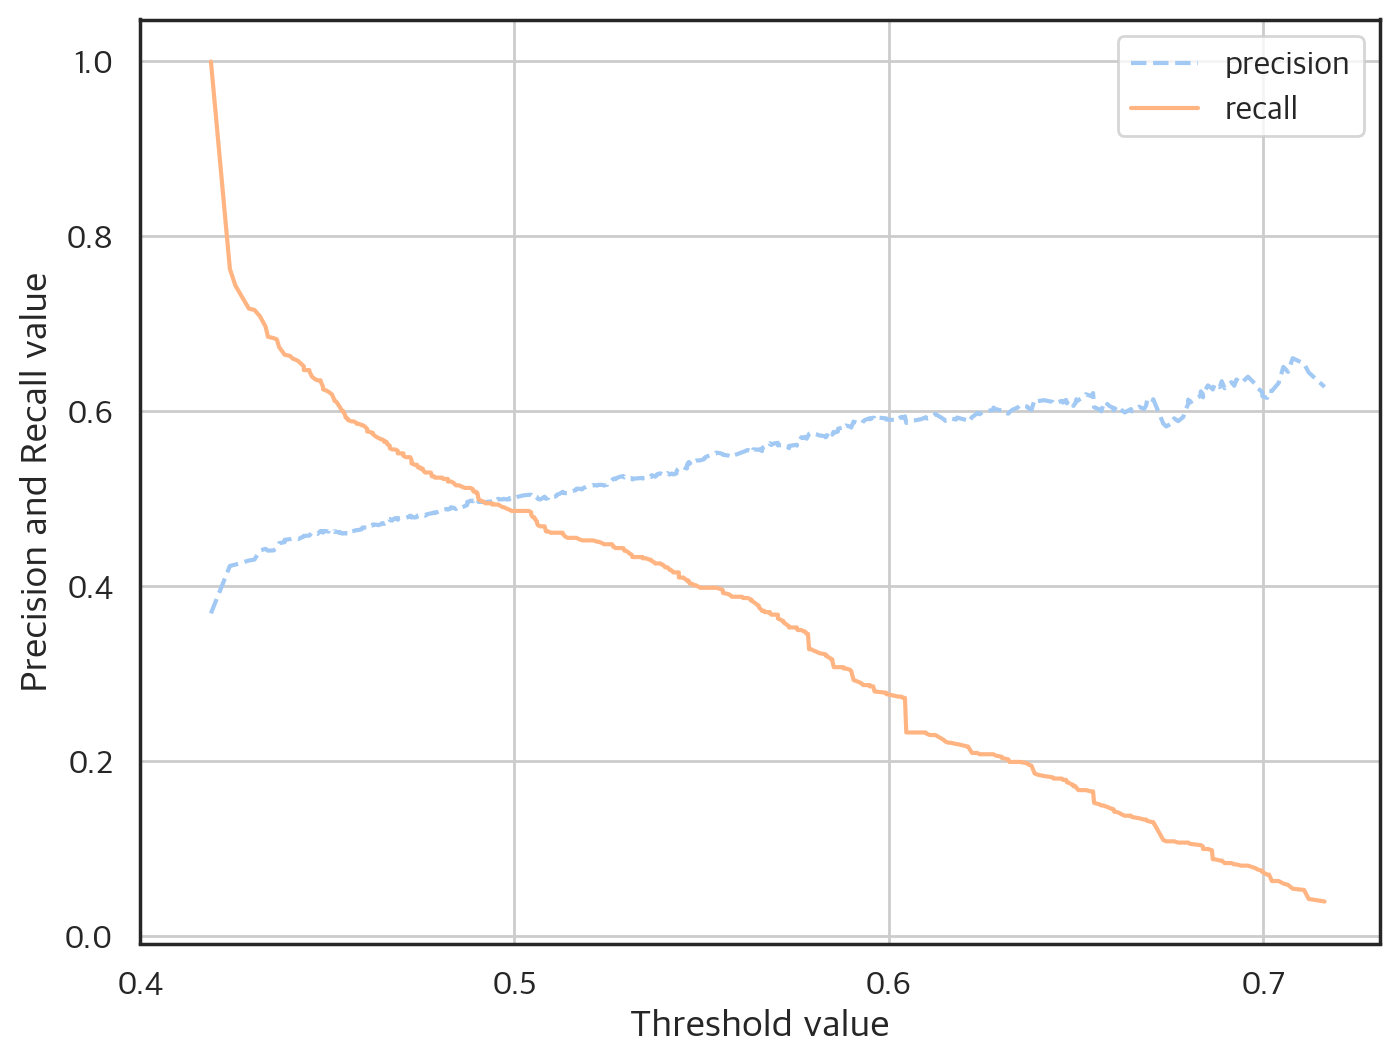

In [42]:
precision_recall_curve_plot(y_test, stack_final_prob)

- XGBoost, RandomForest, LightGBM, AdaBoostÎ•º Í∏∞Î∞ò Î™®Îç∏Î°ú Íµ¨ÏÑ±ÌïòÍ≥†, Î©îÌÉÄ Î™®Îç∏Î°úÎäî Ìï¥ÏÑù Í∞ÄÎä•ÏÑ±Í≥º Í≥ºÏ†ÅÌï© Î∞©ÏßÄÏóê Í∞ïÏ†êÏù¥ ÏûàÎäî Logistic RegressionÏùÑ ÏÇ¨Ïö©Ìïú Í≤∞Í≥º F1 Score 0.5142, Ïû¨ÌòÑÏú® 0.5168Î°ú Í∞ÄÏû• Í∑†Ìòï Ïû°Ìûå ÏÑ±Îä•ÏùÑ Î≥¥ÏûÑ
- ÏûÑÍ≥ÑÍ∞í Ï°∞Ï†ï Ïãú 0.5 Î∂ÄÍ∑ºÏóêÏÑú precisionÍ≥º recallÏù¥ ÍµêÏ∞®ÌïòÎ©∞ ÏïàÏ†ïÏ†Å Í∑†ÌòïÏùÑ ÌòïÏÑ±Ìï¥, Ìï¥Îãπ ÏïôÏÉÅÎ∏î Î™®Îç∏ÏùÄ Ïã§Î¨¥ Ï†ÅÏö© Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùÄ ÏµúÏ¢Ö ÌõÑÎ≥¥Î°ú ÌåêÎã®

| Î™®Îç∏                              | ÏÑ†ÌÉù Ïù¥Ïú†                              |
| ------------------------------- | ---------------------------------- |
| **XGBoost**                     | Í∞ïÎ†•Ìïú ÏÑ±Îä•Í≥º Ï†ïÍµêÌïú Î∂ÑÍ∏∞ Í∏∞Ï§Ä                  |
| **RandomForest**                | ÏïôÏÉÅÎ∏î Í∏∞Î∞ò ÎûúÎç§ÏÑ± ‚Üí Îã§Î•∏ Í¥ÄÏ†êÏùò ÏòàÏ∏° Í∞ÄÎä•          |
| **LightGBM**                    | Îπ†Î•¥Í≥† Ìö®Ïú®Ï†Å, Îã§Î•∏ boosting ÏïåÍ≥†Î¶¨Ï¶òÍ≥º Î≥¥ÏôÑÏ†Å     |
| **AdaBoost**                    | Í∞ÄÎ≤ºÏö¥ Í∞ÄÏ§ëÏπò Í∏∞Î∞ò Î™®Îç∏ ‚Üí Ïò§Î•òÏóê ÎØºÍ∞êÌïòÍ≤å Î∞òÏùë        |
| **Logistic Regression (Î©îÌÉÄ Î™®Îç∏)** | Í≥ºÏ†ÅÌï©Ïóê Í∞ïÌïòÍ≥†, Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± ÎÜíÏúºÎ©∞ ÏïàÏ†ïÏ†ÅÏù∏ ÏòàÏ∏° Ï°∞Ìï© Í∞ÄÎä• |


# 4. ÏµúÏ¢Ö Ï†ïÎ¶¨

## 4.1 Î∂ÑÏÑù Í≥ºÏ†ï ÏöîÏïΩ
- Ïù¥Î≤à Î∂ÑÏÑùÏùÄ Ïú†Ï†Ä Î∞©Î¨∏ Î∞è ÌñâÎèô Î°úÍ∑∏ Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú Ïú†Î£å Ï†ÑÌôò Ïó¨Î∂ÄÎ•º Ïù¥ÏßÑ Î∂ÑÎ•ò Î™®Îç∏Î°ú ÏòàÏ∏°ÌïòÎäî Í≤ÉÏù¥ ÌïµÏã¨ Î™©Ìëú
- Ï†ÑÏ≤¥ Í≥ºÏ†ïÏùÄ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ‚Üí ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ ‚Üí Î™®Îç∏ ÎπÑÍµê Î∞è ÌäúÎãù ‚Üí ÏÑ±Îä• ÌèâÍ∞Ä ‚Üí ÏïôÏÉÅÎ∏î Ï†ÅÏö©Ïùò ÌùêÎ¶ÑÏúºÎ°ú Íµ¨ÏÑ±

## 4.2 Î™®Îç∏ ÎπÑÍµê Î∞è ÏÑ±Îä• Ìñ•ÏÉÅ Í≥ºÏ†ï ÏöîÏïΩ

| Î™®Îç∏ | F1 Score | Recall | Precision | Accuracy | ROC AU |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression (baseline)| 0.3506 | 0.2563 | 0.5545 | 0.6337 | 0.6019 |
| Random Forest (ÌäúÎãù ÌõÑ)| 0.4792 | 0.4426 | 0.5223 | 0.6288 | 0.6385 |
| XGBoost (ÌäúÎãù Ï†Ñ)| 0.4073 | 0.3263 | 0.5419 | 0.6337 | 0.6435 |
| XGBoost + Hyperopt ÌäúÎãù| 0.5212 | 0.5518 | 0.4937 | 0.6089 | 0.6477 |
| XGBoost + SMOTETomek| 0.4812 | 0.4685 | 0.4946 | 0.6272 | 0.6366 |
| Stacking ÏïôÏÉÅÎ∏î ÏµúÏ¢Ö Î™®Îç∏| 0.5142 | 0.5168 | 0.5116 | 0.6397 | 0.6341 |

- F1 Score 0.35 ‚Üí 0.51Î°ú ÏïΩ 46% Ïù¥ÏÉÅ ÏÑ±Îä• Ìñ•ÏÉÅ
- Recall(Ïû¨ÌòÑÏú®) 0.25 ÏàòÏ§ÄÏóêÏÑú ‚Üí 0.51 Ïù¥ÏÉÅÏúºÎ°ú ÏñëÏÑ± ÌÅ¥ÎûòÏä§(Ïú†Î£å Ï†ÑÌôò Í≥†Í∞ù) ÌÉêÏßÄ ÏÑ±Îä• 2Î∞∞ Ìñ•ÏÉÅ

## 4.3 Í≤∞Î°†
- Îã®Ïàú Î™®Îç∏(Logistic Regression) ÎåÄÎπÑ ÏïΩ 1.5Î∞∞ Ïù¥ÏÉÅÏùò Ïú†Î£å Ï†ÑÌôò Í≥†Í∞ù ÌÉêÏßÄ Îä•Î†• Ìñ•ÏÉÅÏùÑ Îã¨ÏÑ±ÌïòÏòÄÏúºÎ©∞, ÏòàÏ∏° Î™®Îç∏Ïù¥ Ïã§ÏßàÏ†ÅÏúºÎ°ú ÏùòÎØ∏ ÏûàÎäî ÌîºÏ≤òÎ•º Î∞îÌÉïÏúºÎ°ú ÌïôÏäµÌï®ÏùÑ Ï†ïÎüâÏ†Å/ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú Í≤ÄÏ¶ù
- ÏµúÏ¢Ö Ïä§ÌÉúÌÇπ Î™®Îç∏ÏùÄ Ï†ïÌôïÎèÑ 63.9%, F1 Score 0.514, AUC 0.634 ÏàòÏ§ÄÏúºÎ°ú Ï†ïÎ∞ÄÎèÑÏôÄ Ïû¨ÌòÑÏú®Ïùò Í∑†ÌòïÏùÑ ÏïàÏ†ïÏ†ÅÏúºÎ°ú Ïú†ÏßÄÌïòÍ≥† ÏûàÏñ¥ Ïã§Î¨¥ Ï†ÅÏö© Í∞ÄÎä•ÏÑ±Ïù¥ Îß§Ïö∞ ÎÜíÏäµÎãàÎã§.
- Ìñ•ÌõÑ Î™®Îç∏ ÏÑ±Îä• Í∞úÏÑ† Ïó¨ÏßÄÎ°úÎäî Îã§ÏùåÍ≥º Í∞ôÏùÄ Î∂ÄÎ∂ÑÏùÑ Ï†úÏïà
    - ÏÑ±Î≥Ñ/ÎÇòÏù¥/ÎîîÎ∞îÏù¥Ïä§ Îì± Ïô∏Î∂Ä Î≥ÄÏàò Ïó∞Îèô Ïãú Ï∂îÍ∞Ä ÏÑ±Îä• Ìñ•ÏÉÅ Í∞ÄÎä•ÏÑ±
    - ÏÇ¨Ïö©ÏûêÍµ∞Î≥Ñ Íµ∞ÏßëÌôî ÌõÑ ÎßûÏ∂§Ìòï ÏòàÏ∏° Î™®Îç∏ Ï†ÅÏö©
    - ÏòàÏ∏° Í≤∞Í≥ºÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìïú Î¶¨ÎßàÏºÄÌåÖ ÏûêÎèôÌôî ÌååÏù¥ÌîÑÎùºÏù∏ ÏÑ§Í≥Ñ